# 1. Build your own convolutional neural network using pytorch

1. aplly image augmentation on train dataset, image resize transforme on val dataset
2. split the train dataset and val dataset
3. desgin model
4. set hyperprameters
5. generate dataloder
6. train and val process
7. RUN train and plot the accuracy change and loss change in line chart
8. draw the train matrix confusion and test matrix confusion

7. plot the result image
8. upload the paper


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import csv
from skimage import color
from skimage.feature import hog
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader, TensorDataset,Dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
import time
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import ConcatDataset
import gc
import random
import os
import shutil
import random
import torch
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## 1.aplly image augmentation on train dataset, image resize transforme on val dataset

1. calculate the mean, std
2. create transform for train, val, test

1. calculate the mean, std

In [2]:
def compute_mean_std(image_folder):
    data = []
    for root, dirs, files in os.walk(image_folder):
        for file in files:
            if file.endswith(('.jpg','.png')):
                img_path = os.path.join(root, file)
                image = Image.open(img_path).convert("RGB")
                image = image.resize((224, 224))
                data.append(np.array(image) / 255.0)

    data = np.stack(data)
    mean = data.mean(axis=(0, 1, 2))
    std = data.std(axis=(0, 1, 2))
    return mean, std

In [3]:
image_folder = "/home/xin/Homework Week5/Homework Week5/Training"
labels = ["Score_1", "Score_2", "Score_3", "Score_4"]

mean, std = compute_mean_std(image_folder)
mean, std

(array([0.41696703, 0.31227958, 0.3026024 ]),
 array([0.23832833, 0.20447036, 0.23873863]))

2. create transform for train, val, test

In [4]:
common_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.41696804, 0.31227915, 0.30260377),
        std=(0.1695, 0.1573, 0.1856))
])

train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(size=224, scale=(0.6, 0.6), ratio=(1, 1)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    common_transforms
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    common_transforms
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    common_transforms
])

## 2.split the train dataset and val dataset

1. herachically seperate the train and val dataset in same ratio
2. define the train_dataset and val_dataset.

1. herachically seperate the train and val dataset in same ratio

In [5]:
# def print_image_ratios_for_dir(folder_path):
#     total_images = 0
#     class_counts = {}

#     # Calculate the total number of images and count per class
#     for class_folder in os.listdir(folder_path):
#         class_path = os.path.join(folder_path, class_folder)
#         image_count = len([img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))])
#         class_counts[class_folder] = image_count
#         total_images += image_count

#     # Print the ratios
#     print(f"Image Ratios for {os.path.basename(folder_path)}:")
#     for class_folder, count in class_counts.items():
#         ratio = (count / total_images) * 100
#         print(f"{class_folder}: {ratio:.2f}%")

#     return total_images

# def print_image_ratios(folder_path):
#     total_images = 0
#     class_counts = {}

#     # Calculate the total number of images and count per class
#     for class_folder in os.listdir(folder_path):
#         class_path = os.path.join(folder_path, class_folder)
#         image_count = len([img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))])
#         class_counts[class_folder] = image_count
#         total_images += image_count

#     # Print the ratios
#     print(f"Image Ratios for {os.path.basename(folder_path)}:")
#     for class_folder, count in class_counts.items():
#         ratio = (count / total_images) * 100
#         print(f"{class_folder}: {ratio:.2f}%")

# def hierarchical_sampling(image_folder_path, train_ratio=0.8):
#     # List all category folders
#     class_folders = [d for d in os.listdir(image_folder_path) if os.path.isdir(os.path.join(image_folder_path, d))]
    
#     # Create 'train' and 'val' directories
#     train_folder = os.path.join(image_folder_path, 'train')
#     val_folder = os.path.join(image_folder_path, 'val')
#     os.makedirs(train_folder, exist_ok=True)
#     os.makedirs(val_folder, exist_ok=True)
    
#     for class_folder in class_folders:
#         class_path = os.path.join(image_folder_path, class_folder)
#         images = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp'))]
#         random.shuffle(images)  # Randomize the order of images

#         # Determine the number of training samples based on train_ratio
#         train_count = int(len(images) * train_ratio)
        
#         # Create corresponding 'train' and 'val' category folders
#         train_class_folder = os.path.join(train_folder, class_folder)
#         val_class_folder = os.path.join(val_folder, class_folder)
#         os.makedirs(train_class_folder, exist_ok=True)
#         os.makedirs(val_class_folder, exist_ok=True)
        
#         # Copy images to the respective 'train' and 'val' directories
#         for i, image in enumerate(images):
#             source = os.path.join(class_path, image)
#             if i < train_count:
#                 destination = os.path.join(train_class_folder, image)
#             else:
#                 destination = os.path.join(val_class_folder, image)
#             shutil.copy2(source, destination)
        
#         print_image_ratios(train_folder)
#         print_image_ratios(val_folder)

#         train_images_count = print_image_ratios_for_dir(train_folder)
#         val_images_count = print_image_ratios_for_dir(val_folder)

#         # Print the overall image ratio between train and val
#         total_images = train_images_count + val_images_count
#         print(f"\nOverall Image Ratios:")
#         print(f"Train: {train_images_count / total_images * 100:.2f}%")
#         print(f"Val: {val_images_count / total_images * 100:.2f}%")

#         # Remove the original category folder
#         shutil.rmtree(class_path)
    

# image_folder_path = '/home/xin/Homework Week5/Homework Week5/Training copy'  # Replace with your actual image folder path
# hierarchical_sampling(image_folder_path, train_ratio=0.9)


### Results


### Train:
- **Score_2:** 42.73%
- **Score_3:** 16.28%
- **Score_1:** 39.24%
- **Score_4:** 1.74%

### Val:
- **Score_2:** 42.74%
- **Score_3:** 16.24%
- **Score_1:** 38.46%
- **Score_4:** 2.56%

### Overall Image Ratios:
- **Train:** 89.82%
- **Val:** 10.18%

2. define the train_dataset and val_dataset and test dataset.

In [6]:
class TrainDataset(Dataset):
    def __init__(self, image_folder, labels, device,transform=None):
        self.image_folder = image_folder
        self.labels = labels
        self.transform = transform if transform else transforms.ToTensor()
        self.data = []
        self.device = device
        self.label_map = {
            "Score_1": 0,
            "Score_2": 1,
            "Score_3": 2,
            "Score_4": 3
        }
        self._prepare_data()

    def _prepare_data(self):
        for label in self.labels:
            label_folder = os.path.join(self.image_folder, label)
            for image_name in os.listdir(label_folder):
                if image_name.endswith(('.jpg','.png')):
                    image_path = os.path.join(label_folder, image_name)
                    self.data.append((image_path, self.label_map[label]))  
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        label = torch.tensor(label, dtype=torch.long, device=self.device)
        try:
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            return None, label
        return image.to(self.device), label.to(self.device)

In [7]:
class ValDataset(Dataset):
    def __init__(self, image_folder, labels, device,transform=None):
        self.image_folder = image_folder
        self.labels = labels
        self.transform = transform if transform else transforms.ToTensor()
        self.data = []
        self.device = device
        self.label_map = {
            "Score_1": 0,
            "Score_2": 1,
            "Score_3": 2,
            "Score_4": 3
        }
        self._prepare_data()

    def _prepare_data(self):
        for label in self.labels:
            label_folder = os.path.join(self.image_folder, label)
            for image_name in os.listdir(label_folder):
                if image_name.endswith(('.jpg','.png')):
                    image_path = os.path.join(label_folder, image_name)
                    self.data.append((image_path, self.label_map[label]))  
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        label = torch.tensor(label, dtype=torch.long, device=self.device)
        try:
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            return None, label
        return image.to(self.device), label.to(self.device)

In [8]:
class TestDataset(Dataset):
    def __init__(self, test_path, device,transform=None):
        self.test_path = test_path
        self.transform = transform
        self.device = device
        self.data = []
        self._prepare_data()

    def _prepare_data(self):
        for name in os.listdir(self.test_path):    
            if name.endswith(('.jpg','.png')):    
                image_path = os.path.join(self.test_path, name)
                self.data.append((image_path, name))  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, name = self.data[idx]
        try:
            image = Image.open(image_path)
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image from {image_path}: {e}")
            return None, name 
        return image.to(self.device), name

In [51]:
train_path ='/home/xin/Homework Week5/Homework Week5/Training copy/train'
val_path = '/home/xin/Homework Week5/Homework Week5/Training copy/val'
test_path = '/home/xin/Homework Week5/Homework Week5/Test'

label = ['Score_1', 'Score_2', 'Score_3', 'Score_4']

train_dataset = TrainDataset(train_path, label,device, transform=train_transform) 
val_dataset = ValDataset(val_path, label,device, transform=val_transform)
test_dataset = TestDataset(test_path, device, transform=test_transform)

len_total=len(train_dataset)+len(val_dataset)+len(test_dataset)

print('train:',len(train_dataset)/len_total,'val:', len(val_dataset)/len_total, 'test:',len(test_dataset)/len_total)
print('*'*50)
print("The shape of the training data is: ", train_dataset[0][0].shape)
print("The shape of the validation data is: ", val_dataset[0][0].shape)
print("The shape of the testing data is: ", test_dataset[0][0].shape)

print("the label of the training data is: ", train_dataset[0][1])
print("the label of the validation data is: ", val_dataset[0][1])

print("the length of the training data is: ", len(train_dataset))
print("the length of the validation data is: ", len(val_dataset))
print("the length of the testing data is: ", len(test_dataset))



train: 0.6749509483322433 val: 0.07652060170045781 test: 0.2485284499672989
**************************************************
The shape of the training data is:  torch.Size([3, 224, 224])
The shape of the validation data is:  torch.Size([3, 224, 224])
The shape of the testing data is:  torch.Size([3, 224, 224])
the label of the training data is:  tensor(0, device='cuda:0')
the label of the validation data is:  tensor(0, device='cuda:0')
the length of the training data is:  1032
the length of the validation data is:  117
the length of the testing data is:  380


Plot image categories distribution

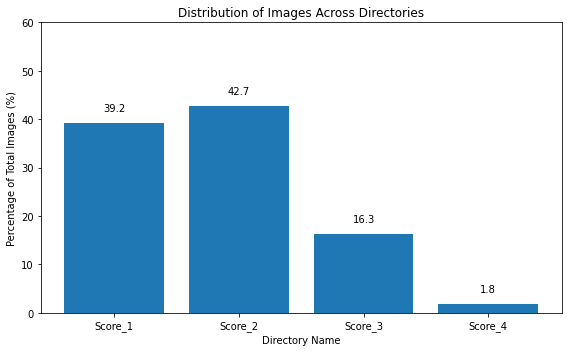

In [82]:
def plot_image_distribution(path):
    # Get the directories and sort them by name
    dirs = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

    # Count the number of images in each directory
    image_counts = []
    for directory in dirs:
        image_files = [f for f in os.listdir(os.path.join(path, directory)) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        image_counts.append(len(image_files))

    # Calculate the total number of images across all directories
    total_images = sum(image_counts)

    # Calculate the percentages
    percentages = [(count / total_images) * 100 for count in image_counts]

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.bar(dirs, percentages)
    plt.xlabel('Directory Name')
    plt.ylabel('Percentage of Total Images (%)')
    plt.title('Distribution of Images Across Directories')
    plt.ylim(0, 60)  # Set y-axis limits from 0 to 110 for a better view

    # Display percentage above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval, 1), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Replace 'your_path_here' with the path to your parent directory
plot_image_distribution('/home/xin/Homework Week5/Homework Week5/Training')


Images of four categories and their labels

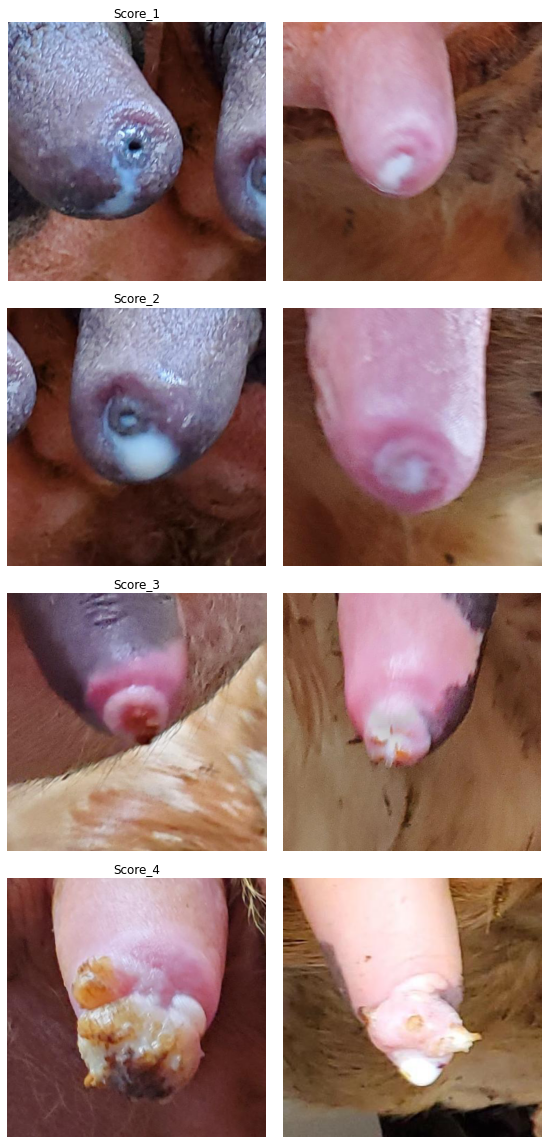

In [69]:
def plot_from_path(path):
    # Get the directories and sort them by name
    dirs = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 16))

    for i, directory in enumerate(dirs):
        # Get all image files in the directory and sort them by name
        image_files = sorted([f for f in os.listdir(os.path.join(path, directory)) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
        
        for j, image_file in enumerate(image_files[:2]):  # take first 2 images
            ax = axes[i][j]
            img_path = os.path.join(path, directory, image_file)
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')

        # Set title for the row
        axes[i][0].set_title(directory)

    plt.tight_layout()
    plt.show()

# Replace 'your_path_here' with the path to your parent directory
plot_from_path('/home/xin/Homework Week5/Homework Week5/Training')


Normalization Image of four categories

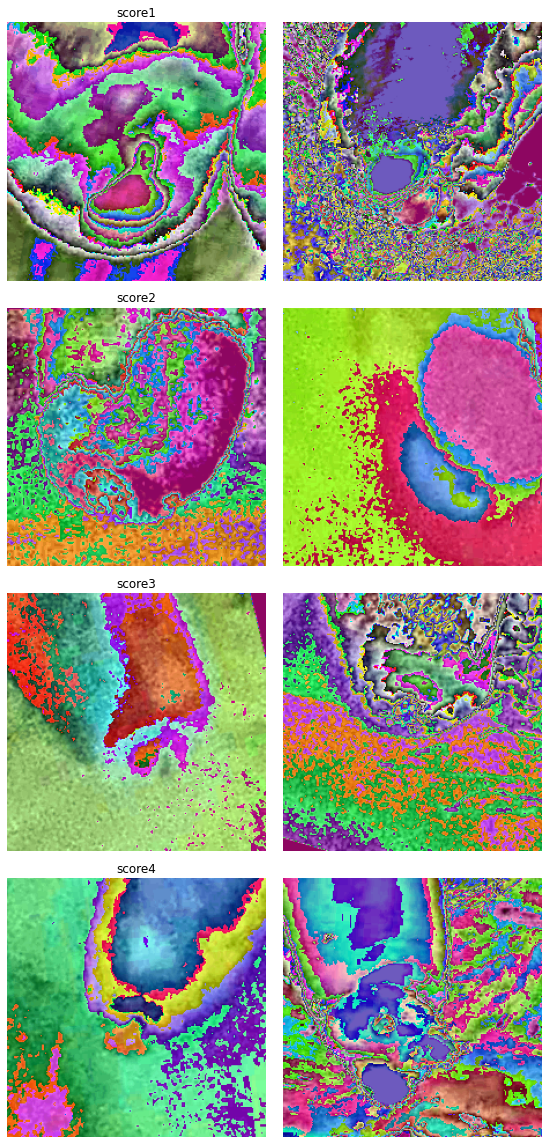

In [70]:
def plot_images(train_dataset):
    # Find the unique labels in the dataset
    unique_labels = list(set([label.item() for _, label in train_dataset]))

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 16))

    # Loop through each unique label
    for row, label in enumerate(unique_labels):
        # Filter the dataset for images with the current label
        images_with_label = [img for img, lbl in train_dataset if lbl == label]
        
        # Assuming we want to show 2 images per label, adjust accordingly
        for col in range(2):
            ax = axes[row][col]
            img = transforms.ToPILImage()(images_with_label[col])
            ax.imshow(img)
            ax.axis('off')
        
        # Set title for the row
        axes[row][0].set_title(f'score{label + 1}')

    plt.tight_layout()
    plt.show()

# Assuming train_dataset is already defined
plot_images(train_dataset)


## 3.desgin model

#### CowTeatResnet Model Description

#### Basic Components

**1. conv function:(7,2,3)**
   - Initial convolution layer to extract features.
   - Relatively large kernel size.

**2. Residual Blocks:**
   - Preserves the identity function with addition of more feature maps.
   - Helps in addressing the vanishing gradient problem, allows for deeper networks.

**3. Inception Modules:**
   - Enables the network to compute features at various scales.
   - Incorporates different kernel sizes.

**4. conv function:(3,2,1)**
   - Extracts further features before pooling.
   - Standard kernel size with padding to maintain spatial dimensions.

**5. AdaptiveAvgPool2d:**
   - Reduces spatial dimensions to 1x1, preparing the tensor for fully connected layers.

**6. Fully Connected layers:**
   - Transformations and projections of features to produce final classification scores.

### Blocks in Sequence:

1. **Initial Convolution**: Single conv layer to start feature extraction.
   
2. **Residual Blocks with Inception**: Alternating residual blocks and inception modules for rich feature extraction.

3. **Final Convolution**: Further feature extraction before final pooling.

4. **Fully Connected Layers**: Three linear layers for classification.


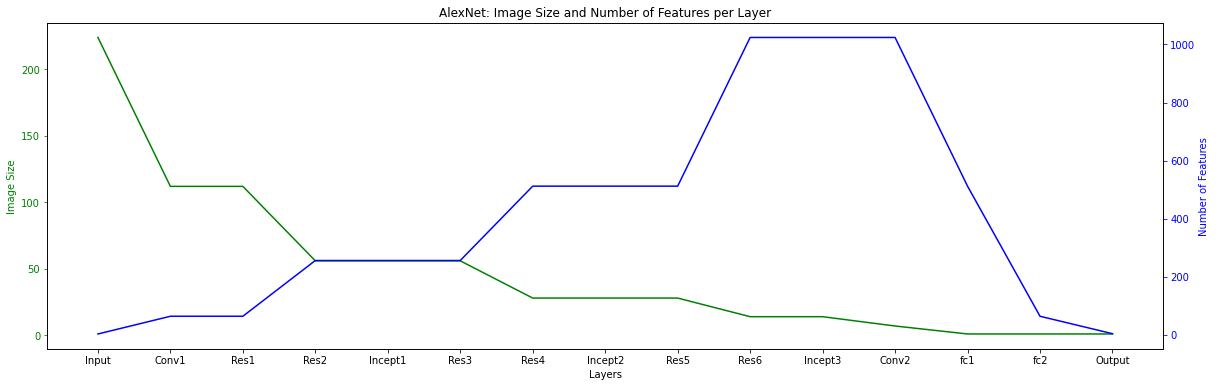

In [49]:
import matplotlib.pyplot as plt

# 20 Layers
layers = ['Input', 'Conv1', 'Res1', 'Res2', 'Incept1','Res3','Res4', 'Incept2','Res5','Res6', 'Incept3', 'Conv2', 'fc1', 'fc2', 'Output']

# Image Sizes change
sizes = [224,112,112,56,56,56,28,28,28,14,14,7,1,1,1]

# Number of Features change
features = [3, 64, 64, 256, 256, 256, 512, 512, 512,1024,1024,1024,512,64,4]

# Plotting
fig, ax1 = plt.subplots(figsize=(20, 6))

# Twin the axes
ax2 = ax1.twinx()

# Plotting Image Sizes
ax1.plot(layers, sizes, 'g-')
ax1.set_xlabel('Layers')
ax1.set_ylabel('Image Size', color='g')
ax1.tick_params('y', colors='g')

# Plotting Number of Features
ax2.plot(layers, features, 'b-')
ax2.set_ylabel('Number of Features', color='b')
ax2.tick_params('y', colors='b')

# Show the plot
plt.title("ResNet: Image Size and Number of Features per Layer")
plt.show()

In [10]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If the stride is not 1, or the input and output channels are not equal,
        # we need to reshape the input using a 1x1 convolution.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [11]:
class InceptionModule_256(nn.Module):
    
    
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = nn.Conv2d(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = nn.Conv2d(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = nn.Conv2d(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = nn.Conv2d(96, 96, kernel_size=3, padding=1)

        self.branch_pool = nn.Conv2d(in_channels, 32, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = nn.functional.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)  # concatenate along the channel dimension


In [12]:
class InceptionModule_512(nn.Module):
    
    def __init__(self, in_channels):
        super().__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, 128, kernel_size=1)

        # 5x5 convolution branch
        self.branch5x5_1 = nn.Conv2d(in_channels, 96, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(96, 128, kernel_size=5, padding=2)

        # 3x3 double convolution branch
        self.branch3x3dbl_1 = nn.Conv2d(in_channels, 128, kernel_size=1)
        self.branch3x3dbl_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # Average pooling branch
        self.branch_pool = nn.Conv2d(in_channels, 128, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = nn.functional.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)  # concatenate along the channel dimension


In [13]:
class InceptionModule_1024(nn.Module):
    
    def __init__(self, in_channels):
        super().__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, 256, kernel_size=1)

        # 5x5 convolution branch
        self.branch5x5_1 = nn.Conv2d(in_channels, 192, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(192, 256, kernel_size=5, padding=2)

        # 3x3 double convolution branch
        self.branch3x3dbl_1 = nn.Conv2d(in_channels, 256, kernel_size=1)
        self.branch3x3dbl_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # Average pooling branch
        self.branch_pool = nn.Conv2d(in_channels, 256, kernel_size=1)

    def forward(self, x):
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = nn.functional.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return torch.cat(outputs, 1)  # concatenate along the channel dimension


In [14]:
class CowTeatResnet(nn.Module):
    def __init__(self, num_classes=1000):
        super(CowTeatResnet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)

        # Using Residual Blocks
        self.res_block1 = ResidualBlock(64, 64, stride=1)
        self.res_block2 = ResidualBlock(64, 256, stride=2)

        self.res_block3 = ResidualBlock(256, 256, stride=1)
        self.res_block4 = ResidualBlock(256, 512, stride=2)

        self.res_block5 = ResidualBlock(512, 512, stride=1)
        self.res_block6 = ResidualBlock(512, 1024, stride=2)

        # Using Inception Modules
        self.inception1 = InceptionModule_256(256)
        self.inception2 = InceptionModule_512(512)
        self.inception3 = InceptionModule_1024(1024)

        # Additional layers
        self.conv2 = nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)

        x = self.inception1(x)

        x = self.res_block3(x)
        x = self.res_block4(x)

        x = self.inception2(x)

        x = self.res_block5(x)
        x = self.res_block6(x)

        x = self.inception3(x)

        x = self.conv2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def get_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

CowTeatModel = CowTeatResnet(num_classes=4)
total_params = CowTeatModel.get_parameters()
print(CowTeatModel ,total_params)

CowTeatResnet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (res_block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (res_block2): ResidualBlock(
    (conv1): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Seq

## 4.set hyperprameters

In [15]:
# resnet50 = models.resnet50(pretrained=False)
# num_classes = 4
# resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
model=CowTeatModel
model.to(device)
model_name = 'ResNet_50'
lr = 0.0005
batch_size = 32
epochs = 1000
save_plot_every_epochs=100



## 5.generate dataloder

In [16]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for images, labels in train_loader:
    print("Image batch dimensions:", images.shape)
    print("Label batch dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Label batch dimensions: torch.Size([32])


## 6.train and val process

1. plot the accuracy change and loss change in line chart
2. draw the train matrix confusion and test matrix confusion
3. train process
4. run train

1. plot the accuracy change and loss change in line chart

In [17]:
def plot_accuracy(train_accuracy, val_accuracy,filename,epochs):
    epochs_range = range(1, epochs )
    plt.figure(figsize=(10,7))
    ax = plt.gca()  # Get current Axes
    ax.set_facecolor('white')

    ax.plot(epochs_range,train_accuracy, label="Train_Accuracy")
    ax.plot(epochs_range,val_accuracy, label="Validation_Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title(f"{filename}Accuracy")
    ax.legend(loc='upper left')
    
    plt.savefig(filename, facecolor='white')
    plt.show()
    

In [18]:
def plot_loss_curve(train_losses, val_losses, model_name, filename, epochs):
    epochs_range = range(1, epochs )
    plt.figure(figsize=(10, 7))
    ax = plt.gca()  # Get current Axes
    ax.set_facecolor('white') 
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title(f'{filename}Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_lr_{lr}&ba{batch_size}__loss_curve.png',facecolor='white')
    plt.show()

2. draw the train matrix confusion and test matrix confusion

In [19]:
def map_class(filename):
    if '_C1_' in filename:
        return 0
    elif '_C2_' in filename:
        return 1
    elif '_C3_' in filename:
        return 2
    elif '_C4_' in filename:
        return 3
    else:
        return 2

In [20]:
def evaluate_train_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.to(device).cpu().numpy())
            all_labels.extend(labels.to(device).cpu().numpy())
    
    acc_s = f1_score(all_labels, all_preds, average='micro')
    acc_s = round(acc_s*100,2)
    acc = str(acc_s) + "%"
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return acc_s,acc, conf_matrix

In [21]:
def evaluate_test_model(model, loader, device):
    model.eval()
    all_preds, all_filenames = [], []
    with torch.no_grad():
        for images, filenames in loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.to(device).cpu().numpy())
            
            filenames_mapped = [map_class(filename) for filename in filenames]
            all_filenames.extend(filenames_mapped)
    
    acc = f1_score(all_filenames, all_preds, average='micro')
    acc = round(acc*100,2)
    acc = str(acc) + "%"
    conf_matrix = confusion_matrix(all_filenames, all_preds)
    return acc, conf_matrix

In [22]:
def save_confusion_matrix(conf_matrix, filename):
    plt.figure(figsize=(10,7))
    ax = plt.gca()  # Get current Axes
    ax.set_facecolor('white') 
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{filename}Confusion Matrix')
    plt.savefig(filename,facecolor='white')
    plt.show()
    

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

train process

  0%|          | 0/33 [00:00<?, ?it/s]

1


Epoch train [1/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=1.37]


Training Loss: 1.4145
Training Accuracy: 0.4176


Epoch val [1/100]: 100%|██████████| 4/4 [00:00<00:00,  5.76it/s, loss=4.35]


Validation Loss: 5.4336
Validation Accuracy: 0.4957


  0%|          | 0/33 [00:00<?, ?it/s]

2


Epoch train [2/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=1.06]


Training Loss: 1.0883
Training Accuracy: 0.5048


Epoch val [2/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.90]


Validation Loss: 1.1265
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

3


Epoch train [3/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=1.03]


Training Loss: 1.0642
Training Accuracy: 0.5388


Epoch val [3/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.89]


Validation Loss: 1.1100
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

4


Epoch train [4/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.99]


Training Loss: 1.0177
Training Accuracy: 0.5523


Epoch val [4/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=0.89]


Validation Loss: 1.1076
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

5


Epoch train [5/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=1.03]


Training Loss: 1.0649
Training Accuracy: 0.5087


Epoch val [5/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.89]


Validation Loss: 1.1175
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

6


Epoch train [6/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=1.04]


Training Loss: 1.0752
Training Accuracy: 0.5039


Epoch val [6/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.91]


Validation Loss: 1.1338
Validation Accuracy: 0.5128


  0%|          | 0/33 [00:00<?, ?it/s]

7


Epoch train [7/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=1.01]


Training Loss: 1.0405
Training Accuracy: 0.5291


Epoch val [7/100]: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, loss=0.89]


Validation Loss: 1.1076
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

8


Epoch train [8/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=1.03]


Training Loss: 1.0607
Training Accuracy: 0.5417


Epoch val [8/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.88]


Validation Loss: 1.0956
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

9


Epoch train [9/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=1.02]


Training Loss: 1.0470
Training Accuracy: 0.5436


Epoch val [9/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.84]


Validation Loss: 1.0538
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

10


Epoch train [10/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.99]


Training Loss: 1.0242
Training Accuracy: 0.5504


Epoch val [10/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=0.90]


Validation Loss: 1.1191
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

11


Epoch train [11/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=1.02]


Training Loss: 1.0500
Training Accuracy: 0.5339


Epoch val [11/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=0.88]


Validation Loss: 1.1057
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

12


Epoch train [12/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=1.01]


Training Loss: 1.0364
Training Accuracy: 0.5242


Epoch val [12/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.89]


Validation Loss: 1.1170
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

13


Epoch train [13/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=1.00]


Training Loss: 1.0337
Training Accuracy: 0.5465


Epoch val [13/100]: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.87]


Validation Loss: 1.0815
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

14


Epoch train [14/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=1.00]


Training Loss: 1.0316
Training Accuracy: 0.5349


Epoch val [14/100]: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s, loss=0.94]


Validation Loss: 1.1691
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

15


Epoch train [15/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.98]


Training Loss: 1.0115
Training Accuracy: 0.5436


Epoch val [15/100]: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.90]


Validation Loss: 1.1195
Validation Accuracy: 0.5043


  0%|          | 0/33 [00:00<?, ?it/s]

16


Epoch train [16/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.98]


Training Loss: 1.0047
Training Accuracy: 0.5678


Epoch val [16/100]: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=0.86]


Validation Loss: 1.0701
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

17


Epoch train [17/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=1.01]


Training Loss: 1.0424
Training Accuracy: 0.5455


Epoch val [17/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.88]


Validation Loss: 1.1015
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

18


Epoch train [18/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.98]


Training Loss: 1.0053
Training Accuracy: 0.5727


Epoch val [18/100]: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=0.91]


Validation Loss: 1.1359
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

19


Epoch train [19/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=1.00]


Training Loss: 1.0266
Training Accuracy: 0.5417


Epoch val [19/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.87]


Validation Loss: 1.0839
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

20


Epoch train [20/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=1.01]


Training Loss: 1.0448
Training Accuracy: 0.5155


Epoch val [20/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=0.99]


Validation Loss: 1.2314
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

21


Epoch train [21/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.99]


Training Loss: 1.0210
Training Accuracy: 0.5504


Epoch val [21/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.86]


Validation Loss: 1.0725
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

22


Epoch train [22/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=1.00]


Training Loss: 1.0288
Training Accuracy: 0.5426


Epoch val [22/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.86]


Validation Loss: 1.0775
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

23


Epoch train [23/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.99]


Training Loss: 1.0236
Training Accuracy: 0.5320


Epoch val [23/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.87]


Validation Loss: 1.0821
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

24


Epoch train [24/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.98]


Training Loss: 1.0058
Training Accuracy: 0.5494


Epoch val [24/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.88]


Validation Loss: 1.0958
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

25


Epoch train [25/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.99]


Training Loss: 1.0238
Training Accuracy: 0.5552


Epoch val [25/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.88]


Validation Loss: 1.1022
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

26


Epoch train [26/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.98]


Training Loss: 1.0130
Training Accuracy: 0.5426


Epoch val [26/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.88]


Validation Loss: 1.0962
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

27


Epoch train [27/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.97]


Training Loss: 0.9956
Training Accuracy: 0.5649


Epoch val [27/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.89]


Validation Loss: 1.1077
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

28


Epoch train [28/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=1.00]


Training Loss: 1.0260
Training Accuracy: 0.5417


Epoch val [28/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.86]


Validation Loss: 1.0801
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

29


Epoch train [29/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.97]


Training Loss: 0.9993
Training Accuracy: 0.5601


Epoch val [29/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=0.89]


Validation Loss: 1.1120
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

30


Epoch train [30/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.99]


Training Loss: 1.0246
Training Accuracy: 0.5281


Epoch val [30/100]: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.85]


Validation Loss: 1.0613
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

31


Epoch train [31/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.98]


Training Loss: 1.0123
Training Accuracy: 0.5494


Epoch val [31/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.85]


Validation Loss: 1.0596
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

32


Epoch train [32/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=1.00]


Training Loss: 1.0259
Training Accuracy: 0.5242


Epoch val [32/100]: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, loss=0.88]


Validation Loss: 1.0991
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

33


Epoch train [33/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.97]


Training Loss: 0.9974
Training Accuracy: 0.5523


Epoch val [33/100]: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.90]


Validation Loss: 1.1249
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

34


Epoch train [34/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.98]


Training Loss: 1.0085
Training Accuracy: 0.5504


Epoch val [34/100]: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.90]


Validation Loss: 1.1280
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

35


Epoch train [35/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.99]


Training Loss: 1.0243
Training Accuracy: 0.5572


Epoch val [35/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.86]


Validation Loss: 1.0754
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

36


Epoch train [36/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.99]


Training Loss: 1.0185
Training Accuracy: 0.5368


Epoch val [36/100]: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s, loss=0.92]


Validation Loss: 1.1491
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

37


Epoch train [37/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.98]


Training Loss: 1.0084
Training Accuracy: 0.5426


Epoch val [37/100]: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=0.90]


Validation Loss: 1.1194
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

38


Epoch train [38/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.99]


Training Loss: 1.0164
Training Accuracy: 0.5426


Epoch val [38/100]: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.86]


Validation Loss: 1.0759
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

39


Epoch train [39/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.98]


Training Loss: 1.0067
Training Accuracy: 0.5426


Epoch val [39/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.89]


Validation Loss: 1.1137
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

40


Epoch train [40/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=1.00]


Training Loss: 1.0295
Training Accuracy: 0.5213


Epoch val [40/100]: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.89]


Validation Loss: 1.1129
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

41


Epoch train [41/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.99]


Training Loss: 1.0218
Training Accuracy: 0.5494


Epoch val [41/100]: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.87]


Validation Loss: 1.0864
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

42


Epoch train [42/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.97]


Training Loss: 1.0037
Training Accuracy: 0.5678


Epoch val [42/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.86]


Validation Loss: 1.0809
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

43


Epoch train [43/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.99]


Training Loss: 1.0160
Training Accuracy: 0.5436


Epoch val [43/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.86]


Validation Loss: 1.0714
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

44


Epoch train [44/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=1.00]


Training Loss: 1.0291
Training Accuracy: 0.5291


Epoch val [44/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.89]


Validation Loss: 1.1102
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

45


Epoch train [45/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.98]


Training Loss: 1.0113
Training Accuracy: 0.5455


Epoch val [45/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.90]


Validation Loss: 1.1300
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

46


Epoch train [46/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.98]


Training Loss: 1.0065
Training Accuracy: 0.5455


Epoch val [46/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.94]


Validation Loss: 1.1731
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

47


Epoch train [47/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=1.00]


Training Loss: 1.0267
Training Accuracy: 0.5223


Epoch val [47/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.88]


Validation Loss: 1.1054
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

48


Epoch train [48/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.98]


Training Loss: 1.0091
Training Accuracy: 0.5417


Epoch val [48/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.86]


Validation Loss: 1.0778
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

49


Epoch train [49/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.98]


Training Loss: 1.0080
Training Accuracy: 0.5359


Epoch val [49/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.86]


Validation Loss: 1.0750
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

50


Epoch train [50/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.98]


Training Loss: 1.0080
Training Accuracy: 0.5523


Epoch val [50/100]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.90]


Validation Loss: 1.1256
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

51


Epoch train [51/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.97]


Training Loss: 0.9992
Training Accuracy: 0.5746


Epoch val [51/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=0.89]


Validation Loss: 1.1132
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

52


Epoch train [52/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.98]


Training Loss: 1.0069
Training Accuracy: 0.5475


Epoch val [52/100]: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=0.89]


Validation Loss: 1.1180
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

53


Epoch train [53/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.99]


Training Loss: 1.0229
Training Accuracy: 0.5291


Epoch val [53/100]: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.87]


Validation Loss: 1.0916
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

54


Epoch train [54/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.98]


Training Loss: 1.0144
Training Accuracy: 0.5543


Epoch val [54/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.87]


Validation Loss: 1.0819
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

55


Epoch train [55/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.98]


Training Loss: 1.0048
Training Accuracy: 0.5436


Epoch val [55/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.87]


Validation Loss: 1.0937
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

56


Epoch train [56/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=1.00]


Training Loss: 1.0265
Training Accuracy: 0.5475


Epoch val [56/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=0.88]


Validation Loss: 1.0978
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

57


Epoch train [57/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.97]


Training Loss: 0.9977
Training Accuracy: 0.5562


Epoch val [57/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.90]


Validation Loss: 1.1309
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

58


Epoch train [58/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.97]


Training Loss: 1.0027
Training Accuracy: 0.5417


Epoch val [58/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=0.90]


Validation Loss: 1.1250
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

59


Epoch train [59/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=1.00]


Training Loss: 1.0301
Training Accuracy: 0.5368


Epoch val [59/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.89]


Validation Loss: 1.1082
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

60


Epoch train [60/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.98]


Training Loss: 1.0122
Training Accuracy: 0.5669


Epoch val [60/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.91]


Validation Loss: 1.1332
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

61


Epoch train [61/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.99]


Training Loss: 1.0179
Training Accuracy: 0.5407


Epoch val [61/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.86]


Validation Loss: 1.0796
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

62


Epoch train [62/100]: 100%|██████████| 33/33 [00:12<00:00,  2.59it/s, loss=0.96]


Training Loss: 0.9881
Training Accuracy: 0.5649


Epoch val [62/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.86]


Validation Loss: 1.0803
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

63


Epoch train [63/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.96]


Training Loss: 0.9888
Training Accuracy: 0.5707


Epoch val [63/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.91]


Validation Loss: 1.1350
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

64


Epoch train [64/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.97]


Training Loss: 0.9983
Training Accuracy: 0.5552


Epoch val [64/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.95]


Validation Loss: 1.1868
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

65


Epoch train [65/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.98]


Training Loss: 1.0087
Training Accuracy: 0.5659


Epoch val [65/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.85]


Validation Loss: 1.0591
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

66


Epoch train [66/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.96]


Training Loss: 0.9914
Training Accuracy: 0.5814


Epoch val [66/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.87]


Validation Loss: 1.0909
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

67


Epoch train [67/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.97]


Training Loss: 0.9974
Training Accuracy: 0.5601


Epoch val [67/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.86]


Validation Loss: 1.0713
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

68


Epoch train [68/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.97]


Training Loss: 0.9946
Training Accuracy: 0.5533


Epoch val [68/100]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=0.89]


Validation Loss: 1.1071
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

69


Epoch train [69/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.97]


Training Loss: 1.0020
Training Accuracy: 0.5581


Epoch val [69/100]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=0.87]


Validation Loss: 1.0834
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

70


Epoch train [70/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.97]


Training Loss: 1.0015
Training Accuracy: 0.5630


Epoch val [70/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.86]


Validation Loss: 1.0777
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

71


Epoch train [71/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.97]


Training Loss: 0.9966
Training Accuracy: 0.5436


Epoch val [71/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.88]


Validation Loss: 1.1055
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

72


Epoch train [72/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.96]


Training Loss: 0.9907
Training Accuracy: 0.5601


Epoch val [72/100]: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.87]


Validation Loss: 1.0827
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

73


Epoch train [73/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.97]


Training Loss: 0.9976
Training Accuracy: 0.5678


Epoch val [73/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.87]


Validation Loss: 1.0890
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

74


Epoch train [74/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.97]


Training Loss: 0.9954
Training Accuracy: 0.5514


Epoch val [74/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.86]


Validation Loss: 1.0715
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

75


Epoch train [75/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.98]


Training Loss: 1.0063
Training Accuracy: 0.5620


Epoch val [75/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.88]


Validation Loss: 1.0973
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

76


Epoch train [76/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.97]


Training Loss: 1.0039
Training Accuracy: 0.5640


Epoch val [76/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.89]


Validation Loss: 1.1111
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

77


Epoch train [77/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.96]


Training Loss: 0.9940
Training Accuracy: 0.5572


Epoch val [77/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.91]


Validation Loss: 1.1343
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

78


Epoch train [78/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.98]


Training Loss: 1.0051
Training Accuracy: 0.5484


Epoch val [78/100]: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.90]


Validation Loss: 1.1213
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

79


Epoch train [79/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.97]


Training Loss: 0.9967
Training Accuracy: 0.5630


Epoch val [79/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.87]


Validation Loss: 1.0845
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

80


Epoch train [80/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.95]


Training Loss: 0.9818
Training Accuracy: 0.5707


Epoch val [80/100]: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.87]


Validation Loss: 1.0823
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

81


Epoch train [81/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.97]


Training Loss: 1.0040
Training Accuracy: 0.5630


Epoch val [81/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.88]


Validation Loss: 1.0946
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

82


Epoch train [82/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.97]


Training Loss: 0.9953
Training Accuracy: 0.5649


Epoch val [82/100]: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, loss=0.90]


Validation Loss: 1.1195
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

83


Epoch train [83/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.98]


Training Loss: 1.0129
Training Accuracy: 0.5543


Epoch val [83/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.88]


Validation Loss: 1.0999
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

84


Epoch train [84/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.96]


Training Loss: 0.9879
Training Accuracy: 0.5630


Epoch val [84/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.88]


Validation Loss: 1.0968
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

85


Epoch train [85/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.95]


Training Loss: 0.9823
Training Accuracy: 0.5814


Epoch val [85/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=0.88]


Validation Loss: 1.1010
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

86


Epoch train [86/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.97]


Training Loss: 1.0002
Training Accuracy: 0.5562


Epoch val [86/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.88]


Validation Loss: 1.0968
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

87


Epoch train [87/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.96]


Training Loss: 0.9880
Training Accuracy: 0.5426


Epoch val [87/100]: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.88]


Validation Loss: 1.0966
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

88


Epoch train [88/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.96]


Training Loss: 0.9899
Training Accuracy: 0.5736


Epoch val [88/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.88]


Validation Loss: 1.1038
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

89


Epoch train [89/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.95]


Training Loss: 0.9740
Training Accuracy: 0.5891


Epoch val [89/100]: 100%|██████████| 4/4 [00:00<00:00,  5.80it/s, loss=0.89]


Validation Loss: 1.1124
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

90


Epoch train [90/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.94]


Training Loss: 0.9730
Training Accuracy: 0.5959


Epoch val [90/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.88]


Validation Loss: 1.0978
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

91


Epoch train [91/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.94]


Training Loss: 0.9729
Training Accuracy: 0.5891


Epoch val [91/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=0.87]


Validation Loss: 1.0896
Validation Accuracy: 0.5043


  0%|          | 0/33 [00:00<?, ?it/s]

92


Epoch train [92/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.94]


Training Loss: 0.9719
Training Accuracy: 0.5717


Epoch val [92/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.88]


Validation Loss: 1.0955
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

93


Epoch train [93/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.95]


Training Loss: 0.9816
Training Accuracy: 0.5678


Epoch val [93/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.87]


Validation Loss: 1.0858
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

94


Epoch train [94/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.96]


Training Loss: 0.9871
Training Accuracy: 0.5756


Epoch val [94/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.91]


Validation Loss: 1.1394
Validation Accuracy: 0.4786


  0%|          | 0/33 [00:00<?, ?it/s]

95


Epoch train [95/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.96]


Training Loss: 0.9882
Training Accuracy: 0.5610


Epoch val [95/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.95]


Validation Loss: 1.1862
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

96


Epoch train [96/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=1.05]


Training Loss: 1.0796
Training Accuracy: 0.5359


Epoch val [96/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=2.50]


Validation Loss: 3.1311
Validation Accuracy: 0.3846


  0%|          | 0/33 [00:00<?, ?it/s]

97


Epoch train [97/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=4.60]


Training Loss: 4.7431
Training Accuracy: 0.3634


Epoch val [97/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=322.42]


Validation Loss: 403.0252
Validation Accuracy: 0.1026


  0%|          | 0/33 [00:00<?, ?it/s]

98


Epoch train [98/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=1.87]


Training Loss: 1.9276
Training Accuracy: 0.3401


Epoch val [98/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=1.05]


Validation Loss: 1.3078
Validation Accuracy: 0.3675


  0%|          | 0/33 [00:00<?, ?it/s]

99


Epoch train [99/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=1.09]


Training Loss: 1.1247
Training Accuracy: 0.4205


Epoch val [99/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.93]


Validation Loss: 1.1590
Validation Accuracy: 0.4444


  0%|          | 0/33 [00:00<?, ?it/s]

100


Epoch train [100/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=1.02]


Training Loss: 1.0472
Training Accuracy: 0.5174


Epoch val [100/100]: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.88]


Validation Loss: 1.1024
Validation Accuracy: 0.4530


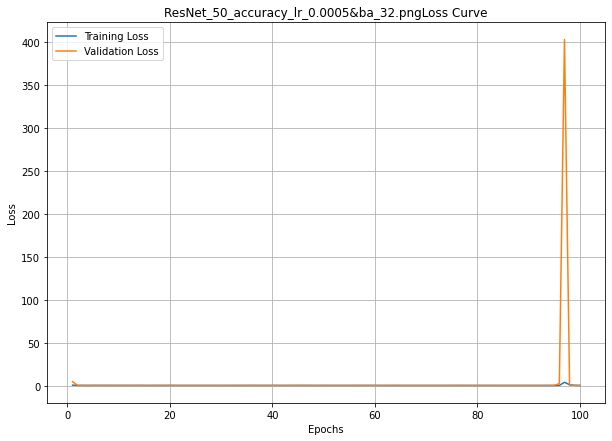

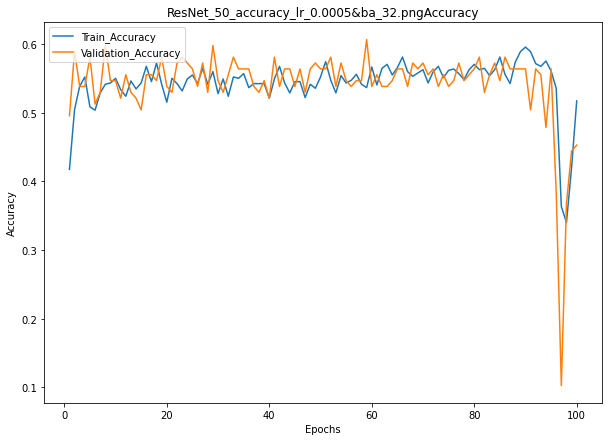

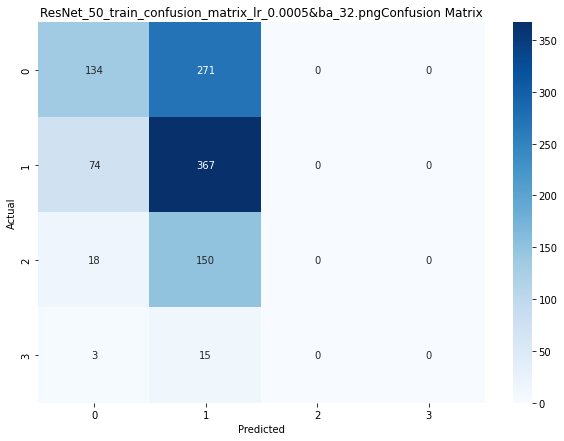

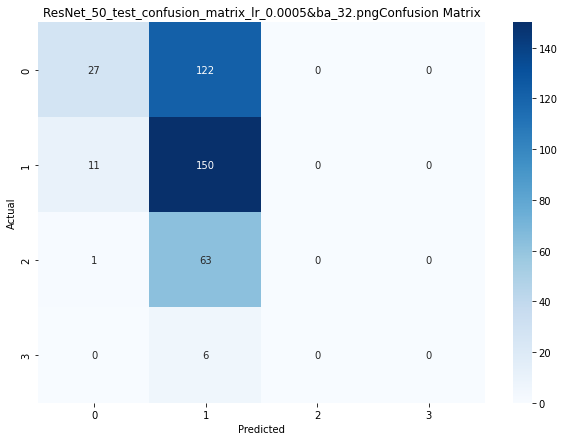

  0%|          | 0/33 [00:00<?, ?it/s]

101


Epoch train [101/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=1.03]


Training Loss: 1.0566
Training Accuracy: 0.5068


Epoch val [101/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.86]


Validation Loss: 1.0693
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

102


Epoch train [102/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.99]


Training Loss: 1.0211
Training Accuracy: 0.5455


Epoch val [102/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.91]


Validation Loss: 1.1349
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

103


Epoch train [103/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=1.00]


Training Loss: 1.0271
Training Accuracy: 0.5388


Epoch val [103/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.91]


Validation Loss: 1.1406
Validation Accuracy: 0.4615


  0%|          | 0/33 [00:00<?, ?it/s]

104


Epoch train [104/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.99]


Training Loss: 1.0240
Training Accuracy: 0.5426


Epoch val [104/100]: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.86]


Validation Loss: 1.0768
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

105


Epoch train [105/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.99]


Training Loss: 1.0201
Training Accuracy: 0.5504


Epoch val [105/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.89]


Validation Loss: 1.1066
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

106


Epoch train [106/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=1.02]


Training Loss: 1.0521
Training Accuracy: 0.5300


Epoch val [106/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.90]


Validation Loss: 1.1311
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

107


Epoch train [107/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=1.00]


Training Loss: 1.0337
Training Accuracy: 0.5397


Epoch val [107/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.90]


Validation Loss: 1.1271
Validation Accuracy: 0.4786


  0%|          | 0/33 [00:00<?, ?it/s]

108


Epoch train [108/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=1.00]


Training Loss: 1.0285
Training Accuracy: 0.5252


Epoch val [108/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.91]


Validation Loss: 1.1370
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

109


Epoch train [109/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.99]


Training Loss: 1.0194
Training Accuracy: 0.5329


Epoch val [109/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.87]


Validation Loss: 1.0851
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

110


Epoch train [110/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.99]


Training Loss: 1.0157
Training Accuracy: 0.5504


Epoch val [110/100]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=0.86]


Validation Loss: 1.0731
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

111


Epoch train [111/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.97]


Training Loss: 1.0012
Training Accuracy: 0.5514


Epoch val [111/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=0.89]


Validation Loss: 1.1115
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

112


Epoch train [112/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.98]


Training Loss: 1.0095
Training Accuracy: 0.5630


Epoch val [112/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.87]


Validation Loss: 1.0843
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

113


Epoch train [113/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.99]


Training Loss: 1.0224
Training Accuracy: 0.5446


Epoch val [113/100]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=0.87]


Validation Loss: 1.0834
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

114


Epoch train [114/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.98]


Training Loss: 1.0095
Training Accuracy: 0.5484


Epoch val [114/100]: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, loss=0.85]


Validation Loss: 1.0634
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

115


Epoch train [115/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.99]


Training Loss: 1.0178
Training Accuracy: 0.5533


Epoch val [115/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.89]


Validation Loss: 1.1151
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

116


Epoch train [116/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=1.01]


Training Loss: 1.0385
Training Accuracy: 0.5455


Epoch val [116/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.86]


Validation Loss: 1.0761
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

117


Epoch train [117/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.98]


Training Loss: 1.0083
Training Accuracy: 0.5514


Epoch val [117/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.86]


Validation Loss: 1.0780
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

118


Epoch train [118/100]: 100%|██████████| 33/33 [00:12<00:00,  2.68it/s, loss=0.98]


Training Loss: 1.0055
Training Accuracy: 0.5446


Epoch val [118/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=0.87]


Validation Loss: 1.0880
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

119


Epoch train [119/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.99]


Training Loss: 1.0173
Training Accuracy: 0.5455


Epoch val [119/100]: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, loss=0.89]


Validation Loss: 1.1079
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

120


Epoch train [120/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.98]


Training Loss: 1.0132
Training Accuracy: 0.5465


Epoch val [120/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.88]


Validation Loss: 1.0951
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

121


Epoch train [121/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.96]


Training Loss: 0.9909
Training Accuracy: 0.5756


Epoch val [121/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.85]


Validation Loss: 1.0601
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

122


Epoch train [122/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.97]


Training Loss: 0.9992
Training Accuracy: 0.5543


Epoch val [122/100]: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.86]


Validation Loss: 1.0791
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

123


Epoch train [123/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.98]


Training Loss: 1.0065
Training Accuracy: 0.5475


Epoch val [123/100]: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.85]


Validation Loss: 1.0641
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

124


Epoch train [124/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.96]


Training Loss: 0.9906
Training Accuracy: 0.5707


Epoch val [124/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.86]


Validation Loss: 1.0799
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

125


Epoch train [125/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.98]


Training Loss: 1.0067
Training Accuracy: 0.5523


Epoch val [125/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.89]


Validation Loss: 1.1154
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

126


Epoch train [126/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.98]


Training Loss: 1.0104
Training Accuracy: 0.5543


Epoch val [126/100]: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, loss=0.91]


Validation Loss: 1.1431
Validation Accuracy: 0.5043


  0%|          | 0/33 [00:00<?, ?it/s]

127


Epoch train [127/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.97]


Training Loss: 0.9982
Training Accuracy: 0.5591


Epoch val [127/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.87]


Validation Loss: 1.0932
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

128


Epoch train [128/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.98]


Training Loss: 1.0051
Training Accuracy: 0.5543


Epoch val [128/100]: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, loss=0.88]


Validation Loss: 1.0960
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

129


Epoch train [129/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.98]


Training Loss: 1.0113
Training Accuracy: 0.5465


Epoch val [129/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=0.88]


Validation Loss: 1.0953
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

130


Epoch train [130/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.98]


Training Loss: 1.0141
Training Accuracy: 0.5407


Epoch val [130/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.88]


Validation Loss: 1.1034
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

131


Epoch train [131/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.98]


Training Loss: 1.0049
Training Accuracy: 0.5475


Epoch val [131/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.86]


Validation Loss: 1.0779
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

132


Epoch train [132/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.98]


Training Loss: 1.0072
Training Accuracy: 0.5455


Epoch val [132/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.88]


Validation Loss: 1.0966
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

133


Epoch train [133/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.97]


Training Loss: 0.9961
Training Accuracy: 0.5407


Epoch val [133/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.89]


Validation Loss: 1.1146
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

134


Epoch train [134/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.97]


Training Loss: 1.0028
Training Accuracy: 0.5397


Epoch val [134/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.86]


Validation Loss: 1.0789
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

135


Epoch train [135/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=1.00]


Training Loss: 1.0287
Training Accuracy: 0.5417


Epoch val [135/100]: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, loss=0.88]


Validation Loss: 1.0983
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

136


Epoch train [136/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.98]


Training Loss: 1.0064
Training Accuracy: 0.5523


Epoch val [136/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.86]


Validation Loss: 1.0761
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

137


Epoch train [137/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.98]


Training Loss: 1.0055
Training Accuracy: 0.5533


Epoch val [137/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.88]


Validation Loss: 1.0954
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

138


Epoch train [138/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.98]


Training Loss: 1.0105
Training Accuracy: 0.5397


Epoch val [138/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.88]


Validation Loss: 1.0943
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

139


Epoch train [139/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.99]


Training Loss: 1.0207
Training Accuracy: 0.5407


Epoch val [139/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=0.86]


Validation Loss: 1.0699
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

140


Epoch train [140/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.97]


Training Loss: 0.9986
Training Accuracy: 0.5475


Epoch val [140/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.89]


Validation Loss: 1.1186
Validation Accuracy: 0.5128


  0%|          | 0/33 [00:00<?, ?it/s]

141


Epoch train [141/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.96]


Training Loss: 0.9939
Training Accuracy: 0.5659


Epoch val [141/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.86]


Validation Loss: 1.0738
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

142


Epoch train [142/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.99]


Training Loss: 1.0195
Training Accuracy: 0.5601


Epoch val [142/100]: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.89]


Validation Loss: 1.1146
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

143


Epoch train [143/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.96]


Training Loss: 0.9929
Training Accuracy: 0.5494


Epoch val [143/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.86]


Validation Loss: 1.0769
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

144


Epoch train [144/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.96]


Training Loss: 0.9923
Training Accuracy: 0.5640


Epoch val [144/100]: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.89]


Validation Loss: 1.1108
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

145


Epoch train [145/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.97]


Training Loss: 0.9976
Training Accuracy: 0.5804


Epoch val [145/100]: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s, loss=0.86]


Validation Loss: 1.0799
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

146


Epoch train [146/100]: 100%|██████████| 33/33 [00:12<00:00,  2.66it/s, loss=0.98]


Training Loss: 1.0102
Training Accuracy: 0.5698


Epoch val [146/100]: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s, loss=0.89]


Validation Loss: 1.1156
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

147


Epoch train [147/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.98]


Training Loss: 1.0103
Training Accuracy: 0.5378


Epoch val [147/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.86]


Validation Loss: 1.0696
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

148


Epoch train [148/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.99]


Training Loss: 1.0167
Training Accuracy: 0.5533


Epoch val [148/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.87]


Validation Loss: 1.0933
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

149


Epoch train [149/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.99]


Training Loss: 1.0181
Training Accuracy: 0.5242


Epoch val [149/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.88]


Validation Loss: 1.0997
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

150


Epoch train [150/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.98]


Training Loss: 1.0144
Training Accuracy: 0.5436


Epoch val [150/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.86]


Validation Loss: 1.0698
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

151


Epoch train [151/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.96]


Training Loss: 0.9920
Training Accuracy: 0.5640


Epoch val [151/100]: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.86]


Validation Loss: 1.0728
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

152


Epoch train [152/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.97]


Training Loss: 0.9956
Training Accuracy: 0.5417


Epoch val [152/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=0.86]


Validation Loss: 1.0741
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

153


Epoch train [153/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.98]


Training Loss: 1.0085
Training Accuracy: 0.5368


Epoch val [153/100]: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.88]


Validation Loss: 1.0975
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

154


Epoch train [154/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.96]


Training Loss: 0.9914
Training Accuracy: 0.5727


Epoch val [154/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.89]


Validation Loss: 1.1126
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

155


Epoch train [155/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.98]


Training Loss: 1.0047
Training Accuracy: 0.5533


Epoch val [155/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=0.87]


Validation Loss: 1.0891
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

156


Epoch train [156/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.97]


Training Loss: 0.9979
Training Accuracy: 0.5581


Epoch val [156/100]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=0.85]


Validation Loss: 1.0676
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

157


Epoch train [157/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.98]


Training Loss: 1.0085
Training Accuracy: 0.5649


Epoch val [157/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.86]


Validation Loss: 1.0800
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

158


Epoch train [158/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.98]


Training Loss: 1.0071
Training Accuracy: 0.5446


Epoch val [158/100]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s, loss=0.87]


Validation Loss: 1.0844
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

159


Epoch train [159/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.97]


Training Loss: 0.9981
Training Accuracy: 0.5504


Epoch val [159/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.89]


Validation Loss: 1.1150
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

160


Epoch train [160/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.99]


Training Loss: 1.0195
Training Accuracy: 0.5368


Epoch val [160/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.87]


Validation Loss: 1.0873
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

161


Epoch train [161/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.96]


Training Loss: 0.9882
Training Accuracy: 0.5455


Epoch val [161/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.88]


Validation Loss: 1.1060
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

162


Epoch train [162/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.97]


Training Loss: 1.0021
Training Accuracy: 0.5562


Epoch val [162/100]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=0.93]


Validation Loss: 1.1630
Validation Accuracy: 0.5043


  0%|          | 0/33 [00:00<?, ?it/s]

163


Epoch train [163/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=1.00]


Training Loss: 1.0264
Training Accuracy: 0.5349


Epoch val [163/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.91]


Validation Loss: 1.1435
Validation Accuracy: 0.4957


  0%|          | 0/33 [00:00<?, ?it/s]

164


Epoch train [164/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.98]


Training Loss: 1.0143
Training Accuracy: 0.5572


Epoch val [164/100]: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.86]


Validation Loss: 1.0752
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

165


Epoch train [165/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.97]


Training Loss: 0.9993
Training Accuracy: 0.5562


Epoch val [165/100]: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=0.97]


Validation Loss: 1.2079
Validation Accuracy: 0.4444


  0%|          | 0/33 [00:00<?, ?it/s]

166


Epoch train [166/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.99]


Training Loss: 1.0223
Training Accuracy: 0.5349


Epoch val [166/100]: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.86]


Validation Loss: 1.0725
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

167


Epoch train [167/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.98]


Training Loss: 1.0103
Training Accuracy: 0.5349


Epoch val [167/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=0.88]


Validation Loss: 1.1041
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

168


Epoch train [168/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.97]


Training Loss: 1.0006
Training Accuracy: 0.5610


Epoch val [168/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.88]


Validation Loss: 1.1033
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

169


Epoch train [169/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.97]


Training Loss: 1.0040
Training Accuracy: 0.5475


Epoch val [169/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.88]


Validation Loss: 1.0969
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

170


Epoch train [170/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.96]


Training Loss: 0.9923
Training Accuracy: 0.5523


Epoch val [170/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.91]


Validation Loss: 1.1323
Validation Accuracy: 0.4786


  0%|          | 0/33 [00:00<?, ?it/s]

171


Epoch train [171/100]: 100%|██████████| 33/33 [00:12<00:00,  2.60it/s, loss=0.98]


Training Loss: 1.0049
Training Accuracy: 0.5397


Epoch val [171/100]: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s, loss=0.87]


Validation Loss: 1.0892
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

172


Epoch train [172/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.96]


Training Loss: 0.9842
Training Accuracy: 0.5678


Epoch val [172/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.88]


Validation Loss: 1.0961
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

173


Epoch train [173/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.97]


Training Loss: 1.0001
Training Accuracy: 0.5669


Epoch val [173/100]: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s, loss=0.88]


Validation Loss: 1.1056
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

174


Epoch train [174/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.97]


Training Loss: 0.9998
Training Accuracy: 0.5504


Epoch val [174/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.91]


Validation Loss: 1.1353
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

175


Epoch train [175/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.97]


Training Loss: 1.0039
Training Accuracy: 0.5514


Epoch val [175/100]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=0.87]


Validation Loss: 1.0921
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

176


Epoch train [176/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.98]


Training Loss: 1.0144
Training Accuracy: 0.5659


Epoch val [176/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.85]


Validation Loss: 1.0682
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

177


Epoch train [177/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.98]


Training Loss: 1.0078
Training Accuracy: 0.5494


Epoch val [177/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=0.88]


Validation Loss: 1.1020
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

178


Epoch train [178/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.97]


Training Loss: 0.9997
Training Accuracy: 0.5407


Epoch val [178/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.90]


Validation Loss: 1.1271
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

179


Epoch train [179/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.98]


Training Loss: 1.0050
Training Accuracy: 0.5552


Epoch val [179/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.87]


Validation Loss: 1.0896
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

180


Epoch train [180/100]: 100%|██████████| 33/33 [00:12<00:00,  2.68it/s, loss=0.96]


Training Loss: 0.9932
Training Accuracy: 0.5562


Epoch val [180/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.88]


Validation Loss: 1.0951
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

181


Epoch train [181/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.97]


Training Loss: 1.0015
Training Accuracy: 0.5523


Epoch val [181/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.86]


Validation Loss: 1.0787
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

182


Epoch train [182/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.99]


Training Loss: 1.0205
Training Accuracy: 0.5659


Epoch val [182/100]: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, loss=0.87]


Validation Loss: 1.0880
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

183


Epoch train [183/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.97]


Training Loss: 1.0002
Training Accuracy: 0.5494


Epoch val [183/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=0.89]


Validation Loss: 1.1103
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

184


Epoch train [184/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.98]


Training Loss: 1.0134
Training Accuracy: 0.5484


Epoch val [184/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.86]


Validation Loss: 1.0738
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

185


Epoch train [185/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.97]


Training Loss: 1.0002
Training Accuracy: 0.5465


Epoch val [185/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.90]


Validation Loss: 1.1308
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

186


Epoch train [186/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.96]


Training Loss: 0.9900
Training Accuracy: 0.5649


Epoch val [186/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.87]


Validation Loss: 1.0824
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

187


Epoch train [187/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.96]


Training Loss: 0.9873
Training Accuracy: 0.5669


Epoch val [187/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.85]


Validation Loss: 1.0649
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

188


Epoch train [188/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.97]


Training Loss: 0.9997
Training Accuracy: 0.5649


Epoch val [188/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.89]


Validation Loss: 1.1164
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

189


Epoch train [189/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.99]


Training Loss: 1.0172
Training Accuracy: 0.5620


Epoch val [189/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.85]


Validation Loss: 1.0605
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

190


Epoch train [190/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.96]


Training Loss: 0.9865
Training Accuracy: 0.5523


Epoch val [190/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.87]


Validation Loss: 1.0867
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

191


Epoch train [191/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.97]


Training Loss: 1.0034
Training Accuracy: 0.5552


Epoch val [191/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=0.86]


Validation Loss: 1.0765
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

192


Epoch train [192/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.96]


Training Loss: 0.9845
Training Accuracy: 0.5601


Epoch val [192/100]: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s, loss=0.88]


Validation Loss: 1.1019
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

193


Epoch train [193/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.98]


Training Loss: 1.0132
Training Accuracy: 0.5552


Epoch val [193/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=0.88]


Validation Loss: 1.0941
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

194


Epoch train [194/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.96]


Training Loss: 0.9875
Training Accuracy: 0.5620


Epoch val [194/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=0.86]


Validation Loss: 1.0709
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

195


Epoch train [195/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.95]


Training Loss: 0.9828
Training Accuracy: 0.5756


Epoch val [195/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.87]


Validation Loss: 1.0863
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

196


Epoch train [196/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.98]


Training Loss: 1.0079
Training Accuracy: 0.5640


Epoch val [196/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.87]


Validation Loss: 1.0823
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

197


Epoch train [197/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.93]


Training Loss: 0.9596
Training Accuracy: 0.5795


Epoch val [197/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=0.92]


Validation Loss: 1.1475
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

198


Epoch train [198/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.97]


Training Loss: 1.0025
Training Accuracy: 0.5572


Epoch val [198/100]: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, loss=0.86]


Validation Loss: 1.0738
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

199


Epoch train [199/100]: 100%|██████████| 33/33 [00:12<00:00,  2.63it/s, loss=0.95]


Training Loss: 0.9797
Training Accuracy: 0.5785


Epoch val [199/100]: 100%|██████████| 4/4 [00:00<00:00,  5.62it/s, loss=0.86]


Validation Loss: 1.0809
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

200


Epoch train [200/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.97]


Training Loss: 0.9977
Training Accuracy: 0.5610


Epoch val [200/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.90]


Validation Loss: 1.1234
Validation Accuracy: 0.5385


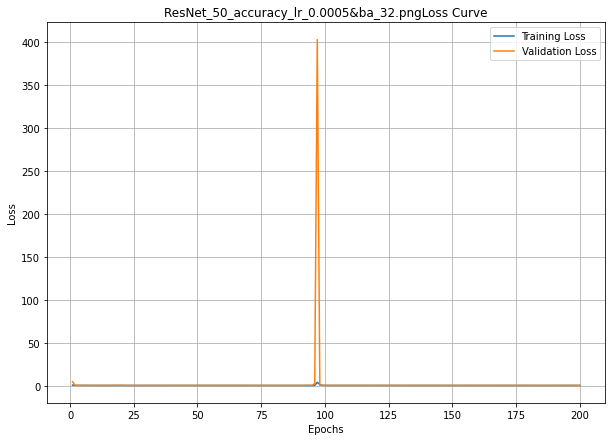

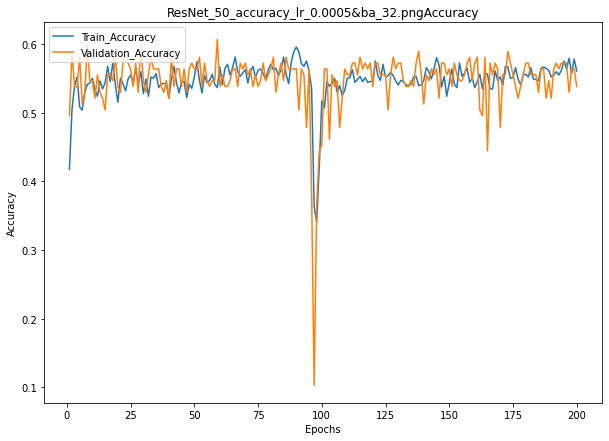

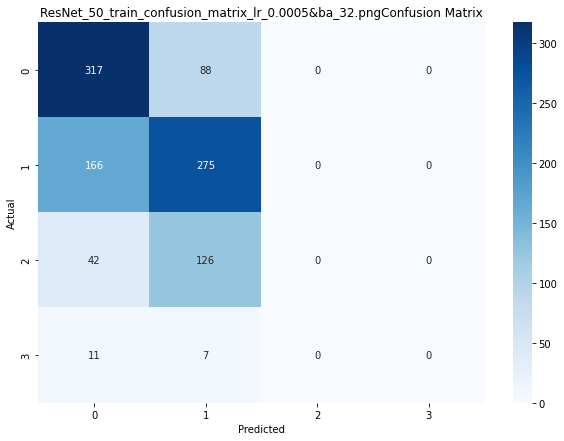

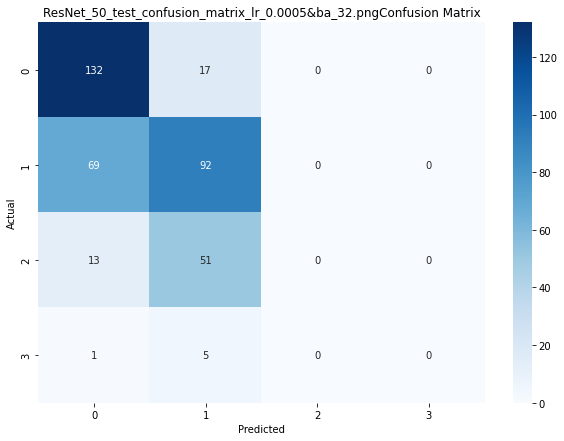

  0%|          | 0/33 [00:00<?, ?it/s]

201


Epoch train [201/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.97]


Training Loss: 1.0026
Training Accuracy: 0.5504


Epoch val [201/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=0.88]


Validation Loss: 1.0958
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

202


Epoch train [202/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.94]


Training Loss: 0.9724
Training Accuracy: 0.5659


Epoch val [202/100]: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s, loss=0.87]


Validation Loss: 1.0919
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

203


Epoch train [203/100]: 100%|██████████| 33/33 [00:12<00:00,  2.68it/s, loss=0.96]


Training Loss: 0.9918
Training Accuracy: 0.5698


Epoch val [203/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.86]


Validation Loss: 1.0794
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

204


Epoch train [204/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.97]


Training Loss: 0.9959
Training Accuracy: 0.5746


Epoch val [204/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.85]


Validation Loss: 1.0624
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

205


Epoch train [205/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.97]


Training Loss: 0.9955
Training Accuracy: 0.5698


Epoch val [205/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=0.87]


Validation Loss: 1.0826
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

206


Epoch train [206/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.96]


Training Loss: 0.9842
Training Accuracy: 0.5649


Epoch val [206/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.86]


Validation Loss: 1.0729
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

207


Epoch train [207/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.96]


Training Loss: 0.9889
Training Accuracy: 0.5785


Epoch val [207/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.90]


Validation Loss: 1.1289
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

208


Epoch train [208/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.96]


Training Loss: 0.9842
Training Accuracy: 0.5727


Epoch val [208/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=0.87]


Validation Loss: 1.0854
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

209


Epoch train [209/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.96]


Training Loss: 0.9937
Training Accuracy: 0.5640


Epoch val [209/100]: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.87]


Validation Loss: 1.0920
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

210


Epoch train [210/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.95]


Training Loss: 0.9838
Training Accuracy: 0.5707


Epoch val [210/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.85]


Validation Loss: 1.0586
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

211


Epoch train [211/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.96]


Training Loss: 0.9869
Training Accuracy: 0.5736


Epoch val [211/100]: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s, loss=0.90]


Validation Loss: 1.1207
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

212


Epoch train [212/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.96]


Training Loss: 0.9912
Training Accuracy: 0.5707


Epoch val [212/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.87]


Validation Loss: 1.0846
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

213


Epoch train [213/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.96]


Training Loss: 0.9902
Training Accuracy: 0.5426


Epoch val [213/100]: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s, loss=0.85]


Validation Loss: 1.0673
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

214


Epoch train [214/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.95]


Training Loss: 0.9792
Training Accuracy: 0.5707


Epoch val [214/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.90]


Validation Loss: 1.1245
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

215


Epoch train [215/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.98]


Training Loss: 1.0078
Training Accuracy: 0.5494


Epoch val [215/100]: 100%|██████████| 4/4 [00:00<00:00,  5.77it/s, loss=0.89]


Validation Loss: 1.1072
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

216


Epoch train [216/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.95]


Training Loss: 0.9818
Training Accuracy: 0.5930


Epoch val [216/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=0.88]


Validation Loss: 1.0998
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

217


Epoch train [217/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.98]


Training Loss: 1.0138
Training Accuracy: 0.5475


Epoch val [217/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.87]


Validation Loss: 1.0813
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

218


Epoch train [218/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.96]


Training Loss: 0.9938
Training Accuracy: 0.5543


Epoch val [218/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.84]


Validation Loss: 1.0553
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

219


Epoch train [219/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.97]


Training Loss: 1.0039
Training Accuracy: 0.5659


Epoch val [219/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.85]


Validation Loss: 1.0621
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

220


Epoch train [220/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.97]


Training Loss: 1.0012
Training Accuracy: 0.5640


Epoch val [220/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.86]


Validation Loss: 1.0808
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

221


Epoch train [221/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.96]


Training Loss: 0.9869
Training Accuracy: 0.5736


Epoch val [221/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.89]


Validation Loss: 1.1071
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

222


Epoch train [222/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.95]


Training Loss: 0.9838
Training Accuracy: 0.5795


Epoch val [222/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.84]


Validation Loss: 1.0522
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

223


Epoch train [223/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.96]


Training Loss: 0.9907
Training Accuracy: 0.5756


Epoch val [223/100]: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, loss=0.83]


Validation Loss: 1.0435
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

224


Epoch train [224/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.95]


Training Loss: 0.9818
Training Accuracy: 0.5562


Epoch val [224/100]: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s, loss=0.89]


Validation Loss: 1.1163
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

225


Epoch train [225/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.95]


Training Loss: 0.9785
Training Accuracy: 0.5698


Epoch val [225/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.87]


Validation Loss: 1.0872
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

226


Epoch train [226/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.96]


Training Loss: 0.9938
Training Accuracy: 0.5659


Epoch val [226/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.87]


Validation Loss: 1.0840
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

227


Epoch train [227/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.96]


Training Loss: 0.9913
Training Accuracy: 0.5572


Epoch val [227/100]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss=0.85]


Validation Loss: 1.0661
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

228


Epoch train [228/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.96]


Training Loss: 0.9848
Training Accuracy: 0.5727


Epoch val [228/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.88]


Validation Loss: 1.1000
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

229


Epoch train [229/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.95]


Training Loss: 0.9788
Training Accuracy: 0.5717


Epoch val [229/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.85]


Validation Loss: 1.0627
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

230


Epoch train [230/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.95]


Training Loss: 0.9738
Training Accuracy: 0.5640


Epoch val [230/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=0.88]


Validation Loss: 1.0978
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

231


Epoch train [231/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.97]


Training Loss: 0.9951
Training Accuracy: 0.5669


Epoch val [231/100]: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.85]


Validation Loss: 1.0628
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

232


Epoch train [232/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.95]


Training Loss: 0.9833
Training Accuracy: 0.5688


Epoch val [232/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.89]


Validation Loss: 1.1142
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

233


Epoch train [233/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.97]


Training Loss: 0.9962
Training Accuracy: 0.5504


Epoch val [233/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.87]


Validation Loss: 1.0915
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

234


Epoch train [234/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.93]


Training Loss: 0.9570
Training Accuracy: 0.5717


Epoch val [234/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.84]


Validation Loss: 1.0491
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

235


Epoch train [235/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.96]


Training Loss: 0.9859
Training Accuracy: 0.5814


Epoch val [235/100]: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s, loss=0.88]


Validation Loss: 1.0993
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

236


Epoch train [236/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.94]


Training Loss: 0.9651
Training Accuracy: 0.5833


Epoch val [236/100]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.89]


Validation Loss: 1.1084
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

237


Epoch train [237/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.99]


Training Loss: 1.0204
Training Accuracy: 0.5233


Epoch val [237/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.89]


Validation Loss: 1.1079
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

238


Epoch train [238/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.96]


Training Loss: 0.9884
Training Accuracy: 0.5746


Epoch val [238/100]: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.85]


Validation Loss: 1.0583
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

239


Epoch train [239/100]: 100%|██████████| 33/33 [00:12<00:00,  2.54it/s, loss=0.96]


Training Loss: 0.9858
Training Accuracy: 0.5688


Epoch val [239/100]: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s, loss=0.86]


Validation Loss: 1.0787
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

240


Epoch train [240/100]: 100%|██████████| 33/33 [00:12<00:00,  2.57it/s, loss=0.97]


Training Loss: 0.9999
Training Accuracy: 0.5552


Epoch val [240/100]: 100%|██████████| 4/4 [00:00<00:00,  5.80it/s, loss=0.88]


Validation Loss: 1.0946
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

241


Epoch train [241/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.94]


Training Loss: 0.9702
Training Accuracy: 0.5891


Epoch val [241/100]: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.85]


Validation Loss: 1.0663
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

242


Epoch train [242/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.96]


Training Loss: 0.9877
Training Accuracy: 0.5678


Epoch val [242/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=0.87]


Validation Loss: 1.0910
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

243


Epoch train [243/100]: 100%|██████████| 33/33 [00:12<00:00,  2.65it/s, loss=0.94]


Training Loss: 0.9666
Training Accuracy: 0.5872


Epoch val [243/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.86]


Validation Loss: 1.0715
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

244


Epoch train [244/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.94]


Training Loss: 0.9728
Training Accuracy: 0.5736


Epoch val [244/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.88]


Validation Loss: 1.0973
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

245


Epoch train [245/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.94]


Training Loss: 0.9695
Training Accuracy: 0.5853


Epoch val [245/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.90]


Validation Loss: 1.1231
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

246


Epoch train [246/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.94]


Training Loss: 0.9701
Training Accuracy: 0.5824


Epoch val [246/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.84]


Validation Loss: 1.0464
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

247


Epoch train [247/100]: 100%|██████████| 33/33 [00:12<00:00,  2.57it/s, loss=0.94]


Training Loss: 0.9735
Training Accuracy: 0.5824


Epoch val [247/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.91]


Validation Loss: 1.1347
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

248


Epoch train [248/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.94]


Training Loss: 0.9687
Training Accuracy: 0.5698


Epoch val [248/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=0.84]


Validation Loss: 1.0511
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

249


Epoch train [249/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.96]


Training Loss: 0.9849
Training Accuracy: 0.5785


Epoch val [249/100]: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, loss=0.88]


Validation Loss: 1.1062
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

250


Epoch train [250/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.95]


Training Loss: 0.9816
Training Accuracy: 0.5766


Epoch val [250/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.88]


Validation Loss: 1.1006
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

251


Epoch train [251/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.98]


Training Loss: 1.0059
Training Accuracy: 0.5736


Epoch val [251/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.89]


Validation Loss: 1.1185
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

252


Epoch train [252/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.97]


Training Loss: 0.9974
Training Accuracy: 0.5785


Epoch val [252/100]: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.85]


Validation Loss: 1.0575
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

253


Epoch train [253/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.96]


Training Loss: 0.9858
Training Accuracy: 0.5659


Epoch val [253/100]: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.89]


Validation Loss: 1.1137
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

254


Epoch train [254/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.95]


Training Loss: 0.9826
Training Accuracy: 0.5746


Epoch val [254/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.85]


Validation Loss: 1.0629
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

255


Epoch train [255/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.91]


Training Loss: 0.9418
Training Accuracy: 0.5853


Epoch val [255/100]: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s, loss=0.92]


Validation Loss: 1.1468
Validation Accuracy: 0.5128


  0%|          | 0/33 [00:00<?, ?it/s]

256


Epoch train [256/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.96]


Training Loss: 0.9933
Training Accuracy: 0.5514


Epoch val [256/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.84]


Validation Loss: 1.0521
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

257


Epoch train [257/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.95]


Training Loss: 0.9821
Training Accuracy: 0.5504


Epoch val [257/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.84]


Validation Loss: 1.0450
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

258


Epoch train [258/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.93]


Training Loss: 0.9594
Training Accuracy: 0.5882


Epoch val [258/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.87]


Validation Loss: 1.0829
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

259


Epoch train [259/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.94]


Training Loss: 0.9680
Training Accuracy: 0.5775


Epoch val [259/100]: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, loss=0.85]


Validation Loss: 1.0637
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

260


Epoch train [260/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.93]


Training Loss: 0.9619
Training Accuracy: 0.5853


Epoch val [260/100]: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s, loss=0.83]


Validation Loss: 1.0369
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

261


Epoch train [261/100]: 100%|██████████| 33/33 [00:12<00:00,  2.66it/s, loss=0.95]


Training Loss: 0.9786
Training Accuracy: 0.5804


Epoch val [261/100]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=0.85]


Validation Loss: 1.0599
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

262


Epoch train [262/100]: 100%|██████████| 33/33 [00:12<00:00,  2.60it/s, loss=0.93]


Training Loss: 0.9593
Training Accuracy: 0.5824


Epoch val [262/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.88]


Validation Loss: 1.0948
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

263


Epoch train [263/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.94]


Training Loss: 0.9712
Training Accuracy: 0.5882


Epoch val [263/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.88]


Validation Loss: 1.1030
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

264


Epoch train [264/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.96]


Training Loss: 0.9875
Training Accuracy: 0.5756


Epoch val [264/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=0.86]


Validation Loss: 1.0737
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

265


Epoch train [265/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.95]


Training Loss: 0.9829
Training Accuracy: 0.5921


Epoch val [265/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.84]


Validation Loss: 1.0511
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

266


Epoch train [266/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.93]


Training Loss: 0.9550
Training Accuracy: 0.5862


Epoch val [266/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.88]


Validation Loss: 1.0967
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

267


Epoch train [267/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.94]


Training Loss: 0.9668
Training Accuracy: 0.5707


Epoch val [267/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.86]


Validation Loss: 1.0754
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

268


Epoch train [268/100]: 100%|██████████| 33/33 [00:12<00:00,  2.68it/s, loss=0.95]


Training Loss: 0.9830
Training Accuracy: 0.5756


Epoch val [268/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.85]


Validation Loss: 1.0686
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

269


Epoch train [269/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.94]


Training Loss: 0.9636
Training Accuracy: 0.5853


Epoch val [269/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.87]


Validation Loss: 1.0815
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

270


Epoch train [270/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.93]


Training Loss: 0.9599
Training Accuracy: 0.5640


Epoch val [270/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.84]


Validation Loss: 1.0442
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

271


Epoch train [271/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.95]


Training Loss: 0.9769
Training Accuracy: 0.5630


Epoch val [271/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=0.85]


Validation Loss: 1.0632
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

272


Epoch train [272/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.94]


Training Loss: 0.9692
Training Accuracy: 0.5785


Epoch val [272/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.92]


Validation Loss: 1.1449
Validation Accuracy: 0.5128


  0%|          | 0/33 [00:00<?, ?it/s]

273


Epoch train [273/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.95]


Training Loss: 0.9825
Training Accuracy: 0.5824


Epoch val [273/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=0.85]


Validation Loss: 1.0574
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

274


Epoch train [274/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.96]


Training Loss: 0.9863
Training Accuracy: 0.5833


Epoch val [274/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=0.84]


Validation Loss: 1.0476
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

275


Epoch train [275/100]: 100%|██████████| 33/33 [00:12<00:00,  2.68it/s, loss=0.94]


Training Loss: 0.9659
Training Accuracy: 0.5843


Epoch val [275/100]: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, loss=0.87]


Validation Loss: 1.0815
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

276


Epoch train [276/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.94]


Training Loss: 0.9650
Training Accuracy: 0.5756


Epoch val [276/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.90]


Validation Loss: 1.1206
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

277


Epoch train [277/100]: 100%|██████████| 33/33 [00:12<00:00,  2.64it/s, loss=0.95]


Training Loss: 0.9838
Training Accuracy: 0.5891


Epoch val [277/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.84]


Validation Loss: 1.0505
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

278


Epoch train [278/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.94]


Training Loss: 0.9694
Training Accuracy: 0.5736


Epoch val [278/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.90]


Validation Loss: 1.1242
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

279


Epoch train [279/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.95]


Training Loss: 0.9768
Training Accuracy: 0.5862


Epoch val [279/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.83]


Validation Loss: 1.0377
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

280


Epoch train [280/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.96]


Training Loss: 0.9855
Training Accuracy: 0.5814


Epoch val [280/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.86]


Validation Loss: 1.0775
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

281


Epoch train [281/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.93]


Training Loss: 0.9543
Training Accuracy: 0.5950


Epoch val [281/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=0.84]


Validation Loss: 1.0469
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

282


Epoch train [282/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.94]


Training Loss: 0.9634
Training Accuracy: 0.5950


Epoch val [282/100]: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.86]


Validation Loss: 1.0736
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

283


Epoch train [283/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.94]


Training Loss: 0.9638
Training Accuracy: 0.5804


Epoch val [283/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=0.86]


Validation Loss: 1.0787
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

284


Epoch train [284/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.95]


Training Loss: 0.9740
Training Accuracy: 0.5766


Epoch val [284/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.81]


Validation Loss: 1.0120
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

285


Epoch train [285/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.94]


Training Loss: 0.9675
Training Accuracy: 0.5901


Epoch val [285/100]: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.84]


Validation Loss: 1.0456
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

286


Epoch train [286/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.93]


Training Loss: 0.9551
Training Accuracy: 0.5775


Epoch val [286/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.84]


Validation Loss: 1.0454
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

287


Epoch train [287/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.93]


Training Loss: 0.9624
Training Accuracy: 0.5872


Epoch val [287/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.86]


Validation Loss: 1.0760
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

288


Epoch train [288/100]: 100%|██████████| 33/33 [00:12<00:00,  2.65it/s, loss=0.94]


Training Loss: 0.9662
Training Accuracy: 0.5862


Epoch val [288/100]: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s, loss=0.86]


Validation Loss: 1.0722
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

289


Epoch train [289/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.92]


Training Loss: 0.9450
Training Accuracy: 0.5921


Epoch val [289/100]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.83]


Validation Loss: 1.0357
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

290


Epoch train [290/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.92]


Training Loss: 0.9524
Training Accuracy: 0.5891


Epoch val [290/100]: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s, loss=0.87]


Validation Loss: 1.0885
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

291


Epoch train [291/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.92]


Training Loss: 0.9511
Training Accuracy: 0.5891


Epoch val [291/100]: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.84]


Validation Loss: 1.0443
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

292


Epoch train [292/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.91]


Training Loss: 0.9380
Training Accuracy: 0.5891


Epoch val [292/100]: 100%|██████████| 4/4 [00:00<00:00,  5.80it/s, loss=0.87]


Validation Loss: 1.0867
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

293


Epoch train [293/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.92]


Training Loss: 0.9446
Training Accuracy: 0.5824


Epoch val [293/100]: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.84]


Validation Loss: 1.0472
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

294


Epoch train [294/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.93]


Training Loss: 0.9597
Training Accuracy: 0.5882


Epoch val [294/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=0.85]


Validation Loss: 1.0569
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

295


Epoch train [295/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.91]


Training Loss: 0.9403
Training Accuracy: 0.5814


Epoch val [295/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.86]


Validation Loss: 1.0779
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

296


Epoch train [296/100]: 100%|██████████| 33/33 [00:12<00:00,  2.65it/s, loss=0.92]


Training Loss: 0.9524
Training Accuracy: 0.5969


Epoch val [296/100]: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s, loss=0.86]


Validation Loss: 1.0786
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

297


Epoch train [297/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.93]


Training Loss: 0.9564
Training Accuracy: 0.5950


Epoch val [297/100]: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, loss=0.83]


Validation Loss: 1.0328
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

298


Epoch train [298/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.94]


Training Loss: 0.9652
Training Accuracy: 0.5824


Epoch val [298/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.90]


Validation Loss: 1.1205
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

299


Epoch train [299/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.91]


Training Loss: 0.9393
Training Accuracy: 0.5940


Epoch val [299/100]: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.88]


Validation Loss: 1.1010
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

300


Epoch train [300/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.91]


Training Loss: 0.9361
Training Accuracy: 0.5979


Epoch val [300/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.83]


Validation Loss: 1.0423
Validation Accuracy: 0.5812


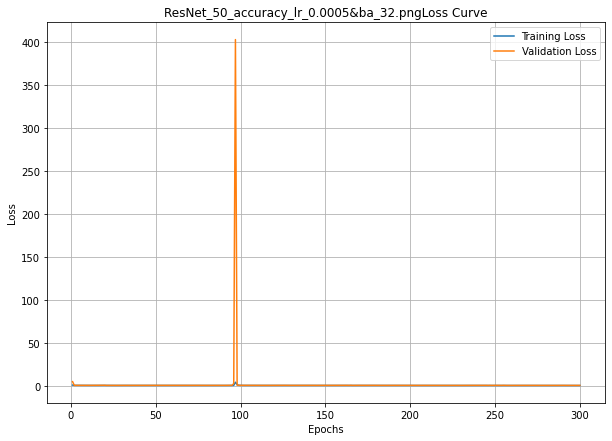

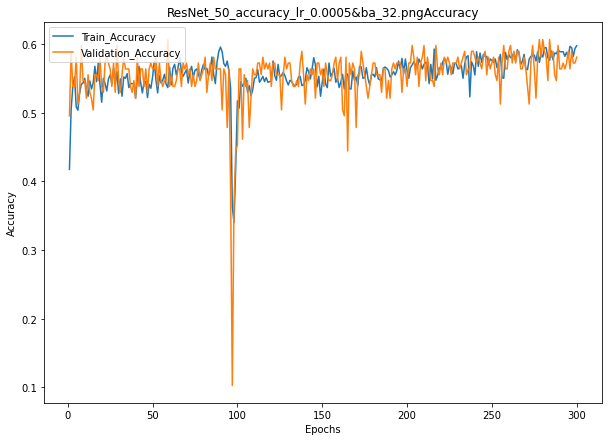

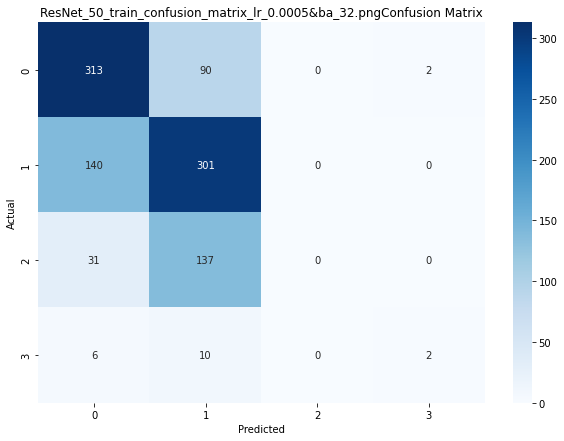

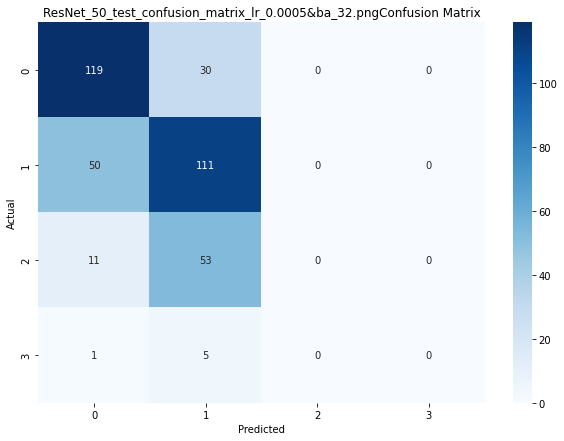

  0%|          | 0/33 [00:00<?, ?it/s]

301


Epoch train [301/100]: 100%|██████████| 33/33 [00:12<00:00,  2.59it/s, loss=0.92]


Training Loss: 0.9490
Training Accuracy: 0.5688


Epoch val [301/100]: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s, loss=0.83]


Validation Loss: 1.0404
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

302


Epoch train [302/100]: 100%|██████████| 33/33 [00:12<00:00,  2.59it/s, loss=0.91]


Training Loss: 0.9372
Training Accuracy: 0.6105


Epoch val [302/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.81]


Validation Loss: 1.0166
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

303


Epoch train [303/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.92]


Training Loss: 0.9483
Training Accuracy: 0.5833


Epoch val [303/100]: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.84]


Validation Loss: 1.0545
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

304


Epoch train [304/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.93]


Training Loss: 0.9598
Training Accuracy: 0.5930


Epoch val [304/100]: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, loss=0.83]


Validation Loss: 1.0409
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

305


Epoch train [305/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.90]


Training Loss: 0.9288
Training Accuracy: 0.6017


Epoch val [305/100]: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.82]


Validation Loss: 1.0289
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

306


Epoch train [306/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.92]


Training Loss: 0.9432
Training Accuracy: 0.5804


Epoch val [306/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.85]


Validation Loss: 1.0605
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

307


Epoch train [307/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.91]


Training Loss: 0.9414
Training Accuracy: 0.6008


Epoch val [307/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.85]


Validation Loss: 1.0629
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

308


Epoch train [308/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.94]


Training Loss: 0.9668
Training Accuracy: 0.5814


Epoch val [308/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.84]


Validation Loss: 1.0469
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

309


Epoch train [309/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.92]


Training Loss: 0.9512
Training Accuracy: 0.5872


Epoch val [309/100]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=0.84]


Validation Loss: 1.0450
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

310


Epoch train [310/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.91]


Training Loss: 0.9338
Training Accuracy: 0.6017


Epoch val [310/100]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=0.81]


Validation Loss: 1.0168
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

311


Epoch train [311/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.92]


Training Loss: 0.9433
Training Accuracy: 0.5814


Epoch val [311/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.84]


Validation Loss: 1.0462
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

312


Epoch train [312/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.92]


Training Loss: 0.9457
Training Accuracy: 0.5862


Epoch val [312/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.91]


Validation Loss: 1.1327
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

313


Epoch train [313/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.90]


Training Loss: 0.9277
Training Accuracy: 0.6066


Epoch val [313/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.84]


Validation Loss: 1.0545
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

314


Epoch train [314/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.92]


Training Loss: 0.9515
Training Accuracy: 0.5872


Epoch val [314/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.84]


Validation Loss: 1.0445
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

315


Epoch train [315/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.93]


Training Loss: 0.9561
Training Accuracy: 0.5804


Epoch val [315/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.82]


Validation Loss: 1.0294
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

316


Epoch train [316/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.93]


Training Loss: 0.9578
Training Accuracy: 0.5843


Epoch val [316/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=0.87]


Validation Loss: 1.0912
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

317


Epoch train [317/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.91]


Training Loss: 0.9326
Training Accuracy: 0.5891


Epoch val [317/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.82]


Validation Loss: 1.0280
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

318


Epoch train [318/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.90]


Training Loss: 0.9269
Training Accuracy: 0.5969


Epoch val [318/100]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=0.83]


Validation Loss: 1.0409
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

319


Epoch train [319/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.90]


Training Loss: 0.9299
Training Accuracy: 0.5862


Epoch val [319/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.86]


Validation Loss: 1.0766
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

320


Epoch train [320/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.92]


Training Loss: 0.9486
Training Accuracy: 0.5756


Epoch val [320/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.84]


Validation Loss: 1.0463
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

321


Epoch train [321/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.90]


Training Loss: 0.9258
Training Accuracy: 0.6076


Epoch val [321/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.86]


Validation Loss: 1.0791
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

322


Epoch train [322/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.91]


Training Loss: 0.9364
Training Accuracy: 0.5785


Epoch val [322/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=0.81]


Validation Loss: 1.0074
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

323


Epoch train [323/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.95]


Training Loss: 0.9742
Training Accuracy: 0.5804


Epoch val [323/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.84]


Validation Loss: 1.0562
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

324


Epoch train [324/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.94]


Training Loss: 0.9648
Training Accuracy: 0.6017


Epoch val [324/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.81]


Validation Loss: 1.0133
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

325


Epoch train [325/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.92]


Training Loss: 0.9478
Training Accuracy: 0.5882


Epoch val [325/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.83]


Validation Loss: 1.0437
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

326


Epoch train [326/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.94]


Training Loss: 0.9639
Training Accuracy: 0.5998


Epoch val [326/100]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=0.85]


Validation Loss: 1.0621
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

327


Epoch train [327/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.90]


Training Loss: 0.9307
Training Accuracy: 0.5911


Epoch val [327/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.81]


Validation Loss: 1.0128
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

328


Epoch train [328/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.88]


Training Loss: 0.9107
Training Accuracy: 0.5950


Epoch val [328/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.80]


Validation Loss: 1.0054
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

329


Epoch train [329/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.92]


Training Loss: 0.9427
Training Accuracy: 0.5940


Epoch val [329/100]: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, loss=0.82]


Validation Loss: 1.0247
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

330


Epoch train [330/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.91]


Training Loss: 0.9375
Training Accuracy: 0.5969


Epoch val [330/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.85]


Validation Loss: 1.0634
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

331


Epoch train [331/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.91]


Training Loss: 0.9378
Training Accuracy: 0.6027


Epoch val [331/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=0.86]


Validation Loss: 1.0699
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

332


Epoch train [332/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.92]


Training Loss: 0.9457
Training Accuracy: 0.5940


Epoch val [332/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.83]


Validation Loss: 1.0417
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

333


Epoch train [333/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.89]


Training Loss: 0.9163
Training Accuracy: 0.6105


Epoch val [333/100]: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.85]


Validation Loss: 1.0621
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

334


Epoch train [334/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.89]


Training Loss: 0.9155
Training Accuracy: 0.5853


Epoch val [334/100]: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=0.81]


Validation Loss: 1.0173
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

335


Epoch train [335/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.91]


Training Loss: 0.9414
Training Accuracy: 0.5862


Epoch val [335/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.86]


Validation Loss: 1.0716
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

336


Epoch train [336/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.90]


Training Loss: 0.9290
Training Accuracy: 0.5824


Epoch val [336/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.81]


Validation Loss: 1.0089
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

337


Epoch train [337/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.92]


Training Loss: 0.9473
Training Accuracy: 0.6027


Epoch val [337/100]: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.85]


Validation Loss: 1.0604
Validation Accuracy: 0.5470


  0%|          | 0/33 [00:00<?, ?it/s]

338


Epoch train [338/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.89]


Training Loss: 0.9141
Training Accuracy: 0.6066


Epoch val [338/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.86]


Validation Loss: 1.0754
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

339


Epoch train [339/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.90]


Training Loss: 0.9308
Training Accuracy: 0.5911


Epoch val [339/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.84]


Validation Loss: 1.0511
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

340


Epoch train [340/100]: 100%|██████████| 33/33 [00:12<00:00,  2.64it/s, loss=0.90]


Training Loss: 0.9303
Training Accuracy: 0.5969


Epoch val [340/100]: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=0.80]


Validation Loss: 1.0010
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

341


Epoch train [341/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.91]


Training Loss: 0.9327
Training Accuracy: 0.5901


Epoch val [341/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=0.87]


Validation Loss: 1.0857
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

342


Epoch train [342/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.89]


Training Loss: 0.9175
Training Accuracy: 0.6047


Epoch val [342/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=0.79]


Validation Loss: 0.9926
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

343


Epoch train [343/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.89]


Training Loss: 0.9186
Training Accuracy: 0.6017


Epoch val [343/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.79]


Validation Loss: 0.9888
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

344


Epoch train [344/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.92]


Training Loss: 0.9481
Training Accuracy: 0.6037


Epoch val [344/100]: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=0.80]


Validation Loss: 0.9987
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

345


Epoch train [345/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.89]


Training Loss: 0.9213
Training Accuracy: 0.6163


Epoch val [345/100]: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, loss=0.83]


Validation Loss: 1.0328
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

346


Epoch train [346/100]: 100%|██████████| 33/33 [00:12<00:00,  2.69it/s, loss=0.89]


Training Loss: 0.9186
Training Accuracy: 0.6134


Epoch val [346/100]: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s, loss=0.80]


Validation Loss: 1.0012
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

347


Epoch train [347/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.89]


Training Loss: 0.9142
Training Accuracy: 0.5988


Epoch val [347/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.81]


Validation Loss: 1.0081
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

348


Epoch train [348/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.93]


Training Loss: 0.9602
Training Accuracy: 0.5911


Epoch val [348/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.85]


Validation Loss: 1.0611
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

349


Epoch train [349/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.91]


Training Loss: 0.9403
Training Accuracy: 0.5901


Epoch val [349/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.82]


Validation Loss: 1.0288
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

350


Epoch train [350/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.90]


Training Loss: 0.9265
Training Accuracy: 0.5930


Epoch val [350/100]: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=0.81]


Validation Loss: 1.0183
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

351


Epoch train [351/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.88]


Training Loss: 0.9073
Training Accuracy: 0.6066


Epoch val [351/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.80]


Validation Loss: 1.0055
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

352


Epoch train [352/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.87]


Training Loss: 0.9010
Training Accuracy: 0.6153


Epoch val [352/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.82]


Validation Loss: 1.0214
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

353


Epoch train [353/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.87]


Training Loss: 0.8978
Training Accuracy: 0.6037


Epoch val [353/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.82]


Validation Loss: 1.0274
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

354


Epoch train [354/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.89]


Training Loss: 0.9144
Training Accuracy: 0.5911


Epoch val [354/100]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss=0.79]


Validation Loss: 0.9934
Validation Accuracy: 0.5385


  0%|          | 0/33 [00:00<?, ?it/s]

355


Epoch train [355/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.88]


Training Loss: 0.9094
Training Accuracy: 0.5950


Epoch val [355/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.84]


Validation Loss: 1.0440
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

356


Epoch train [356/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.90]


Training Loss: 0.9283
Training Accuracy: 0.5950


Epoch val [356/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=0.79]


Validation Loss: 0.9870
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

357


Epoch train [357/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.90]


Training Loss: 0.9283
Training Accuracy: 0.5921


Epoch val [357/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.83]


Validation Loss: 1.0359
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

358


Epoch train [358/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.88]


Training Loss: 0.9039
Training Accuracy: 0.6153


Epoch val [358/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.82]


Validation Loss: 1.0246
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

359


Epoch train [359/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.89]


Training Loss: 0.9163
Training Accuracy: 0.5911


Epoch val [359/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.80]


Validation Loss: 1.0060
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

360


Epoch train [360/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.88]


Training Loss: 0.9071
Training Accuracy: 0.5872


Epoch val [360/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.79]


Validation Loss: 0.9907
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

361


Epoch train [361/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.88]


Training Loss: 0.9110
Training Accuracy: 0.6056


Epoch val [361/100]: 100%|██████████| 4/4 [00:00<00:00,  6.90it/s, loss=0.80]


Validation Loss: 1.0003
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

362


Epoch train [362/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.88]


Training Loss: 0.9056
Training Accuracy: 0.6008


Epoch val [362/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.75]


Validation Loss: 0.9435
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

363


Epoch train [363/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.90]


Training Loss: 0.9251
Training Accuracy: 0.5959


Epoch val [363/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.80]


Validation Loss: 0.9972
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

364


Epoch train [364/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.89]


Training Loss: 0.9135
Training Accuracy: 0.5930


Epoch val [364/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.77]


Validation Loss: 0.9685
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

365


Epoch train [365/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.88]


Training Loss: 0.9104
Training Accuracy: 0.5824


Epoch val [365/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=0.77]


Validation Loss: 0.9614
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

366


Epoch train [366/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.89]


Training Loss: 0.9139
Training Accuracy: 0.5998


Epoch val [366/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=0.81]


Validation Loss: 1.0141
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

367


Epoch train [367/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.87]


Training Loss: 0.8921
Training Accuracy: 0.6056


Epoch val [367/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.80]


Validation Loss: 1.0045
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

368


Epoch train [368/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.88]


Training Loss: 0.9099
Training Accuracy: 0.6105


Epoch val [368/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.79]


Validation Loss: 0.9841
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

369


Epoch train [369/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.91]


Training Loss: 0.9325
Training Accuracy: 0.6124


Epoch val [369/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.80]


Validation Loss: 0.9963
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

370


Epoch train [370/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.87]


Training Loss: 0.8953
Training Accuracy: 0.6095


Epoch val [370/100]: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.81]


Validation Loss: 1.0084
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

371


Epoch train [371/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.89]


Training Loss: 0.9210
Training Accuracy: 0.5979


Epoch val [371/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.81]


Validation Loss: 1.0144
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

372


Epoch train [372/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.88]


Training Loss: 0.9096
Training Accuracy: 0.5959


Epoch val [372/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.79]


Validation Loss: 0.9892
Validation Accuracy: 0.5214


  0%|          | 0/33 [00:00<?, ?it/s]

373


Epoch train [373/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.87]


Training Loss: 0.8982
Training Accuracy: 0.5843


Epoch val [373/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=0.78]


Validation Loss: 0.9783
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

374


Epoch train [374/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.90]


Training Loss: 0.9237
Training Accuracy: 0.5930


Epoch val [374/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.80]


Validation Loss: 0.9944
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

375


Epoch train [375/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.88]


Training Loss: 0.9056
Training Accuracy: 0.6056


Epoch val [375/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.83]


Validation Loss: 1.0314
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

376


Epoch train [376/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.89]


Training Loss: 0.9142
Training Accuracy: 0.6056


Epoch val [376/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.81]


Validation Loss: 1.0068
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

377


Epoch train [377/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.87]


Training Loss: 0.8950
Training Accuracy: 0.6085


Epoch val [377/100]: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.76]


Validation Loss: 0.9540
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

378


Epoch train [378/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.87]


Training Loss: 0.8915
Training Accuracy: 0.5998


Epoch val [378/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=0.75]


Validation Loss: 0.9341
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

379


Epoch train [379/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.87]


Training Loss: 0.8992
Training Accuracy: 0.6056


Epoch val [379/100]: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.77]


Validation Loss: 0.9662
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

380


Epoch train [380/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.88]


Training Loss: 0.9049
Training Accuracy: 0.6066


Epoch val [380/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.79]


Validation Loss: 0.9863
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

381


Epoch train [381/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.86]


Training Loss: 0.8897
Training Accuracy: 0.6076


Epoch val [381/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.80]


Validation Loss: 1.0038
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

382


Epoch train [382/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.86]


Training Loss: 0.8891
Training Accuracy: 0.6240


Epoch val [382/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=0.82]


Validation Loss: 1.0287
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

383


Epoch train [383/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.88]


Training Loss: 0.9027
Training Accuracy: 0.6202


Epoch val [383/100]: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.81]


Validation Loss: 1.0163
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

384


Epoch train [384/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.87]


Training Loss: 0.8913
Training Accuracy: 0.6172


Epoch val [384/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.76]


Validation Loss: 0.9456
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

385


Epoch train [385/100]: 100%|██████████| 33/33 [00:12<00:00,  2.64it/s, loss=0.86]


Training Loss: 0.8882
Training Accuracy: 0.6105


Epoch val [385/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=0.78]


Validation Loss: 0.9701
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

386


Epoch train [386/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.86]


Training Loss: 0.8832
Training Accuracy: 0.6056


Epoch val [386/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.75]


Validation Loss: 0.9426
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

387


Epoch train [387/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.88]


Training Loss: 0.9024
Training Accuracy: 0.6027


Epoch val [387/100]: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.79]


Validation Loss: 0.9916
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

388


Epoch train [388/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.86]


Training Loss: 0.8877
Training Accuracy: 0.6172


Epoch val [388/100]: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.80]


Validation Loss: 1.0062
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

389


Epoch train [389/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.85]


Training Loss: 0.8780
Training Accuracy: 0.6076


Epoch val [389/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=1.10]


Validation Loss: 1.3778
Validation Accuracy: 0.4701


  0%|          | 0/33 [00:00<?, ?it/s]

390


Epoch train [390/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.89]


Training Loss: 0.9151
Training Accuracy: 0.6153


Epoch val [390/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.78]


Validation Loss: 0.9722
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

391


Epoch train [391/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.88]


Training Loss: 0.9080
Training Accuracy: 0.5843


Epoch val [391/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.76]


Validation Loss: 0.9539
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

392


Epoch train [392/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.89]


Training Loss: 0.9202
Training Accuracy: 0.6056


Epoch val [392/100]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=0.81]


Validation Loss: 1.0102
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

393


Epoch train [393/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.85]


Training Loss: 0.8769
Training Accuracy: 0.6085


Epoch val [393/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.82]


Validation Loss: 1.0199
Validation Accuracy: 0.5556


  0%|          | 0/33 [00:00<?, ?it/s]

394


Epoch train [394/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.86]


Training Loss: 0.8891
Training Accuracy: 0.6027


Epoch val [394/100]: 100%|██████████| 4/4 [00:00<00:00,  5.80it/s, loss=0.77]


Validation Loss: 0.9600
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

395


Epoch train [395/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.83]


Training Loss: 0.8500
Training Accuracy: 0.6211


Epoch val [395/100]: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, loss=0.76]


Validation Loss: 0.9537
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

396


Epoch train [396/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.83]


Training Loss: 0.8594
Training Accuracy: 0.6134


Epoch val [396/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.75]


Validation Loss: 0.9377
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

397


Epoch train [397/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.82]


Training Loss: 0.8471
Training Accuracy: 0.6202


Epoch val [397/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.76]


Validation Loss: 0.9481
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

398


Epoch train [398/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.84]


Training Loss: 0.8685
Training Accuracy: 0.6143


Epoch val [398/100]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s, loss=0.86]


Validation Loss: 1.0747
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

399


Epoch train [399/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.82]


Training Loss: 0.8497
Training Accuracy: 0.6269


Epoch val [399/100]: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.73]


Validation Loss: 0.9114
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

400


Epoch train [400/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.85]


Training Loss: 0.8708
Training Accuracy: 0.6134


Epoch val [400/100]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss=0.78]


Validation Loss: 0.9759
Validation Accuracy: 0.5897


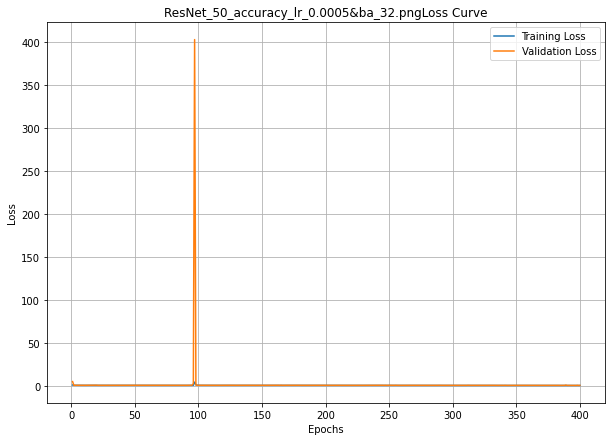

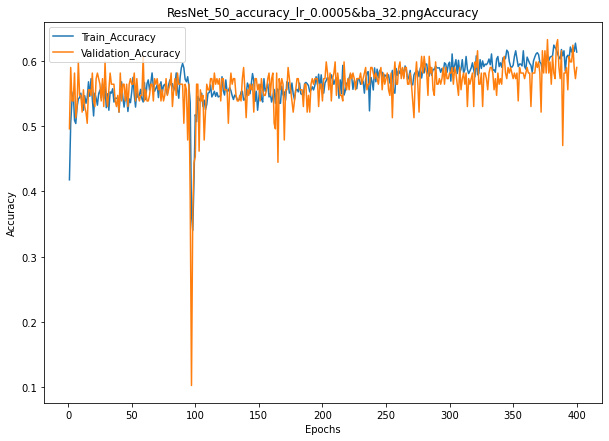

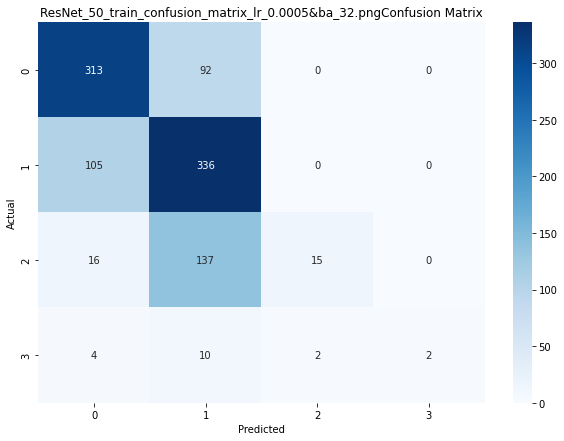

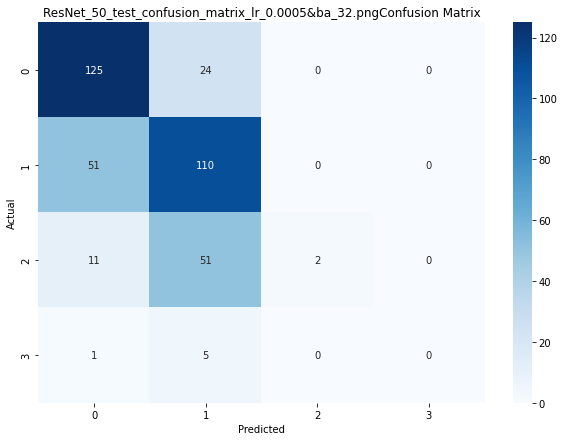

  0%|          | 0/33 [00:00<?, ?it/s]

401


Epoch train [401/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.81]


Training Loss: 0.8367
Training Accuracy: 0.6357


Epoch val [401/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=0.78]


Validation Loss: 0.9698
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

402


Epoch train [402/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.85]


Training Loss: 0.8806
Training Accuracy: 0.6269


Epoch val [402/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.79]


Validation Loss: 0.9862
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

403


Epoch train [403/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.87]


Training Loss: 0.8971
Training Accuracy: 0.6269


Epoch val [403/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.75]


Validation Loss: 0.9366
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

404


Epoch train [404/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.84]


Training Loss: 0.8652
Training Accuracy: 0.6279


Epoch val [404/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.77]


Validation Loss: 0.9563
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

405


Epoch train [405/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.82]


Training Loss: 0.8436
Training Accuracy: 0.6298


Epoch val [405/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.81]


Validation Loss: 1.0095
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

406


Epoch train [406/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.81]


Training Loss: 0.8308
Training Accuracy: 0.6492


Epoch val [406/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.72]


Validation Loss: 0.9054
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

407


Epoch train [407/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.82]


Training Loss: 0.8431
Training Accuracy: 0.6444


Epoch val [407/100]: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.81]


Validation Loss: 1.0121
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

408


Epoch train [408/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.83]


Training Loss: 0.8569
Training Accuracy: 0.6376


Epoch val [408/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.78]


Validation Loss: 0.9792
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

409


Epoch train [409/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.82]


Training Loss: 0.8488
Training Accuracy: 0.6318


Epoch val [409/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.76]


Validation Loss: 0.9439
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

410


Epoch train [410/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.82]


Training Loss: 0.8487
Training Accuracy: 0.6328


Epoch val [410/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.71]


Validation Loss: 0.8843
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

411


Epoch train [411/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.79]


Training Loss: 0.8178
Training Accuracy: 0.6512


Epoch val [411/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.78]


Validation Loss: 0.9748
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

412


Epoch train [412/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.81]


Training Loss: 0.8343
Training Accuracy: 0.6328


Epoch val [412/100]: 100%|██████████| 4/4 [00:00<00:00,  5.78it/s, loss=0.74]


Validation Loss: 0.9268
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

413


Epoch train [413/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.81]


Training Loss: 0.8370
Training Accuracy: 0.6328


Epoch val [413/100]: 100%|██████████| 4/4 [00:00<00:00,  7.23it/s, loss=0.79]


Validation Loss: 0.9842
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

414


Epoch train [414/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.83]


Training Loss: 0.8529
Training Accuracy: 0.6231


Epoch val [414/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.75]


Validation Loss: 0.9329
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

415


Epoch train [415/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.83]


Training Loss: 0.8589
Training Accuracy: 0.6473


Epoch val [415/100]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=0.72]


Validation Loss: 0.9046
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

416


Epoch train [416/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.84]


Training Loss: 0.8632
Training Accuracy: 0.6269


Epoch val [416/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.73]


Validation Loss: 0.9148
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

417


Epoch train [417/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.80]


Training Loss: 0.8290
Training Accuracy: 0.6638


Epoch val [417/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.74]


Validation Loss: 0.9292
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

418


Epoch train [418/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.79]


Training Loss: 0.8167
Training Accuracy: 0.6579


Epoch val [418/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.73]


Validation Loss: 0.9177
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

419


Epoch train [419/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.77]


Training Loss: 0.7958
Training Accuracy: 0.6589


Epoch val [419/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.73]


Validation Loss: 0.9121
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

420


Epoch train [420/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.81]


Training Loss: 0.8317
Training Accuracy: 0.6357


Epoch val [420/100]: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s, loss=0.71]


Validation Loss: 0.8830
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

421


Epoch train [421/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.78]


Training Loss: 0.8047
Training Accuracy: 0.6570


Epoch val [421/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.75]


Validation Loss: 0.9410
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

422


Epoch train [422/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.78]


Training Loss: 0.8018
Training Accuracy: 0.6628


Epoch val [422/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=0.77]


Validation Loss: 0.9580
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

423


Epoch train [423/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.77]


Training Loss: 0.7978
Training Accuracy: 0.6570


Epoch val [423/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.68]


Validation Loss: 0.8476
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

424


Epoch train [424/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.77]


Training Loss: 0.7889
Training Accuracy: 0.6483


Epoch val [424/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.69]


Validation Loss: 0.8624
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

425


Epoch train [425/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.76]


Training Loss: 0.7872
Training Accuracy: 0.6483


Epoch val [425/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.73]


Validation Loss: 0.9093
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

426


Epoch train [426/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.75]


Training Loss: 0.7768
Training Accuracy: 0.6599


Epoch val [426/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.73]


Validation Loss: 0.9123
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

427


Epoch train [427/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.75]


Training Loss: 0.7706
Training Accuracy: 0.6628


Epoch val [427/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.77]


Validation Loss: 0.9648
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

428


Epoch train [428/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.80]


Training Loss: 0.8208
Training Accuracy: 0.6318


Epoch val [428/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=0.72]


Validation Loss: 0.8967
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

429


Epoch train [429/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.79]


Training Loss: 0.8151
Training Accuracy: 0.6512


Epoch val [429/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.75]


Validation Loss: 0.9335
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

430


Epoch train [430/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.76]


Training Loss: 0.7840
Training Accuracy: 0.6395


Epoch val [430/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.73]


Validation Loss: 0.9104
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

431


Epoch train [431/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.75]


Training Loss: 0.7726
Training Accuracy: 0.6570


Epoch val [431/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=0.76]


Validation Loss: 0.9459
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

432


Epoch train [432/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.75]


Training Loss: 0.7704
Training Accuracy: 0.6705


Epoch val [432/100]: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.68]


Validation Loss: 0.8562
Validation Accuracy: 0.7179


  0%|          | 0/33 [00:00<?, ?it/s]

433


Epoch train [433/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.77]


Training Loss: 0.7923
Training Accuracy: 0.6579


Epoch val [433/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.70]


Validation Loss: 0.8780
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

434


Epoch train [434/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.75]


Training Loss: 0.7727
Training Accuracy: 0.6550


Epoch val [434/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=0.70]


Validation Loss: 0.8755
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

435


Epoch train [435/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.76]


Training Loss: 0.7823
Training Accuracy: 0.6734


Epoch val [435/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=0.74]


Validation Loss: 0.9208
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

436


Epoch train [436/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.73]


Training Loss: 0.7486
Training Accuracy: 0.6822


Epoch val [436/100]: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s, loss=0.70]


Validation Loss: 0.8709
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

437


Epoch train [437/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.74]


Training Loss: 0.7582
Training Accuracy: 0.6628


Epoch val [437/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=0.77]


Validation Loss: 0.9606
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

438


Epoch train [438/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.76]


Training Loss: 0.7789
Training Accuracy: 0.6841


Epoch val [438/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.76]


Validation Loss: 0.9535
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

439


Epoch train [439/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.71]


Training Loss: 0.7365
Training Accuracy: 0.6657


Epoch val [439/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.74]


Validation Loss: 0.9270
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

440


Epoch train [440/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.77]


Training Loss: 0.7901
Training Accuracy: 0.6570


Epoch val [440/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.72]


Validation Loss: 0.8983
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

441


Epoch train [441/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.76]


Training Loss: 0.7867
Training Accuracy: 0.6579


Epoch val [441/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.71]


Validation Loss: 0.8858
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

442


Epoch train [442/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.72]


Training Loss: 0.7420
Training Accuracy: 0.6764


Epoch val [442/100]: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s, loss=0.69]


Validation Loss: 0.8608
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

443


Epoch train [443/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.73]


Training Loss: 0.7475
Training Accuracy: 0.6977


Epoch val [443/100]: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=0.77]


Validation Loss: 0.9684
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

444


Epoch train [444/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.75]


Training Loss: 0.7692
Training Accuracy: 0.6880


Epoch val [444/100]: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.71]


Validation Loss: 0.8831
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

445


Epoch train [445/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.73]


Training Loss: 0.7480
Training Accuracy: 0.6734


Epoch val [445/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.76]


Validation Loss: 0.9445
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

446


Epoch train [446/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.71]


Training Loss: 0.7362
Training Accuracy: 0.6870


Epoch val [446/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.77]


Validation Loss: 0.9672
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

447


Epoch train [447/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.72]


Training Loss: 0.7418
Training Accuracy: 0.6783


Epoch val [447/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.72]


Validation Loss: 0.9046
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

448


Epoch train [448/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.73]


Training Loss: 0.7486
Training Accuracy: 0.6744


Epoch val [448/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.88]


Validation Loss: 1.0944
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

449


Epoch train [449/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.71]


Training Loss: 0.7316
Training Accuracy: 0.6802


Epoch val [449/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.75]


Validation Loss: 0.9315
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

450


Epoch train [450/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.73]


Training Loss: 0.7545
Training Accuracy: 0.6860


Epoch val [450/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.75]


Validation Loss: 0.9402
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

451


Epoch train [451/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.69]


Training Loss: 0.7116
Training Accuracy: 0.6890


Epoch val [451/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.76]


Validation Loss: 0.9555
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

452


Epoch train [452/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.68]


Training Loss: 0.6967
Training Accuracy: 0.7006


Epoch val [452/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.70]


Validation Loss: 0.8791
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

453


Epoch train [453/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.73]


Training Loss: 0.7562
Training Accuracy: 0.6783


Epoch val [453/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=0.75]


Validation Loss: 0.9392
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

454


Epoch train [454/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.69]


Training Loss: 0.7088
Training Accuracy: 0.6957


Epoch val [454/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=0.78]


Validation Loss: 0.9740
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

455


Epoch train [455/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.67]


Training Loss: 0.6950
Training Accuracy: 0.7025


Epoch val [455/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.78]


Validation Loss: 0.9691
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

456


Epoch train [456/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.71]


Training Loss: 0.7341
Training Accuracy: 0.6899


Epoch val [456/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.78]


Validation Loss: 0.9708
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

457


Epoch train [457/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.69]


Training Loss: 0.7143
Training Accuracy: 0.7045


Epoch val [457/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.74]


Validation Loss: 0.9261
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

458


Epoch train [458/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.66]


Training Loss: 0.6808
Training Accuracy: 0.7151


Epoch val [458/100]: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=0.74]


Validation Loss: 0.9301
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

459


Epoch train [459/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.68]


Training Loss: 0.7049
Training Accuracy: 0.6928


Epoch val [459/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=0.79]


Validation Loss: 0.9918
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

460


Epoch train [460/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.69]


Training Loss: 0.7148
Training Accuracy: 0.6919


Epoch val [460/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.79]


Validation Loss: 0.9898
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

461


Epoch train [461/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.65]


Training Loss: 0.6718
Training Accuracy: 0.7045


Epoch val [461/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.75]


Validation Loss: 0.9325
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

462


Epoch train [462/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.68]


Training Loss: 0.7054
Training Accuracy: 0.7035


Epoch val [462/100]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.75]


Validation Loss: 0.9436
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

463


Epoch train [463/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.71]


Training Loss: 0.7366
Training Accuracy: 0.6880


Epoch val [463/100]: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, loss=0.73]


Validation Loss: 0.9168
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

464


Epoch train [464/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.68]


Training Loss: 0.7046
Training Accuracy: 0.6754


Epoch val [464/100]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=0.72]


Validation Loss: 0.9045
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

465


Epoch train [465/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.69]


Training Loss: 0.7071
Training Accuracy: 0.6938


Epoch val [465/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.72]


Validation Loss: 0.9035
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

466


Epoch train [466/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.67]


Training Loss: 0.6890
Training Accuracy: 0.6986


Epoch val [466/100]: 100%|██████████| 4/4 [00:00<00:00,  6.95it/s, loss=0.76]


Validation Loss: 0.9513
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

467


Epoch train [467/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.70]


Training Loss: 0.7239
Training Accuracy: 0.7045


Epoch val [467/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.72]


Validation Loss: 0.8990
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

468


Epoch train [468/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.65]


Training Loss: 0.6730
Training Accuracy: 0.6996


Epoch val [468/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.77]


Validation Loss: 0.9640
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

469


Epoch train [469/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.68]


Training Loss: 0.7004
Training Accuracy: 0.6870


Epoch val [469/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.76]


Validation Loss: 0.9520
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

470


Epoch train [470/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.65]


Training Loss: 0.6692
Training Accuracy: 0.7093


Epoch val [470/100]: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=0.73]


Validation Loss: 0.9106
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

471


Epoch train [471/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.67]


Training Loss: 0.6899
Training Accuracy: 0.7074


Epoch val [471/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.76]


Validation Loss: 0.9487
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

472


Epoch train [472/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.67]


Training Loss: 0.6888
Training Accuracy: 0.7025


Epoch val [472/100]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=0.72]


Validation Loss: 0.8973
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

473


Epoch train [473/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.63]


Training Loss: 0.6538
Training Accuracy: 0.7190


Epoch val [473/100]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.71]


Validation Loss: 0.8914
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

474


Epoch train [474/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.65]


Training Loss: 0.6742
Training Accuracy: 0.7200


Epoch val [474/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=0.79]


Validation Loss: 0.9869
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

475


Epoch train [475/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.65]


Training Loss: 0.6696
Training Accuracy: 0.7054


Epoch val [475/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.79]


Validation Loss: 0.9882
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

476


Epoch train [476/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.66]


Training Loss: 0.6798
Training Accuracy: 0.7045


Epoch val [476/100]: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.73]


Validation Loss: 0.9096
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

477


Epoch train [477/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.64]


Training Loss: 0.6613
Training Accuracy: 0.7219


Epoch val [477/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.74]


Validation Loss: 0.9289
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

478


Epoch train [478/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.59]


Training Loss: 0.6116
Training Accuracy: 0.7403


Epoch val [478/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.74]


Validation Loss: 0.9266
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

479


Epoch train [479/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.62]


Training Loss: 0.6346
Training Accuracy: 0.7171


Epoch val [479/100]: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=0.76]


Validation Loss: 0.9444
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

480


Epoch train [480/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.63]


Training Loss: 0.6506
Training Accuracy: 0.7171


Epoch val [480/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.78]


Validation Loss: 0.9786
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

481


Epoch train [481/100]: 100%|██████████| 33/33 [00:13<00:00,  2.53it/s, loss=0.65]


Training Loss: 0.6659
Training Accuracy: 0.7258


Epoch val [481/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.71]


Validation Loss: 0.8840
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

482


Epoch train [482/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.68]


Training Loss: 0.6982
Training Accuracy: 0.6967


Epoch val [482/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.68]


Validation Loss: 0.8443
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

483


Epoch train [483/100]: 100%|██████████| 33/33 [00:11<00:00,  2.75it/s, loss=0.62]


Training Loss: 0.6344
Training Accuracy: 0.7248


Epoch val [483/100]: 100%|██████████| 4/4 [00:00<00:00,  5.53it/s, loss=0.69]


Validation Loss: 0.8616
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

484


Epoch train [484/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.61]


Training Loss: 0.6242
Training Accuracy: 0.7180


Epoch val [484/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=0.78]


Validation Loss: 0.9699
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

485


Epoch train [485/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.66]


Training Loss: 0.6834
Training Accuracy: 0.7171


Epoch val [485/100]: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=0.69]


Validation Loss: 0.8636
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

486


Epoch train [486/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.65]


Training Loss: 0.6716
Training Accuracy: 0.7151


Epoch val [486/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.71]


Validation Loss: 0.8854
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

487


Epoch train [487/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.63]


Training Loss: 0.6452
Training Accuracy: 0.7248


Epoch val [487/100]: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, loss=0.77]


Validation Loss: 0.9653
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

488


Epoch train [488/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.66]


Training Loss: 0.6789
Training Accuracy: 0.7122


Epoch val [488/100]: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, loss=0.77]


Validation Loss: 0.9580
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

489


Epoch train [489/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.65]


Training Loss: 0.6722
Training Accuracy: 0.7016


Epoch val [489/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.79]


Validation Loss: 0.9880
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

490


Epoch train [490/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.65]


Training Loss: 0.6695
Training Accuracy: 0.7190


Epoch val [490/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.69]


Validation Loss: 0.8643
Validation Accuracy: 0.7009


  0%|          | 0/33 [00:00<?, ?it/s]

491


Epoch train [491/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.62]


Training Loss: 0.6405
Training Accuracy: 0.7471


Epoch val [491/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.74]


Validation Loss: 0.9236
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

492


Epoch train [492/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.61]


Training Loss: 0.6294
Training Accuracy: 0.7374


Epoch val [492/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.78]


Validation Loss: 0.9739
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

493


Epoch train [493/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.66]


Training Loss: 0.6762
Training Accuracy: 0.7054


Epoch val [493/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.69]


Validation Loss: 0.8667
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

494


Epoch train [494/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.64]


Training Loss: 0.6551
Training Accuracy: 0.7316


Epoch val [494/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=0.74]


Validation Loss: 0.9307
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

495


Epoch train [495/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.59]


Training Loss: 0.6103
Training Accuracy: 0.7364


Epoch val [495/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.71]


Validation Loss: 0.8837
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

496


Epoch train [496/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.59]


Training Loss: 0.6029
Training Accuracy: 0.7519


Epoch val [496/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.79]


Validation Loss: 0.9830
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

497


Epoch train [497/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.61]


Training Loss: 0.6322
Training Accuracy: 0.7355


Epoch val [497/100]: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, loss=0.76]


Validation Loss: 0.9459
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

498


Epoch train [498/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.59]


Training Loss: 0.6040
Training Accuracy: 0.7442


Epoch val [498/100]: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, loss=0.73]


Validation Loss: 0.9138
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

499


Epoch train [499/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.60]


Training Loss: 0.6216
Training Accuracy: 0.7384


Epoch val [499/100]: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.77]


Validation Loss: 0.9683
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

500


Epoch train [500/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.61]


Training Loss: 0.6247
Training Accuracy: 0.7219


Epoch val [500/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.73]


Validation Loss: 0.9123
Validation Accuracy: 0.6410


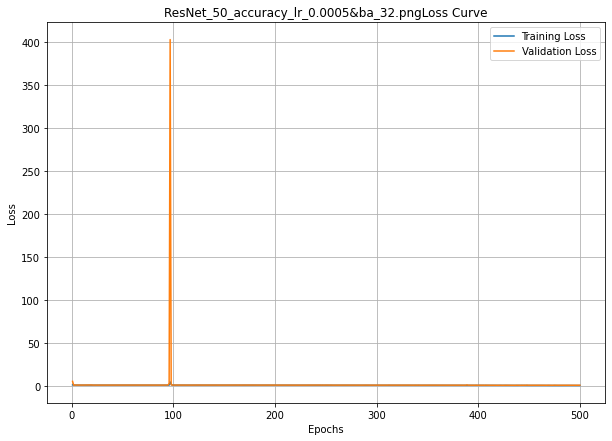

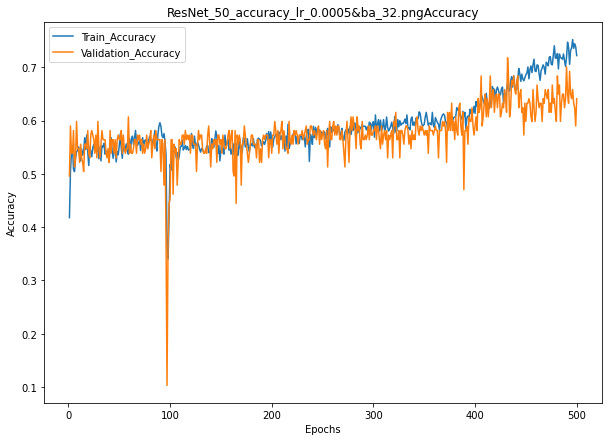

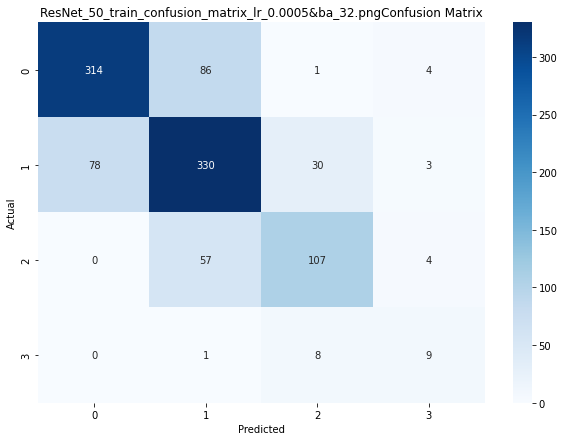

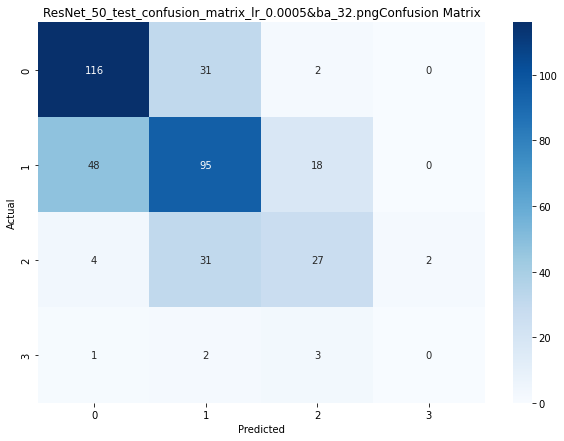

  0%|          | 0/33 [00:00<?, ?it/s]

501


Epoch train [501/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.58]


Training Loss: 0.5962
Training Accuracy: 0.7539


Epoch val [501/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.72]


Validation Loss: 0.9033
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

502


Epoch train [502/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.62]


Training Loss: 0.6429
Training Accuracy: 0.7374


Epoch val [502/100]: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=0.71]


Validation Loss: 0.8813
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

503


Epoch train [503/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.56]


Training Loss: 0.5778
Training Accuracy: 0.7597


Epoch val [503/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.71]


Validation Loss: 0.8886
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

504


Epoch train [504/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.57]


Training Loss: 0.5922
Training Accuracy: 0.7539


Epoch val [504/100]: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s, loss=0.71]


Validation Loss: 0.8911
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

505


Epoch train [505/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.57]


Training Loss: 0.5913
Training Accuracy: 0.7558


Epoch val [505/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.70]


Validation Loss: 0.8700
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

506


Epoch train [506/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.57]


Training Loss: 0.5917
Training Accuracy: 0.7422


Epoch val [506/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=0.89]


Validation Loss: 1.1077
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

507


Epoch train [507/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.61]


Training Loss: 0.6301
Training Accuracy: 0.7403


Epoch val [507/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.67]


Validation Loss: 0.8403
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

508


Epoch train [508/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.59]


Training Loss: 0.6099
Training Accuracy: 0.7578


Epoch val [508/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.76]


Validation Loss: 0.9446
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

509


Epoch train [509/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.61]


Training Loss: 0.6264
Training Accuracy: 0.7326


Epoch val [509/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=0.73]


Validation Loss: 0.9145
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

510


Epoch train [510/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.60]


Training Loss: 0.6156
Training Accuracy: 0.7403


Epoch val [510/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.75]


Validation Loss: 0.9328
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

511


Epoch train [511/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.58]


Training Loss: 0.5932
Training Accuracy: 0.7471


Epoch val [511/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.76]


Validation Loss: 0.9501
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

512


Epoch train [512/100]: 100%|██████████| 33/33 [00:12<00:00,  2.60it/s, loss=0.61]


Training Loss: 0.6254
Training Accuracy: 0.7442


Epoch val [512/100]: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, loss=0.68]


Validation Loss: 0.8478
Validation Accuracy: 0.7009


  0%|          | 0/33 [00:00<?, ?it/s]

513


Epoch train [513/100]: 100%|██████████| 33/33 [00:12<00:00,  2.64it/s, loss=0.56]


Training Loss: 0.5803
Training Accuracy: 0.7490


Epoch val [513/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=0.76]


Validation Loss: 0.9532
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

514


Epoch train [514/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.60]


Training Loss: 0.6149
Training Accuracy: 0.7219


Epoch val [514/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=0.69]


Validation Loss: 0.8570
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

515


Epoch train [515/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.54]


Training Loss: 0.5577
Training Accuracy: 0.7636


Epoch val [515/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.67]


Validation Loss: 0.8321
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

516


Epoch train [516/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.57]


Training Loss: 0.5831
Training Accuracy: 0.7519


Epoch val [516/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=0.80]


Validation Loss: 1.0036
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

517


Epoch train [517/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.60]


Training Loss: 0.6140
Training Accuracy: 0.7597


Epoch val [517/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.70]


Validation Loss: 0.8733
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

518


Epoch train [518/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.56]


Training Loss: 0.5812
Training Accuracy: 0.7519


Epoch val [518/100]: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.74]


Validation Loss: 0.9246
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

519


Epoch train [519/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.54]


Training Loss: 0.5513
Training Accuracy: 0.7597


Epoch val [519/100]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=0.77]


Validation Loss: 0.9650
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

520


Epoch train [520/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.60]


Training Loss: 0.6192
Training Accuracy: 0.7335


Epoch val [520/100]: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s, loss=0.74]


Validation Loss: 0.9222
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

521


Epoch train [521/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.58]


Training Loss: 0.6025
Training Accuracy: 0.7345


Epoch val [521/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.70]


Validation Loss: 0.8714
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

522


Epoch train [522/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.52]


Training Loss: 0.5346
Training Accuracy: 0.7626


Epoch val [522/100]: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.76]


Validation Loss: 0.9528
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

523


Epoch train [523/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.54]


Training Loss: 0.5581
Training Accuracy: 0.7607


Epoch val [523/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=0.71]


Validation Loss: 0.8885
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

524


Epoch train [524/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.59]


Training Loss: 0.6030
Training Accuracy: 0.7432


Epoch val [524/100]: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, loss=0.80]


Validation Loss: 1.0005
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

525


Epoch train [525/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.59]


Training Loss: 0.6103
Training Accuracy: 0.7374


Epoch val [525/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.69]


Validation Loss: 0.8615
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

526


Epoch train [526/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.59]


Training Loss: 0.6052
Training Accuracy: 0.7442


Epoch val [526/100]: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.94]


Validation Loss: 1.1716
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

527


Epoch train [527/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.56]


Training Loss: 0.5723
Training Accuracy: 0.7471


Epoch val [527/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.75]


Validation Loss: 0.9401
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

528


Epoch train [528/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.56]


Training Loss: 0.5778
Training Accuracy: 0.7539


Epoch val [528/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.70]


Validation Loss: 0.8694
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

529


Epoch train [529/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.54]


Training Loss: 0.5555
Training Accuracy: 0.7665


Epoch val [529/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.74]


Validation Loss: 0.9241
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

530


Epoch train [530/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.56]


Training Loss: 0.5761
Training Accuracy: 0.7510


Epoch val [530/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=0.75]


Validation Loss: 0.9320
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

531


Epoch train [531/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.50]


Training Loss: 0.5145
Training Accuracy: 0.7955


Epoch val [531/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=0.86]


Validation Loss: 1.0721
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

532


Epoch train [532/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.50]


Training Loss: 0.5167
Training Accuracy: 0.7810


Epoch val [532/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=0.77]


Validation Loss: 0.9606
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

533


Epoch train [533/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.53]


Training Loss: 0.5497
Training Accuracy: 0.7645


Epoch val [533/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.80]


Validation Loss: 1.0010
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

534


Epoch train [534/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.52]


Training Loss: 0.5374
Training Accuracy: 0.7694


Epoch val [534/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.70]


Validation Loss: 0.8758
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

535


Epoch train [535/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.53]


Training Loss: 0.5497
Training Accuracy: 0.7742


Epoch val [535/100]: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, loss=0.65]


Validation Loss: 0.8109
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

536


Epoch train [536/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.51]


Training Loss: 0.5294
Training Accuracy: 0.7752


Epoch val [536/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=0.70]


Validation Loss: 0.8729
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

537


Epoch train [537/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.52]


Training Loss: 0.5400
Training Accuracy: 0.7762


Epoch val [537/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.72]


Validation Loss: 0.9030
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

538


Epoch train [538/100]: 100%|██████████| 33/33 [00:12<00:00,  2.75it/s, loss=0.53]


Training Loss: 0.5439
Training Accuracy: 0.7742


Epoch val [538/100]: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.69]


Validation Loss: 0.8617
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

539


Epoch train [539/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.51]


Training Loss: 0.5291
Training Accuracy: 0.7694


Epoch val [539/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.85]


Validation Loss: 1.0681
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

540


Epoch train [540/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.50]


Training Loss: 0.5201
Training Accuracy: 0.7859


Epoch val [540/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.76]


Validation Loss: 0.9499
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

541


Epoch train [541/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.56]


Training Loss: 0.5785
Training Accuracy: 0.7432


Epoch val [541/100]: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, loss=0.73]


Validation Loss: 0.9090
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

542


Epoch train [542/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.51]


Training Loss: 0.5204
Training Accuracy: 0.7897


Epoch val [542/100]: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.76]


Validation Loss: 0.9496
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

543


Epoch train [543/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.48]


Training Loss: 0.4941
Training Accuracy: 0.8110


Epoch val [543/100]: 100%|██████████| 4/4 [00:00<00:00,  6.85it/s, loss=0.83]


Validation Loss: 1.0365
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

544


Epoch train [544/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.52]


Training Loss: 0.5338
Training Accuracy: 0.7519


Epoch val [544/100]: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.72]


Validation Loss: 0.8948
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

545


Epoch train [545/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.49]


Training Loss: 0.5100
Training Accuracy: 0.7791


Epoch val [545/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=0.83]


Validation Loss: 1.0390
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

546


Epoch train [546/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.49]


Training Loss: 0.5067
Training Accuracy: 0.7917


Epoch val [546/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=0.82]


Validation Loss: 1.0299
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

547


Epoch train [547/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.48]


Training Loss: 0.4995
Training Accuracy: 0.7820


Epoch val [547/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.89]


Validation Loss: 1.1185
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

548


Epoch train [548/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.47]


Training Loss: 0.4893
Training Accuracy: 0.7917


Epoch val [548/100]: 100%|██████████| 4/4 [00:00<00:00,  7.03it/s, loss=0.82]


Validation Loss: 1.0291
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

549


Epoch train [549/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.48]


Training Loss: 0.4948
Training Accuracy: 0.7994


Epoch val [549/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.75]


Validation Loss: 0.9374
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

550


Epoch train [550/100]: 100%|██████████| 33/33 [00:11<00:00,  2.97it/s, loss=0.50]


Training Loss: 0.5196
Training Accuracy: 0.7800


Epoch val [550/100]: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.73]


Validation Loss: 0.9166
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

551


Epoch train [551/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.50]


Training Loss: 0.5124
Training Accuracy: 0.7926


Epoch val [551/100]: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.77]


Validation Loss: 0.9662
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

552


Epoch train [552/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.51]


Training Loss: 0.5220
Training Accuracy: 0.7888


Epoch val [552/100]: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s, loss=0.77]


Validation Loss: 0.9602
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

553


Epoch train [553/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.50]


Training Loss: 0.5105
Training Accuracy: 0.8014


Epoch val [553/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.77]


Validation Loss: 0.9617
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

554


Epoch train [554/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.50]


Training Loss: 0.5193
Training Accuracy: 0.7917


Epoch val [554/100]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=0.77]


Validation Loss: 0.9604
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

555


Epoch train [555/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.49]


Training Loss: 0.5072
Training Accuracy: 0.7810


Epoch val [555/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=0.78]


Validation Loss: 0.9747
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

556


Epoch train [556/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.51]


Training Loss: 0.5272
Training Accuracy: 0.7829


Epoch val [556/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=1.01]


Validation Loss: 1.2661
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

557


Epoch train [557/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.51]


Training Loss: 0.5211
Training Accuracy: 0.7897


Epoch val [557/100]: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s, loss=0.75]


Validation Loss: 0.9423
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

558


Epoch train [558/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.49]


Training Loss: 0.5093
Training Accuracy: 0.7829


Epoch val [558/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.69]


Validation Loss: 0.8580
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

559


Epoch train [559/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.48]


Training Loss: 0.4980
Training Accuracy: 0.8062


Epoch val [559/100]: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=0.74]


Validation Loss: 0.9188
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

560


Epoch train [560/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.44]


Training Loss: 0.4570
Training Accuracy: 0.8159


Epoch val [560/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=0.89]


Validation Loss: 1.1151
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

561


Epoch train [561/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.44]


Training Loss: 0.4538
Training Accuracy: 0.8091


Epoch val [561/100]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s, loss=0.82]


Validation Loss: 1.0305
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

562


Epoch train [562/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.47]


Training Loss: 0.4817
Training Accuracy: 0.7946


Epoch val [562/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=0.80]


Validation Loss: 0.9991
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

563


Epoch train [563/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.49]


Training Loss: 0.5009
Training Accuracy: 0.7781


Epoch val [563/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=0.74]


Validation Loss: 0.9255
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

564


Epoch train [564/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.46]


Training Loss: 0.4745
Training Accuracy: 0.7975


Epoch val [564/100]: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s, loss=1.02]


Validation Loss: 1.2742
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

565


Epoch train [565/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.45]


Training Loss: 0.4588
Training Accuracy: 0.8091


Epoch val [565/100]: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=0.75]


Validation Loss: 0.9422
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

566


Epoch train [566/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.46]


Training Loss: 0.4737
Training Accuracy: 0.8091


Epoch val [566/100]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=0.89]


Validation Loss: 1.1093
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

567


Epoch train [567/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.46]


Training Loss: 0.4701
Training Accuracy: 0.8043


Epoch val [567/100]: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=0.84]


Validation Loss: 1.0506
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

568


Epoch train [568/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.40]


Training Loss: 0.4132
Training Accuracy: 0.8353


Epoch val [568/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=0.85]


Validation Loss: 1.0573
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

569


Epoch train [569/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.44]


Training Loss: 0.4532
Training Accuracy: 0.8110


Epoch val [569/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=0.77]


Validation Loss: 0.9569
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

570


Epoch train [570/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.49]


Training Loss: 0.5018
Training Accuracy: 0.7975


Epoch val [570/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.82]


Validation Loss: 1.0251
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

571


Epoch train [571/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.47]


Training Loss: 0.4844
Training Accuracy: 0.7994


Epoch val [571/100]: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.77]


Validation Loss: 0.9573
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

572


Epoch train [572/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.47]


Training Loss: 0.4799
Training Accuracy: 0.7936


Epoch val [572/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.79]


Validation Loss: 0.9834
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

573


Epoch train [573/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.44]


Training Loss: 0.4489
Training Accuracy: 0.7994


Epoch val [573/100]: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s, loss=0.83]


Validation Loss: 1.0373
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

574


Epoch train [574/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.44]


Training Loss: 0.4577
Training Accuracy: 0.7984


Epoch val [574/100]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=0.79]


Validation Loss: 0.9885
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

575


Epoch train [575/100]: 100%|██████████| 33/33 [00:11<00:00,  2.97it/s, loss=0.43]


Training Loss: 0.4440
Training Accuracy: 0.8188


Epoch val [575/100]: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=0.87]


Validation Loss: 1.0903
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

576


Epoch train [576/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.43]


Training Loss: 0.4436
Training Accuracy: 0.8140


Epoch val [576/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=0.82]


Validation Loss: 1.0290
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

577


Epoch train [577/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.43]


Training Loss: 0.4392
Training Accuracy: 0.8246


Epoch val [577/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=1.09]


Validation Loss: 1.3600
Validation Accuracy: 0.5641


  0%|          | 0/33 [00:00<?, ?it/s]

578


Epoch train [578/100]: 100%|██████████| 33/33 [00:11<00:00,  2.99it/s, loss=0.44]


Training Loss: 0.4529
Training Accuracy: 0.8159


Epoch val [578/100]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=0.88]


Validation Loss: 1.1029
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

579


Epoch train [579/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.44]


Training Loss: 0.4554
Training Accuracy: 0.8110


Epoch val [579/100]: 100%|██████████| 4/4 [00:00<00:00,  6.89it/s, loss=0.97]


Validation Loss: 1.2106
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

580


Epoch train [580/100]: 100%|██████████| 33/33 [00:11<00:00,  2.96it/s, loss=0.43]


Training Loss: 0.4380
Training Accuracy: 0.8236


Epoch val [580/100]: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, loss=1.05]


Validation Loss: 1.3108
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

581


Epoch train [581/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.40]


Training Loss: 0.4155
Training Accuracy: 0.8236


Epoch val [581/100]: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.87]


Validation Loss: 1.0848
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

582


Epoch train [582/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.45]


Training Loss: 0.4603
Training Accuracy: 0.8101


Epoch val [582/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.83]


Validation Loss: 1.0316
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

583


Epoch train [583/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.44]


Training Loss: 0.4549
Training Accuracy: 0.8159


Epoch val [583/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=0.87]


Validation Loss: 1.0890
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

584


Epoch train [584/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.44]


Training Loss: 0.4561
Training Accuracy: 0.8110


Epoch val [584/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=0.93]


Validation Loss: 1.1579
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

585


Epoch train [585/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.44]


Training Loss: 0.4528
Training Accuracy: 0.8043


Epoch val [585/100]: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=0.92]


Validation Loss: 1.1547
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

586


Epoch train [586/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.39]


Training Loss: 0.4062
Training Accuracy: 0.8333


Epoch val [586/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=0.85]


Validation Loss: 1.0668
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

587


Epoch train [587/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.41]


Training Loss: 0.4268
Training Accuracy: 0.8198


Epoch val [587/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.81]


Validation Loss: 1.0101
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

588


Epoch train [588/100]: 100%|██████████| 33/33 [00:11<00:00,  2.96it/s, loss=0.40]


Training Loss: 0.4166
Training Accuracy: 0.8256


Epoch val [588/100]: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=0.97]


Validation Loss: 1.2117
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

589


Epoch train [589/100]: 100%|██████████| 33/33 [00:10<00:00,  3.00it/s, loss=0.37]


Training Loss: 0.3809
Training Accuracy: 0.8527


Epoch val [589/100]: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s, loss=0.77]


Validation Loss: 0.9572
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

590


Epoch train [590/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.43]


Training Loss: 0.4402
Training Accuracy: 0.8130


Epoch val [590/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=0.79]


Validation Loss: 0.9931
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

591


Epoch train [591/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.40]


Training Loss: 0.4144
Training Accuracy: 0.8275


Epoch val [591/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=0.90]


Validation Loss: 1.1201
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

592


Epoch train [592/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.40]


Training Loss: 0.4149
Training Accuracy: 0.8178


Epoch val [592/100]: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=0.91]


Validation Loss: 1.1335
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

593


Epoch train [593/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.39]


Training Loss: 0.4019
Training Accuracy: 0.8391


Epoch val [593/100]: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s, loss=1.03]


Validation Loss: 1.2884
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

594


Epoch train [594/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.36]


Training Loss: 0.3717
Training Accuracy: 0.8430


Epoch val [594/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=0.76]


Validation Loss: 0.9531
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

595


Epoch train [595/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.41]


Training Loss: 0.4226
Training Accuracy: 0.8362


Epoch val [595/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=0.87]


Validation Loss: 1.0871
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

596


Epoch train [596/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.44]


Training Loss: 0.4539
Training Accuracy: 0.8120


Epoch val [596/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.87]


Validation Loss: 1.0856
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

597


Epoch train [597/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.40]


Training Loss: 0.4139
Training Accuracy: 0.8236


Epoch val [597/100]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=0.95]


Validation Loss: 1.1883
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

598


Epoch train [598/100]: 100%|██████████| 33/33 [00:10<00:00,  3.01it/s, loss=0.41]


Training Loss: 0.4209
Training Accuracy: 0.8246


Epoch val [598/100]: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=1.05]


Validation Loss: 1.3080
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

599


Epoch train [599/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.35]


Training Loss: 0.3559
Training Accuracy: 0.8595


Epoch val [599/100]: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s, loss=1.03]


Validation Loss: 1.2863
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

600


Epoch train [600/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.37]


Training Loss: 0.3827
Training Accuracy: 0.8430


Epoch val [600/100]: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=0.93]


Validation Loss: 1.1654
Validation Accuracy: 0.6581


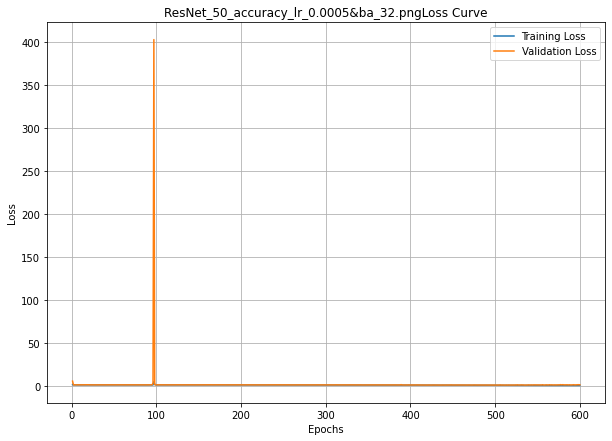

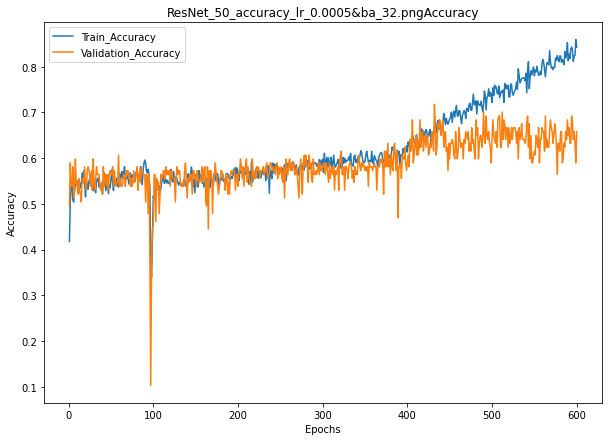

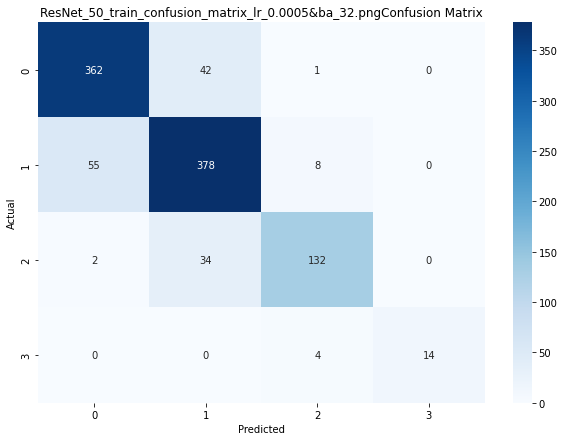

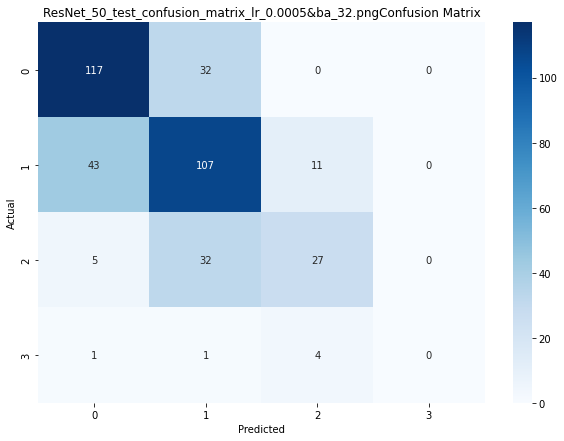

  0%|          | 0/33 [00:00<?, ?it/s]

601


Epoch train [601/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.36]


Training Loss: 0.3755
Training Accuracy: 0.8566


Epoch val [601/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.83]


Validation Loss: 1.0336
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

602


Epoch train [602/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.39]


Training Loss: 0.4058
Training Accuracy: 0.8285


Epoch val [602/100]: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.91]


Validation Loss: 1.1356
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

603


Epoch train [603/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.39]


Training Loss: 0.4036
Training Accuracy: 0.8372


Epoch val [603/100]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=0.79]


Validation Loss: 0.9813
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

604


Epoch train [604/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.37]


Training Loss: 0.3793
Training Accuracy: 0.8517


Epoch val [604/100]: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=1.08]


Validation Loss: 1.3450
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

605


Epoch train [605/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.40]


Training Loss: 0.4150
Training Accuracy: 0.8304


Epoch val [605/100]: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s, loss=0.90]


Validation Loss: 1.1247
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

606


Epoch train [606/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.41]


Training Loss: 0.4251
Training Accuracy: 0.8343


Epoch val [606/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=0.90]


Validation Loss: 1.1189
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

607


Epoch train [607/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.46]


Training Loss: 0.4786
Training Accuracy: 0.8101


Epoch val [607/100]: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, loss=0.85]


Validation Loss: 1.0682
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

608


Epoch train [608/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.42]


Training Loss: 0.4280
Training Accuracy: 0.8091


Epoch val [608/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=0.89]


Validation Loss: 1.1153
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

609


Epoch train [609/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.40]


Training Loss: 0.4143
Training Accuracy: 0.8285


Epoch val [609/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=0.81]


Validation Loss: 1.0089
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

610


Epoch train [610/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.38]


Training Loss: 0.3948
Training Accuracy: 0.8459


Epoch val [610/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=0.91]


Validation Loss: 1.1361
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

611


Epoch train [611/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.37]


Training Loss: 0.3777
Training Accuracy: 0.8421


Epoch val [611/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.91]


Validation Loss: 1.1372
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

612


Epoch train [612/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.37]


Training Loss: 0.3771
Training Accuracy: 0.8624


Epoch val [612/100]: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s, loss=0.89]


Validation Loss: 1.1178
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

613


Epoch train [613/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.35]


Training Loss: 0.3654
Training Accuracy: 0.8585


Epoch val [613/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=1.16]


Validation Loss: 1.4541
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

614


Epoch train [614/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.38]


Training Loss: 0.3939
Training Accuracy: 0.8421


Epoch val [614/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=0.85]


Validation Loss: 1.0629
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

615


Epoch train [615/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.40]


Training Loss: 0.4080
Training Accuracy: 0.8372


Epoch val [615/100]: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s, loss=0.83]


Validation Loss: 1.0429
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

616


Epoch train [616/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.37]


Training Loss: 0.3776
Training Accuracy: 0.8527


Epoch val [616/100]: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=0.88]


Validation Loss: 1.0961
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

617


Epoch train [617/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.38]


Training Loss: 0.3879
Training Accuracy: 0.8488


Epoch val [617/100]: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, loss=1.08]


Validation Loss: 1.3456
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

618


Epoch train [618/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.37]


Training Loss: 0.3850
Training Accuracy: 0.8576


Epoch val [618/100]: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=1.27]


Validation Loss: 1.5924
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

619


Epoch train [619/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.41]


Training Loss: 0.4222
Training Accuracy: 0.8353


Epoch val [619/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.83]


Validation Loss: 1.0384
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

620


Epoch train [620/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.37]


Training Loss: 0.3766
Training Accuracy: 0.8430


Epoch val [620/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=0.98]


Validation Loss: 1.2286
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

621


Epoch train [621/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.39]


Training Loss: 0.3972
Training Accuracy: 0.8498


Epoch val [621/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=1.01]


Validation Loss: 1.2675
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

622


Epoch train [622/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.37]


Training Loss: 0.3807
Training Accuracy: 0.8391


Epoch val [622/100]: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.92]


Validation Loss: 1.1519
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

623


Epoch train [623/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.35]


Training Loss: 0.3576
Training Accuracy: 0.8672


Epoch val [623/100]: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, loss=0.91]


Validation Loss: 1.1333
Validation Accuracy: 0.7094


  0%|          | 0/33 [00:00<?, ?it/s]

624


Epoch train [624/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.32]


Training Loss: 0.3316
Training Accuracy: 0.8711


Epoch val [624/100]: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=0.89]


Validation Loss: 1.1168
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

625


Epoch train [625/100]: 100%|██████████| 33/33 [00:11<00:00,  2.97it/s, loss=0.36]


Training Loss: 0.3714
Training Accuracy: 0.8576


Epoch val [625/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=0.82]


Validation Loss: 1.0242
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

626


Epoch train [626/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.39]


Training Loss: 0.4035
Training Accuracy: 0.8362


Epoch val [626/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.86]


Validation Loss: 1.0718
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

627


Epoch train [627/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.35]


Training Loss: 0.3642
Training Accuracy: 0.8585


Epoch val [627/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.92]


Validation Loss: 1.1545
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

628


Epoch train [628/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.32]


Training Loss: 0.3332
Training Accuracy: 0.8779


Epoch val [628/100]: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=0.80]


Validation Loss: 0.9992
Validation Accuracy: 0.7094


  0%|          | 0/33 [00:00<?, ?it/s]

629


Epoch train [629/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.33]


Training Loss: 0.3382
Training Accuracy: 0.8556


Epoch val [629/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=0.94]


Validation Loss: 1.1801
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

630


Epoch train [630/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.33]


Training Loss: 0.3417
Training Accuracy: 0.8624


Epoch val [630/100]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=0.84]


Validation Loss: 1.0457
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

631


Epoch train [631/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.33]


Training Loss: 0.3358
Training Accuracy: 0.8527


Epoch val [631/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=1.06]


Validation Loss: 1.3264
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

632


Epoch train [632/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.33]


Training Loss: 0.3434
Training Accuracy: 0.8576


Epoch val [632/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=1.06]


Validation Loss: 1.3290
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

633


Epoch train [633/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.32]


Training Loss: 0.3336
Training Accuracy: 0.8643


Epoch val [633/100]: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s, loss=1.00]


Validation Loss: 1.2562
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

634


Epoch train [634/100]: 100%|██████████| 33/33 [00:11<00:00,  2.98it/s, loss=0.39]


Training Loss: 0.4050
Training Accuracy: 0.8353


Epoch val [634/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=0.88]


Validation Loss: 1.1058
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

635


Epoch train [635/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.33]


Training Loss: 0.3429
Training Accuracy: 0.8760


Epoch val [635/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=1.16]


Validation Loss: 1.4534
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

636


Epoch train [636/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.33]


Training Loss: 0.3359
Training Accuracy: 0.8556


Epoch val [636/100]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s, loss=1.09]


Validation Loss: 1.3591
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

637


Epoch train [637/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.33]


Training Loss: 0.3445
Training Accuracy: 0.8663


Epoch val [637/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=1.03]


Validation Loss: 1.2839
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

638


Epoch train [638/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.29]


Training Loss: 0.2977
Training Accuracy: 0.8847


Epoch val [638/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=1.21]


Validation Loss: 1.5132
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

639


Epoch train [639/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.30]


Training Loss: 0.3078
Training Accuracy: 0.8760


Epoch val [639/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.91]


Validation Loss: 1.1339
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

640


Epoch train [640/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.30]


Training Loss: 0.3130
Training Accuracy: 0.8653


Epoch val [640/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=0.93]


Validation Loss: 1.1609
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

641


Epoch train [641/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.33]


Training Loss: 0.3432
Training Accuracy: 0.8576


Epoch val [641/100]: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s, loss=0.92]


Validation Loss: 1.1462
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

642


Epoch train [642/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.33]


Training Loss: 0.3409
Training Accuracy: 0.8556


Epoch val [642/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=1.02]


Validation Loss: 1.2771
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

643


Epoch train [643/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.33]


Training Loss: 0.3376
Training Accuracy: 0.8682


Epoch val [643/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.90]


Validation Loss: 1.1243
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

644


Epoch train [644/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.37]


Training Loss: 0.3829
Training Accuracy: 0.8421


Epoch val [644/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.90]


Validation Loss: 1.1270
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

645


Epoch train [645/100]: 100%|██████████| 33/33 [00:12<00:00,  2.68it/s, loss=0.32]


Training Loss: 0.3323
Training Accuracy: 0.8605


Epoch val [645/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=1.05]


Validation Loss: 1.3116
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

646


Epoch train [646/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.29]


Training Loss: 0.2943
Training Accuracy: 0.8895


Epoch val [646/100]: 100%|██████████| 4/4 [00:00<00:00,  5.65it/s, loss=1.17]


Validation Loss: 1.4599
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

647


Epoch train [647/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.29]


Training Loss: 0.2979
Training Accuracy: 0.8876


Epoch val [647/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=1.17]


Validation Loss: 1.4604
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

648


Epoch train [648/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.29]


Training Loss: 0.3029
Training Accuracy: 0.8837


Epoch val [648/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=1.23]


Validation Loss: 1.5367
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

649


Epoch train [649/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.38]


Training Loss: 0.3918
Training Accuracy: 0.8469


Epoch val [649/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=1.14]


Validation Loss: 1.4253
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

650


Epoch train [650/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.34]


Training Loss: 0.3453
Training Accuracy: 0.8556


Epoch val [650/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=1.06]


Validation Loss: 1.3216
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

651


Epoch train [651/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.28]


Training Loss: 0.2931
Training Accuracy: 0.8818


Epoch val [651/100]: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s, loss=1.11]


Validation Loss: 1.3907
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

652


Epoch train [652/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.29]


Training Loss: 0.3001
Training Accuracy: 0.8789


Epoch val [652/100]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s, loss=1.28]


Validation Loss: 1.6039
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

653


Epoch train [653/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.28]


Training Loss: 0.2870
Training Accuracy: 0.8934


Epoch val [653/100]: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.96]


Validation Loss: 1.1982
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

654


Epoch train [654/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.30]


Training Loss: 0.3094
Training Accuracy: 0.8886


Epoch val [654/100]: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=0.98]


Validation Loss: 1.2303
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

655


Epoch train [655/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.28]


Training Loss: 0.2915
Training Accuracy: 0.8818


Epoch val [655/100]: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=0.94]


Validation Loss: 1.1734
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

656


Epoch train [656/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.30]


Training Loss: 0.3127
Training Accuracy: 0.8731


Epoch val [656/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=0.96]


Validation Loss: 1.2044
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

657


Epoch train [657/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.31]


Training Loss: 0.3165
Training Accuracy: 0.8760


Epoch val [657/100]: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, loss=0.99]


Validation Loss: 1.2338
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

658


Epoch train [658/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.28]


Training Loss: 0.2925
Training Accuracy: 0.8847


Epoch val [658/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=1.05]


Validation Loss: 1.3068
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

659


Epoch train [659/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.26]


Training Loss: 0.2709
Training Accuracy: 0.9012


Epoch val [659/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=1.14]


Validation Loss: 1.4247
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

660


Epoch train [660/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.30]


Training Loss: 0.3111
Training Accuracy: 0.8769


Epoch val [660/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=0.95]


Validation Loss: 1.1909
Validation Accuracy: 0.7009


  0%|          | 0/33 [00:00<?, ?it/s]

661


Epoch train [661/100]: 100%|██████████| 33/33 [00:11<00:00,  2.96it/s, loss=0.32]


Training Loss: 0.3281
Training Accuracy: 0.8692


Epoch val [661/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=1.04]


Validation Loss: 1.3047
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

662


Epoch train [662/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.27]


Training Loss: 0.2826
Training Accuracy: 0.8973


Epoch val [662/100]: 100%|██████████| 4/4 [00:00<00:00,  6.71it/s, loss=1.03]


Validation Loss: 1.2819
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

663


Epoch train [663/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.32]


Training Loss: 0.3266
Training Accuracy: 0.8779


Epoch val [663/100]: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=0.93]


Validation Loss: 1.1683
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

664


Epoch train [664/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.27]


Training Loss: 0.2809
Training Accuracy: 0.8944


Epoch val [664/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=0.90]


Validation Loss: 1.1279
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

665


Epoch train [665/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.29]


Training Loss: 0.3036
Training Accuracy: 0.8789


Epoch val [665/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=1.01]


Validation Loss: 1.2580
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

666


Epoch train [666/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.23]


Training Loss: 0.2348
Training Accuracy: 0.9041


Epoch val [666/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=1.21]


Validation Loss: 1.5072
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

667


Epoch train [667/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.27]


Training Loss: 0.2813
Training Accuracy: 0.8876


Epoch val [667/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=1.14]


Validation Loss: 1.4299
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

668


Epoch train [668/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.36]


Training Loss: 0.3742
Training Accuracy: 0.8818


Epoch val [668/100]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=0.87]


Validation Loss: 1.0882
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

669


Epoch train [669/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.27]


Training Loss: 0.2817
Training Accuracy: 0.8915


Epoch val [669/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=0.99]


Validation Loss: 1.2347
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

670


Epoch train [670/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.27]


Training Loss: 0.2780
Training Accuracy: 0.8963


Epoch val [670/100]: 100%|██████████| 4/4 [00:00<00:00,  6.99it/s, loss=0.90]


Validation Loss: 1.1251
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

671


Epoch train [671/100]: 100%|██████████| 33/33 [00:11<00:00,  2.97it/s, loss=0.27]


Training Loss: 0.2772
Training Accuracy: 0.8934


Epoch val [671/100]: 100%|██████████| 4/4 [00:00<00:00,  6.80it/s, loss=1.12]


Validation Loss: 1.3979
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

672


Epoch train [672/100]: 100%|██████████| 33/33 [00:11<00:00,  2.97it/s, loss=0.36]


Training Loss: 0.3758
Training Accuracy: 0.8740


Epoch val [672/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=0.97]


Validation Loss: 1.2107
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

673


Epoch train [673/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.27]


Training Loss: 0.2740
Training Accuracy: 0.8983


Epoch val [673/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=1.19]


Validation Loss: 1.4900
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

674


Epoch train [674/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.24]


Training Loss: 0.2504
Training Accuracy: 0.9079


Epoch val [674/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=1.10]


Validation Loss: 1.3757
Validation Accuracy: 0.7009


  0%|          | 0/33 [00:00<?, ?it/s]

675


Epoch train [675/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.28]


Training Loss: 0.2836
Training Accuracy: 0.8895


Epoch val [675/100]: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=1.28]


Validation Loss: 1.6037
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

676


Epoch train [676/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.26]


Training Loss: 0.2686
Training Accuracy: 0.9031


Epoch val [676/100]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss=1.17]


Validation Loss: 1.4654
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

677


Epoch train [677/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.22]


Training Loss: 0.2221
Training Accuracy: 0.9205


Epoch val [677/100]: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s, loss=1.26]


Validation Loss: 1.5803
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

678


Epoch train [678/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.23]


Training Loss: 0.2328
Training Accuracy: 0.9109


Epoch val [678/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=1.29]


Validation Loss: 1.6133
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

679


Epoch train [679/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.26]


Training Loss: 0.2685
Training Accuracy: 0.8924


Epoch val [679/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=1.10]


Validation Loss: 1.3707
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

680


Epoch train [680/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.26]


Training Loss: 0.2655
Training Accuracy: 0.9012


Epoch val [680/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=1.42]


Validation Loss: 1.7734
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

681


Epoch train [681/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.31]


Training Loss: 0.3225
Training Accuracy: 0.8682


Epoch val [681/100]: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s, loss=1.19]


Validation Loss: 1.4873
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

682


Epoch train [682/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.30]


Training Loss: 0.3078
Training Accuracy: 0.8857


Epoch val [682/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=1.33]


Validation Loss: 1.6665
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

683


Epoch train [683/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.38]


Training Loss: 0.3901
Training Accuracy: 0.8517


Epoch val [683/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=0.92]


Validation Loss: 1.1523
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

684


Epoch train [684/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.31]


Training Loss: 0.3242
Training Accuracy: 0.8721


Epoch val [684/100]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=1.03]


Validation Loss: 1.2854
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

685


Epoch train [685/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.23]


Training Loss: 0.2327
Training Accuracy: 0.9041


Epoch val [685/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=1.26]


Validation Loss: 1.5760
Validation Accuracy: 0.7009


  0%|          | 0/33 [00:00<?, ?it/s]

686


Epoch train [686/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.28]


Training Loss: 0.2840
Training Accuracy: 0.8973


Epoch val [686/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=1.12]


Validation Loss: 1.3948
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

687


Epoch train [687/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.25]


Training Loss: 0.2572
Training Accuracy: 0.8905


Epoch val [687/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=1.14]


Validation Loss: 1.4221
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

688


Epoch train [688/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.23]


Training Loss: 0.2400
Training Accuracy: 0.9021


Epoch val [688/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=1.26]


Validation Loss: 1.5720
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

689


Epoch train [689/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.22]


Training Loss: 0.2313
Training Accuracy: 0.9128


Epoch val [689/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=1.15]


Validation Loss: 1.4371
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

690


Epoch train [690/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.23]


Training Loss: 0.2402
Training Accuracy: 0.9099


Epoch val [690/100]: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s, loss=1.15]


Validation Loss: 1.4322
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

691


Epoch train [691/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.26]


Training Loss: 0.2645
Training Accuracy: 0.8983


Epoch val [691/100]: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, loss=1.09]


Validation Loss: 1.3628
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

692


Epoch train [692/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.19]


Training Loss: 0.1922
Training Accuracy: 0.9312


Epoch val [692/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=1.39]


Validation Loss: 1.7416
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

693


Epoch train [693/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.19]


Training Loss: 0.2003
Training Accuracy: 0.9186


Epoch val [693/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=1.09]


Validation Loss: 1.3569
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

694


Epoch train [694/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.27]


Training Loss: 0.2755
Training Accuracy: 0.9021


Epoch val [694/100]: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=1.05]


Validation Loss: 1.3107
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

695


Epoch train [695/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.27]


Training Loss: 0.2742
Training Accuracy: 0.8944


Epoch val [695/100]: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, loss=1.10]


Validation Loss: 1.3793
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

696


Epoch train [696/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.25]


Training Loss: 0.2544
Training Accuracy: 0.9079


Epoch val [696/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=1.41]


Validation Loss: 1.7619
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

697


Epoch train [697/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.29]


Training Loss: 0.2948
Training Accuracy: 0.8808


Epoch val [697/100]: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=1.11]


Validation Loss: 1.3923
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

698


Epoch train [698/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.25]


Training Loss: 0.2602
Training Accuracy: 0.8992


Epoch val [698/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=1.13]


Validation Loss: 1.4091
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

699


Epoch train [699/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.22]


Training Loss: 0.2292
Training Accuracy: 0.9031


Epoch val [699/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=1.19]


Validation Loss: 1.4858
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

700


Epoch train [700/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.22]


Training Loss: 0.2306
Training Accuracy: 0.9138


Epoch val [700/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=1.07]


Validation Loss: 1.3375
Validation Accuracy: 0.6239


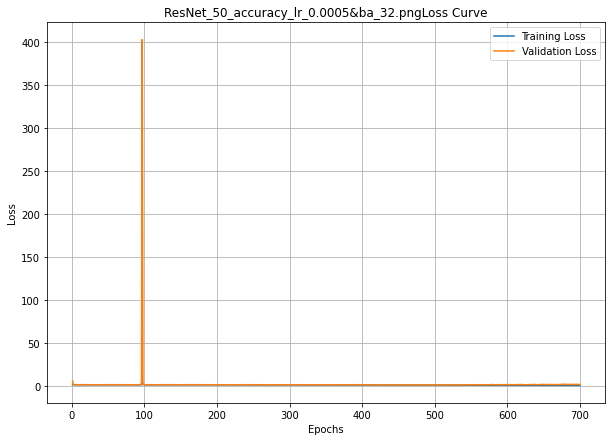

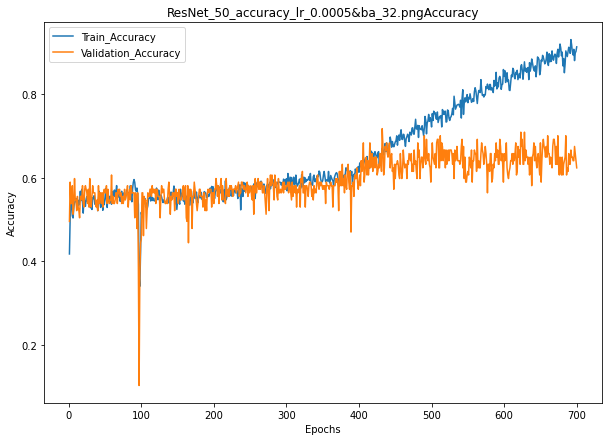

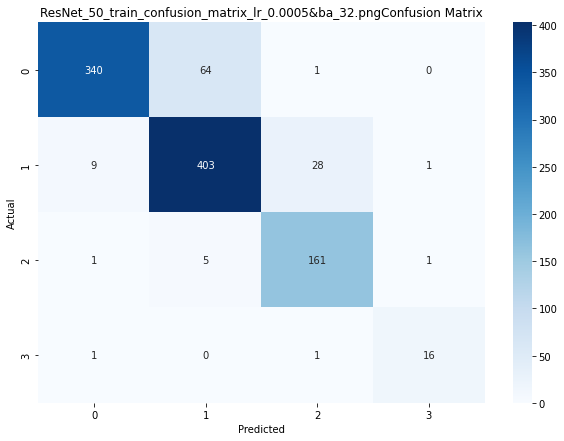

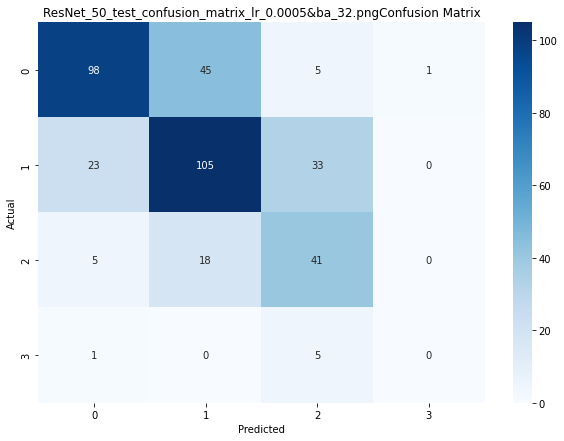

  0%|          | 0/33 [00:00<?, ?it/s]

701


Epoch train [701/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.26]


Training Loss: 0.2639
Training Accuracy: 0.9021


Epoch val [701/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=1.12]


Validation Loss: 1.4056
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

702


Epoch train [702/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.22]


Training Loss: 0.2252
Training Accuracy: 0.9099


Epoch val [702/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=1.11]


Validation Loss: 1.3878
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

703


Epoch train [703/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.25]


Training Loss: 0.2586
Training Accuracy: 0.9089


Epoch val [703/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=1.04]


Validation Loss: 1.2971
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

704


Epoch train [704/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.23]


Training Loss: 0.2383
Training Accuracy: 0.9205


Epoch val [704/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=1.26]


Validation Loss: 1.5749
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

705


Epoch train [705/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.26]


Training Loss: 0.2687
Training Accuracy: 0.8905


Epoch val [705/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=1.09]


Validation Loss: 1.3586
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

706


Epoch train [706/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.24]


Training Loss: 0.2439
Training Accuracy: 0.9050


Epoch val [706/100]: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, loss=1.34]


Validation Loss: 1.6797
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

707


Epoch train [707/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.22]


Training Loss: 0.2313
Training Accuracy: 0.9041


Epoch val [707/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=1.39]


Validation Loss: 1.7314
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

708


Epoch train [708/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.23]


Training Loss: 0.2364
Training Accuracy: 0.9012


Epoch val [708/100]: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, loss=1.12]


Validation Loss: 1.4035
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

709


Epoch train [709/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.22]


Training Loss: 0.2220
Training Accuracy: 0.9079


Epoch val [709/100]: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=1.20]


Validation Loss: 1.5027
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

710


Epoch train [710/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.22]


Training Loss: 0.2290
Training Accuracy: 0.9031


Epoch val [710/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=1.17]


Validation Loss: 1.4672
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

711


Epoch train [711/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.22]


Training Loss: 0.2236
Training Accuracy: 0.9128


Epoch val [711/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=1.35]


Validation Loss: 1.6917
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

712


Epoch train [712/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.20]


Training Loss: 0.2087
Training Accuracy: 0.9147


Epoch val [712/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=1.38]


Validation Loss: 1.7211
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

713


Epoch train [713/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.21]


Training Loss: 0.2178
Training Accuracy: 0.9118


Epoch val [713/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=1.36]


Validation Loss: 1.7047
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

714


Epoch train [714/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.21]


Training Loss: 0.2213
Training Accuracy: 0.9070


Epoch val [714/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=1.67]


Validation Loss: 2.0853
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

715


Epoch train [715/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.24]


Training Loss: 0.2464
Training Accuracy: 0.9118


Epoch val [715/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=1.31]


Validation Loss: 1.6352
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

716


Epoch train [716/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.19]


Training Loss: 0.2000
Training Accuracy: 0.9225


Epoch val [716/100]: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=1.14]


Validation Loss: 1.4195
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

717


Epoch train [717/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.18]


Training Loss: 0.1897
Training Accuracy: 0.9225


Epoch val [717/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=1.17]


Validation Loss: 1.4668
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

718


Epoch train [718/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.22]


Training Loss: 0.2247
Training Accuracy: 0.9147


Epoch val [718/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=1.10]


Validation Loss: 1.3805
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

719


Epoch train [719/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.22]


Training Loss: 0.2270
Training Accuracy: 0.9186


Epoch val [719/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=1.28]


Validation Loss: 1.5972
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

720


Epoch train [720/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.18]


Training Loss: 0.1845
Training Accuracy: 0.9283


Epoch val [720/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=1.21]


Validation Loss: 1.5175
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

721


Epoch train [721/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.18]


Training Loss: 0.1877
Training Accuracy: 0.9254


Epoch val [721/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=1.11]


Validation Loss: 1.3835
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

722


Epoch train [722/100]: 100%|██████████| 33/33 [00:12<00:00,  2.74it/s, loss=0.18]


Training Loss: 0.1813
Training Accuracy: 0.9244


Epoch val [722/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=1.59]


Validation Loss: 1.9864
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

723


Epoch train [723/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.21]


Training Loss: 0.2117
Training Accuracy: 0.9147


Epoch val [723/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=1.36]


Validation Loss: 1.6951
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

724


Epoch train [724/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.21]


Training Loss: 0.2171
Training Accuracy: 0.9186


Epoch val [724/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=1.18]


Validation Loss: 1.4697
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

725


Epoch train [725/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.19]


Training Loss: 0.1951
Training Accuracy: 0.9302


Epoch val [725/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=1.60]


Validation Loss: 1.9999
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

726


Epoch train [726/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.24]


Training Loss: 0.2455
Training Accuracy: 0.9060


Epoch val [726/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=1.35]


Validation Loss: 1.6818
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

727


Epoch train [727/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.23]


Training Loss: 0.2348
Training Accuracy: 0.9167


Epoch val [727/100]: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=1.40]


Validation Loss: 1.7530
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

728


Epoch train [728/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.20]


Training Loss: 0.2039
Training Accuracy: 0.9167


Epoch val [728/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=1.42]


Validation Loss: 1.7742
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

729


Epoch train [729/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.22]


Training Loss: 0.2278
Training Accuracy: 0.9186


Epoch val [729/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=1.30]


Validation Loss: 1.6247
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

730


Epoch train [730/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.22]


Training Loss: 0.2224
Training Accuracy: 0.9109


Epoch val [730/100]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=1.49]


Validation Loss: 1.8673
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

731


Epoch train [731/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.21]


Training Loss: 0.2154
Training Accuracy: 0.9254


Epoch val [731/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=1.48]


Validation Loss: 1.8513
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

732


Epoch train [732/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.21]


Training Loss: 0.2130
Training Accuracy: 0.9147


Epoch val [732/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=1.18]


Validation Loss: 1.4766
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

733


Epoch train [733/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.23]


Training Loss: 0.2340
Training Accuracy: 0.9099


Epoch val [733/100]: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s, loss=1.36]


Validation Loss: 1.6940
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

734


Epoch train [734/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.29]


Training Loss: 0.2957
Training Accuracy: 0.9021


Epoch val [734/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=1.71]


Validation Loss: 2.1369
Validation Accuracy: 0.5299


  0%|          | 0/33 [00:00<?, ?it/s]

735


Epoch train [735/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.22]


Training Loss: 0.2273
Training Accuracy: 0.9215


Epoch val [735/100]: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s, loss=1.57]


Validation Loss: 1.9576
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

736


Epoch train [736/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.23]


Training Loss: 0.2380
Training Accuracy: 0.9196


Epoch val [736/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=1.70]


Validation Loss: 2.1264
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

737


Epoch train [737/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.30]


Training Loss: 0.3040
Training Accuracy: 0.8895


Epoch val [737/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=1.47]


Validation Loss: 1.8385
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

738


Epoch train [738/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.31]


Training Loss: 0.3192
Training Accuracy: 0.8828


Epoch val [738/100]: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=1.18]


Validation Loss: 1.4800
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

739


Epoch train [739/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.23]


Training Loss: 0.2405
Training Accuracy: 0.9089


Epoch val [739/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=1.34]


Validation Loss: 1.6783
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

740


Epoch train [740/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.20]


Training Loss: 0.2060
Training Accuracy: 0.9293


Epoch val [740/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=1.44]


Validation Loss: 1.8000
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

741


Epoch train [741/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.19]


Training Loss: 0.1968
Training Accuracy: 0.9205


Epoch val [741/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=1.33]


Validation Loss: 1.6622
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

742


Epoch train [742/100]: 100%|██████████| 33/33 [00:12<00:00,  2.54it/s, loss=0.21]


Training Loss: 0.2127
Training Accuracy: 0.9205


Epoch val [742/100]: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, loss=1.34]


Validation Loss: 1.6714
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

743


Epoch train [743/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.17]


Training Loss: 0.1753
Training Accuracy: 0.9380


Epoch val [743/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=1.73]


Validation Loss: 2.1665
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

744


Epoch train [744/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.18]


Training Loss: 0.1891
Training Accuracy: 0.9322


Epoch val [744/100]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=1.30]


Validation Loss: 1.6193
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

745


Epoch train [745/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.24]


Training Loss: 0.2442
Training Accuracy: 0.9099


Epoch val [745/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=1.28]


Validation Loss: 1.6045
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

746


Epoch train [746/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.23]


Training Loss: 0.2369
Training Accuracy: 0.9138


Epoch val [746/100]: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s, loss=1.28]


Validation Loss: 1.5964
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

747


Epoch train [747/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.20]


Training Loss: 0.2026
Training Accuracy: 0.9264


Epoch val [747/100]: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=1.17]


Validation Loss: 1.4652
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

748


Epoch train [748/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.19]


Training Loss: 0.1937
Training Accuracy: 0.9312


Epoch val [748/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=1.22]


Validation Loss: 1.5209
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

749


Epoch train [749/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.22]


Training Loss: 0.2260
Training Accuracy: 0.9128


Epoch val [749/100]: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=1.25]


Validation Loss: 1.5687
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

750


Epoch train [750/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.20]


Training Loss: 0.2045
Training Accuracy: 0.9244


Epoch val [750/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=1.64]


Validation Loss: 2.0462
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

751


Epoch train [751/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.23]


Training Loss: 0.2417
Training Accuracy: 0.9089


Epoch val [751/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=1.34]


Validation Loss: 1.6727
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

752


Epoch train [752/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.20]


Training Loss: 0.2057
Training Accuracy: 0.9254


Epoch val [752/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=1.18]


Validation Loss: 1.4778
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

753


Epoch train [753/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.20]


Training Loss: 0.2046
Training Accuracy: 0.9254


Epoch val [753/100]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=1.16]


Validation Loss: 1.4467
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

754


Epoch train [754/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.16]


Training Loss: 0.1649
Training Accuracy: 0.9322


Epoch val [754/100]: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=1.16]


Validation Loss: 1.4492
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

755


Epoch train [755/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.17]


Training Loss: 0.1713
Training Accuracy: 0.9438


Epoch val [755/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=1.59]


Validation Loss: 1.9827
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

756


Epoch train [756/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.17]


Training Loss: 0.1757
Training Accuracy: 0.9448


Epoch val [756/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=1.42]


Validation Loss: 1.7718
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

757


Epoch train [757/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.20]


Training Loss: 0.2018
Training Accuracy: 0.9157


Epoch val [757/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=1.50]


Validation Loss: 1.8719
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

758


Epoch train [758/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.16]


Training Loss: 0.1611
Training Accuracy: 0.9360


Epoch val [758/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=1.50]


Validation Loss: 1.8793
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

759


Epoch train [759/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.16]


Training Loss: 0.1659
Training Accuracy: 0.9341


Epoch val [759/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=1.47]


Validation Loss: 1.8369
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

760


Epoch train [760/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.16]


Training Loss: 0.1626
Training Accuracy: 0.9283


Epoch val [760/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=1.24]


Validation Loss: 1.5489
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

761


Epoch train [761/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.15]


Training Loss: 0.1556
Training Accuracy: 0.9360


Epoch val [761/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=1.43]


Validation Loss: 1.7932
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

762


Epoch train [762/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.19]


Training Loss: 0.1945
Training Accuracy: 0.9283


Epoch val [762/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=1.40]


Validation Loss: 1.7542
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

763


Epoch train [763/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.17]


Training Loss: 0.1723
Training Accuracy: 0.9341


Epoch val [763/100]: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=1.58]


Validation Loss: 1.9742
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

764


Epoch train [764/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.18]


Training Loss: 0.1858
Training Accuracy: 0.9312


Epoch val [764/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=1.68]


Validation Loss: 2.1023
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

765


Epoch train [765/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.21]


Training Loss: 0.2113
Training Accuracy: 0.9205


Epoch val [765/100]: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, loss=1.31]


Validation Loss: 1.6407
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

766


Epoch train [766/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.17]


Training Loss: 0.1784
Training Accuracy: 0.9351


Epoch val [766/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=1.63]


Validation Loss: 2.0341
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

767


Epoch train [767/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.20]


Training Loss: 0.2048
Training Accuracy: 0.9331


Epoch val [767/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=1.36]


Validation Loss: 1.7030
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

768


Epoch train [768/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.21]


Training Loss: 0.2162
Training Accuracy: 0.9157


Epoch val [768/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=1.24]


Validation Loss: 1.5468
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

769


Epoch train [769/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.18]


Training Loss: 0.1861
Training Accuracy: 0.9254


Epoch val [769/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=1.38]


Validation Loss: 1.7280
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

770


Epoch train [770/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.15]


Training Loss: 0.1578
Training Accuracy: 0.9506


Epoch val [770/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=1.29]


Validation Loss: 1.6151
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

771


Epoch train [771/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.20]


Training Loss: 0.2012
Training Accuracy: 0.9312


Epoch val [771/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=1.59]


Validation Loss: 1.9913
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

772


Epoch train [772/100]: 100%|██████████| 33/33 [00:11<00:00,  2.95it/s, loss=0.21]


Training Loss: 0.2152
Training Accuracy: 0.9157


Epoch val [772/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=1.46]


Validation Loss: 1.8308
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

773


Epoch train [773/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.18]


Training Loss: 0.1832
Training Accuracy: 0.9293


Epoch val [773/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=1.41]


Validation Loss: 1.7657
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

774


Epoch train [774/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.16]


Training Loss: 0.1629
Training Accuracy: 0.9428


Epoch val [774/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=1.60]


Validation Loss: 1.9983
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

775


Epoch train [775/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.23]


Training Loss: 0.2322
Training Accuracy: 0.9254


Epoch val [775/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=1.32]


Validation Loss: 1.6465
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

776


Epoch train [776/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.19]


Training Loss: 0.2009
Training Accuracy: 0.9225


Epoch val [776/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=1.13]


Validation Loss: 1.4145
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

777


Epoch train [777/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.16]


Training Loss: 0.1634
Training Accuracy: 0.9399


Epoch val [777/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=1.44]


Validation Loss: 1.7966
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

778


Epoch train [778/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.18]


Training Loss: 0.1822
Training Accuracy: 0.9448


Epoch val [778/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=2.10]


Validation Loss: 2.6223
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

779


Epoch train [779/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.43]


Training Loss: 0.4452
Training Accuracy: 0.8566


Epoch val [779/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=1.17]


Validation Loss: 1.4625
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

780


Epoch train [780/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.24]


Training Loss: 0.2508
Training Accuracy: 0.9128


Epoch val [780/100]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=1.14]


Validation Loss: 1.4255
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

781


Epoch train [781/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.19]


Training Loss: 0.1926
Training Accuracy: 0.9215


Epoch val [781/100]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, loss=1.33]


Validation Loss: 1.6684
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

782


Epoch train [782/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.22]


Training Loss: 0.2266
Training Accuracy: 0.9128


Epoch val [782/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=1.42]


Validation Loss: 1.7754
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

783


Epoch train [783/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.22]


Training Loss: 0.2239
Training Accuracy: 0.9118


Epoch val [783/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=1.10]


Validation Loss: 1.3783
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

784


Epoch train [784/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.18]


Training Loss: 0.1824
Training Accuracy: 0.9351


Epoch val [784/100]: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=1.41]


Validation Loss: 1.7597
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

785


Epoch train [785/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.15]


Training Loss: 0.1545
Training Accuracy: 0.9409


Epoch val [785/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=1.54]


Validation Loss: 1.9219
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

786


Epoch train [786/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.12]


Training Loss: 0.1269
Training Accuracy: 0.9506


Epoch val [786/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=1.42]


Validation Loss: 1.7689
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

787


Epoch train [787/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.12]


Training Loss: 0.1216
Training Accuracy: 0.9554


Epoch val [787/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=1.31]


Validation Loss: 1.6421
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

788


Epoch train [788/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.12]


Training Loss: 0.1210
Training Accuracy: 0.9535


Epoch val [788/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=1.61]


Validation Loss: 2.0150
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

789


Epoch train [789/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.15]


Training Loss: 0.1539
Training Accuracy: 0.9341


Epoch val [789/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=1.37]


Validation Loss: 1.7163
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

790


Epoch train [790/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.15]


Training Loss: 0.1537
Training Accuracy: 0.9448


Epoch val [790/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=1.26]


Validation Loss: 1.5731
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

791


Epoch train [791/100]: 100%|██████████| 33/33 [00:11<00:00,  2.96it/s, loss=0.16]


Training Loss: 0.1666
Training Accuracy: 0.9419


Epoch val [791/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=1.43]


Validation Loss: 1.7933
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

792


Epoch train [792/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.09]


Training Loss: 0.0893
Training Accuracy: 0.9680


Epoch val [792/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=1.96]


Validation Loss: 2.4502
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

793


Epoch train [793/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.14]


Training Loss: 0.1481
Training Accuracy: 0.9574


Epoch val [793/100]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, loss=1.57]


Validation Loss: 1.9651
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

794


Epoch train [794/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.18]


Training Loss: 0.1869
Training Accuracy: 0.9312


Epoch val [794/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=1.47]


Validation Loss: 1.8325
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

795


Epoch train [795/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.19]


Training Loss: 0.1941
Training Accuracy: 0.9322


Epoch val [795/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=1.55]


Validation Loss: 1.9355
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

796


Epoch train [796/100]: 100%|██████████| 33/33 [00:11<00:00,  2.96it/s, loss=0.19]


Training Loss: 0.1957
Training Accuracy: 0.9390


Epoch val [796/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=1.56]


Validation Loss: 1.9543
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

797


Epoch train [797/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.18]


Training Loss: 0.1877
Training Accuracy: 0.9341


Epoch val [797/100]: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s, loss=1.48]


Validation Loss: 1.8460
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

798


Epoch train [798/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.19]


Training Loss: 0.1978
Training Accuracy: 0.9283


Epoch val [798/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=1.43]


Validation Loss: 1.7885
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

799


Epoch train [799/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.16]


Training Loss: 0.1630
Training Accuracy: 0.9428


Epoch val [799/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=1.36]


Validation Loss: 1.6946
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

800


Epoch train [800/100]: 100%|██████████| 33/33 [00:10<00:00,  3.01it/s, loss=0.12]


Training Loss: 0.1243
Training Accuracy: 0.9622


Epoch val [800/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=1.55]


Validation Loss: 1.9424
Validation Accuracy: 0.6581


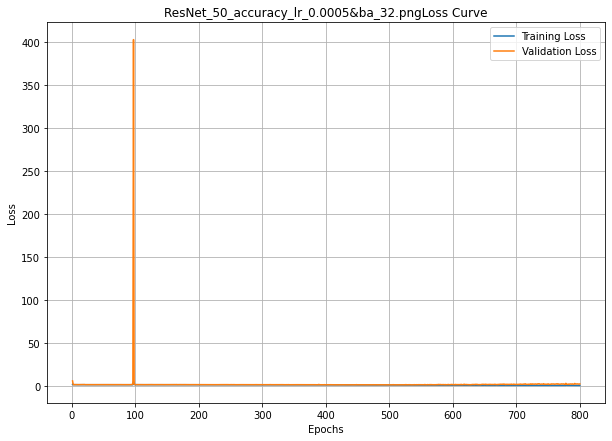

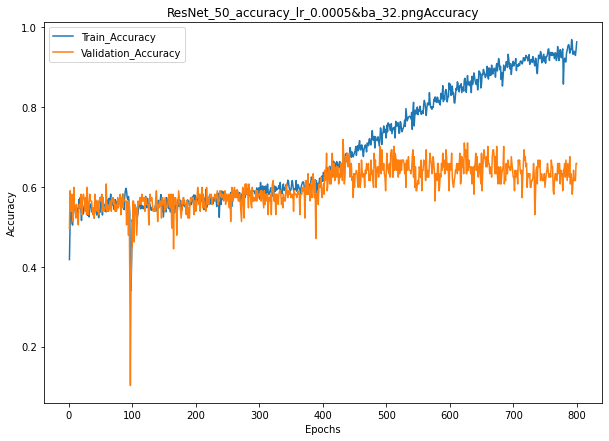

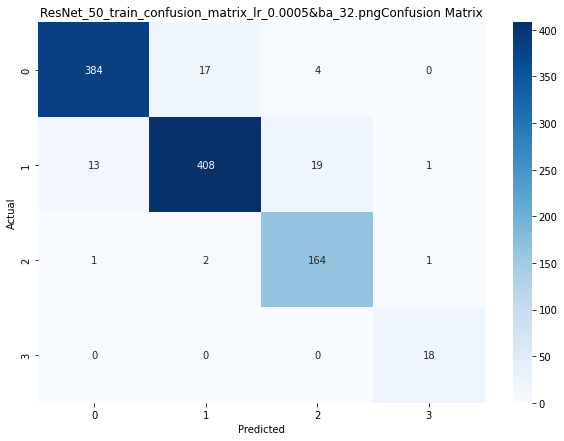

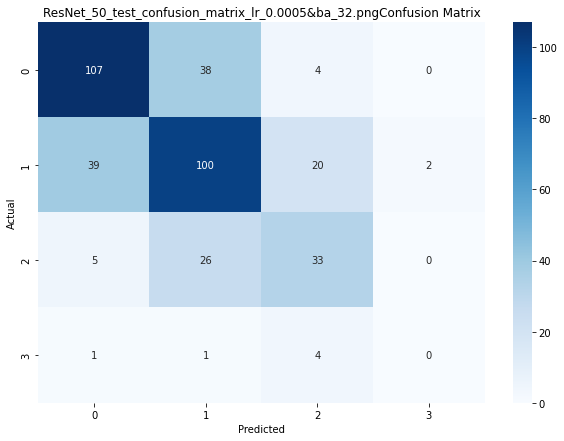

  0%|          | 0/33 [00:00<?, ?it/s]

801


Epoch train [801/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.17]


Training Loss: 0.1729
Training Accuracy: 0.9312


Epoch val [801/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=1.48]


Validation Loss: 1.8486
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

802


Epoch train [802/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.13]


Training Loss: 0.1380
Training Accuracy: 0.9516


Epoch val [802/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=1.39]


Validation Loss: 1.7433
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

803


Epoch train [803/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.13]


Training Loss: 0.1344
Training Accuracy: 0.9457


Epoch val [803/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=1.56]


Validation Loss: 1.9510
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

804


Epoch train [804/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.10]


Training Loss: 0.1071
Training Accuracy: 0.9651


Epoch val [804/100]: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=1.37]


Validation Loss: 1.7066
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

805


Epoch train [805/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.18]


Training Loss: 0.1892
Training Accuracy: 0.9380


Epoch val [805/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=1.47]


Validation Loss: 1.8335
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

806


Epoch train [806/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.15]


Training Loss: 0.1520
Training Accuracy: 0.9496


Epoch val [806/100]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s, loss=1.57]


Validation Loss: 1.9619
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

807


Epoch train [807/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.11]


Training Loss: 0.1088
Training Accuracy: 0.9583


Epoch val [807/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=1.71]


Validation Loss: 2.1427
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

808


Epoch train [808/100]: 100%|██████████| 33/33 [00:11<00:00,  2.94it/s, loss=0.13]


Training Loss: 0.1351
Training Accuracy: 0.9516


Epoch val [808/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=1.54]


Validation Loss: 1.9310
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

809


Epoch train [809/100]: 100%|██████████| 33/33 [00:11<00:00,  2.99it/s, loss=0.19]


Training Loss: 0.1980
Training Accuracy: 0.9312


Epoch val [809/100]: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=1.37]


Validation Loss: 1.7138
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

810


Epoch train [810/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.16]


Training Loss: 0.1620
Training Accuracy: 0.9428


Epoch val [810/100]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, loss=1.41]


Validation Loss: 1.7657
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

811


Epoch train [811/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.16]


Training Loss: 0.1673
Training Accuracy: 0.9428


Epoch val [811/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=1.76]


Validation Loss: 2.1957
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

812


Epoch train [812/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.12]


Training Loss: 0.1214
Training Accuracy: 0.9554


Epoch val [812/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=1.40]


Validation Loss: 1.7515
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

813


Epoch train [813/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.12]


Training Loss: 0.1274
Training Accuracy: 0.9516


Epoch val [813/100]: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=1.23]


Validation Loss: 1.5415
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

814


Epoch train [814/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.12]


Training Loss: 0.1220
Training Accuracy: 0.9486


Epoch val [814/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=1.46]


Validation Loss: 1.8232
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

815


Epoch train [815/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.15]


Training Loss: 0.1525
Training Accuracy: 0.9564


Epoch val [815/100]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s, loss=1.65]


Validation Loss: 2.0636
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

816


Epoch train [816/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.14]


Training Loss: 0.1477
Training Accuracy: 0.9399


Epoch val [816/100]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=1.27]


Validation Loss: 1.5872
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

817


Epoch train [817/100]: 100%|██████████| 33/33 [00:11<00:00,  2.97it/s, loss=0.17]


Training Loss: 0.1738
Training Accuracy: 0.9370


Epoch val [817/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=1.43]


Validation Loss: 1.7819
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

818


Epoch train [818/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.12]


Training Loss: 0.1225
Training Accuracy: 0.9554


Epoch val [818/100]: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, loss=1.62]


Validation Loss: 2.0288
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

819


Epoch train [819/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.14]


Training Loss: 0.1487
Training Accuracy: 0.9477


Epoch val [819/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=1.35]


Validation Loss: 1.6887
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

820


Epoch train [820/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.12]


Training Loss: 0.1276
Training Accuracy: 0.9506


Epoch val [820/100]: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s, loss=1.62]


Validation Loss: 2.0277
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

821


Epoch train [821/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.11]


Training Loss: 0.1133
Training Accuracy: 0.9593


Epoch val [821/100]: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, loss=1.65]


Validation Loss: 2.0593
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

822


Epoch train [822/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.12]


Training Loss: 0.1251
Training Accuracy: 0.9535


Epoch val [822/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=2.05]


Validation Loss: 2.5606
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

823


Epoch train [823/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.16]


Training Loss: 0.1649
Training Accuracy: 0.9331


Epoch val [823/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=1.44]


Validation Loss: 1.7979
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

824


Epoch train [824/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.12]


Training Loss: 0.1232
Training Accuracy: 0.9680


Epoch val [824/100]: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=1.75]


Validation Loss: 2.1893
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

825


Epoch train [825/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.13]


Training Loss: 0.1341
Training Accuracy: 0.9525


Epoch val [825/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=1.55]


Validation Loss: 1.9393
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

826


Epoch train [826/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.12]


Training Loss: 0.1217
Training Accuracy: 0.9535


Epoch val [826/100]: 100%|██████████| 4/4 [00:00<00:00,  6.88it/s, loss=1.26]


Validation Loss: 1.5748
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

827


Epoch train [827/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.13]


Training Loss: 0.1374
Training Accuracy: 0.9564


Epoch val [827/100]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=1.46]


Validation Loss: 1.8295
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

828


Epoch train [828/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.10]


Training Loss: 0.1035
Training Accuracy: 0.9612


Epoch val [828/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=1.37]


Validation Loss: 1.7124
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

829


Epoch train [829/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.15]


Training Loss: 0.1528
Training Accuracy: 0.9457


Epoch val [829/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=1.53]


Validation Loss: 1.9115
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

830


Epoch train [830/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.17]


Training Loss: 0.1781
Training Accuracy: 0.9390


Epoch val [830/100]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s, loss=1.71]


Validation Loss: 2.1319
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

831


Epoch train [831/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.13]


Training Loss: 0.1344
Training Accuracy: 0.9506


Epoch val [831/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=1.46]


Validation Loss: 1.8211
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

832


Epoch train [832/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.09]


Training Loss: 0.0939
Training Accuracy: 0.9671


Epoch val [832/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=1.86]


Validation Loss: 2.3231
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

833


Epoch train [833/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.17]


Training Loss: 0.1734
Training Accuracy: 0.9370


Epoch val [833/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=1.97]


Validation Loss: 2.4684
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

834


Epoch train [834/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.10]


Training Loss: 0.1043
Training Accuracy: 0.9603


Epoch val [834/100]: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s, loss=1.56]


Validation Loss: 1.9536
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

835


Epoch train [835/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.09]


Training Loss: 0.0977
Training Accuracy: 0.9632


Epoch val [835/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=1.74]


Validation Loss: 2.1770
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

836


Epoch train [836/100]: 100%|██████████| 33/33 [00:11<00:00,  2.96it/s, loss=0.11]


Training Loss: 0.1145
Training Accuracy: 0.9603


Epoch val [836/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=1.93]


Validation Loss: 2.4094
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

837


Epoch train [837/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.11]


Training Loss: 0.1144
Training Accuracy: 0.9554


Epoch val [837/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=1.84]


Validation Loss: 2.3024
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

838


Epoch train [838/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.12]


Training Loss: 0.1239
Training Accuracy: 0.9574


Epoch val [838/100]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=1.96]


Validation Loss: 2.4552
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

839


Epoch train [839/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.16]


Training Loss: 0.1625
Training Accuracy: 0.9574


Epoch val [839/100]: 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, loss=1.78]


Validation Loss: 2.2295
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

840


Epoch train [840/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.23]


Training Loss: 0.2336
Training Accuracy: 0.9312


Epoch val [840/100]: 100%|██████████| 4/4 [00:00<00:00,  6.64it/s, loss=1.73]


Validation Loss: 2.1573
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

841


Epoch train [841/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.18]


Training Loss: 0.1820
Training Accuracy: 0.9351


Epoch val [841/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=1.56]


Validation Loss: 1.9517
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

842


Epoch train [842/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.15]


Training Loss: 0.1502
Training Accuracy: 0.9554


Epoch val [842/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=1.51]


Validation Loss: 1.8920
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

843


Epoch train [843/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.18]


Training Loss: 0.1862
Training Accuracy: 0.9283


Epoch val [843/100]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, loss=1.94]


Validation Loss: 2.4266
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

844


Epoch train [844/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.14]


Training Loss: 0.1472
Training Accuracy: 0.9496


Epoch val [844/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=1.70]


Validation Loss: 2.1300
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

845


Epoch train [845/100]: 100%|██████████| 33/33 [00:11<00:00,  2.98it/s, loss=0.14]


Training Loss: 0.1431
Training Accuracy: 0.9438


Epoch val [845/100]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=1.76]


Validation Loss: 2.2056
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

846


Epoch train [846/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.14]


Training Loss: 0.1468
Training Accuracy: 0.9516


Epoch val [846/100]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=1.58]


Validation Loss: 1.9800
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

847


Epoch train [847/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.12]


Training Loss: 0.1189
Training Accuracy: 0.9545


Epoch val [847/100]: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, loss=1.92]


Validation Loss: 2.3942
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

848


Epoch train [848/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.13]


Training Loss: 0.1372
Training Accuracy: 0.9496


Epoch val [848/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=1.81]


Validation Loss: 2.2586
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

849


Epoch train [849/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.16]


Training Loss: 0.1656
Training Accuracy: 0.9370


Epoch val [849/100]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, loss=1.65]


Validation Loss: 2.0611
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

850


Epoch train [850/100]: 100%|██████████| 33/33 [00:11<00:00,  2.96it/s, loss=0.14]


Training Loss: 0.1430
Training Accuracy: 0.9525


Epoch val [850/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=1.45]


Validation Loss: 1.8186
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

851


Epoch train [851/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.14]


Training Loss: 0.1407
Training Accuracy: 0.9486


Epoch val [851/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=1.56]


Validation Loss: 1.9439
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

852


Epoch train [852/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.14]


Training Loss: 0.1443
Training Accuracy: 0.9535


Epoch val [852/100]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s, loss=1.67]


Validation Loss: 2.0830
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

853


Epoch train [853/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.17]


Training Loss: 0.1728
Training Accuracy: 0.9486


Epoch val [853/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=1.43]


Validation Loss: 1.7843
Validation Accuracy: 0.7094


  0%|          | 0/33 [00:00<?, ?it/s]

854


Epoch train [854/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.12]


Training Loss: 0.1213
Training Accuracy: 0.9603


Epoch val [854/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=1.47]


Validation Loss: 1.8348
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

855


Epoch train [855/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.14]


Training Loss: 0.1435
Training Accuracy: 0.9486


Epoch val [855/100]: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s, loss=1.60]


Validation Loss: 1.9959
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

856


Epoch train [856/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.12]


Training Loss: 0.1283
Training Accuracy: 0.9554


Epoch val [856/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=1.83]


Validation Loss: 2.2859
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

857


Epoch train [857/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.09]


Training Loss: 0.0965
Training Accuracy: 0.9622


Epoch val [857/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=2.32]


Validation Loss: 2.8992
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

858


Epoch train [858/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.15]


Training Loss: 0.1572
Training Accuracy: 0.9486


Epoch val [858/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=1.89]


Validation Loss: 2.3621
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

859


Epoch train [859/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.13]


Training Loss: 0.1300
Training Accuracy: 0.9545


Epoch val [859/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=1.54]


Validation Loss: 1.9219
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

860


Epoch train [860/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.07]


Training Loss: 0.0763
Training Accuracy: 0.9709


Epoch val [860/100]: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=1.88]


Validation Loss: 2.3540
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

861


Epoch train [861/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.12]


Training Loss: 0.1276
Training Accuracy: 0.9467


Epoch val [861/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=1.69]


Validation Loss: 2.1185
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

862


Epoch train [862/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.11]


Training Loss: 0.1172
Training Accuracy: 0.9583


Epoch val [862/100]: 100%|██████████| 4/4 [00:00<00:00,  5.79it/s, loss=1.62]


Validation Loss: 2.0301
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

863


Epoch train [863/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.13]


Training Loss: 0.1291
Training Accuracy: 0.9477


Epoch val [863/100]: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s, loss=2.02]


Validation Loss: 2.5253
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

864


Epoch train [864/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.09]


Training Loss: 0.0914
Training Accuracy: 0.9680


Epoch val [864/100]: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, loss=1.99]


Validation Loss: 2.4927
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

865


Epoch train [865/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.09]


Training Loss: 0.0976
Training Accuracy: 0.9583


Epoch val [865/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=2.06]


Validation Loss: 2.5766
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

866


Epoch train [866/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.13]


Training Loss: 0.1329
Training Accuracy: 0.9486


Epoch val [866/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=1.56]


Validation Loss: 1.9457
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

867


Epoch train [867/100]: 100%|██████████| 33/33 [00:12<00:00,  2.73it/s, loss=0.13]


Training Loss: 0.1319
Training Accuracy: 0.9506


Epoch val [867/100]: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, loss=1.75]


Validation Loss: 2.1856
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

868


Epoch train [868/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.15]


Training Loss: 0.1521
Training Accuracy: 0.9409


Epoch val [868/100]: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s, loss=1.36]


Validation Loss: 1.7028
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

869


Epoch train [869/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.14]


Training Loss: 0.1459
Training Accuracy: 0.9448


Epoch val [869/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=1.76]


Validation Loss: 2.1967
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

870


Epoch train [870/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.14]


Training Loss: 0.1462
Training Accuracy: 0.9486


Epoch val [870/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=1.30]


Validation Loss: 1.6189
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

871


Epoch train [871/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.11]


Training Loss: 0.1166
Training Accuracy: 0.9593


Epoch val [871/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=1.27]


Validation Loss: 1.5934
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

872


Epoch train [872/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.10]


Training Loss: 0.1035
Training Accuracy: 0.9574


Epoch val [872/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=1.55]


Validation Loss: 1.9437
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

873


Epoch train [873/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.16]


Training Loss: 0.1604
Training Accuracy: 0.9496


Epoch val [873/100]: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s, loss=1.33]


Validation Loss: 1.6637
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

874


Epoch train [874/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.16]


Training Loss: 0.1614
Training Accuracy: 0.9390


Epoch val [874/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=1.36]


Validation Loss: 1.7005
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

875


Epoch train [875/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.12]


Training Loss: 0.1204
Training Accuracy: 0.9593


Epoch val [875/100]: 100%|██████████| 4/4 [00:00<00:00,  5.74it/s, loss=1.34]


Validation Loss: 1.6771
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

876


Epoch train [876/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.09]


Training Loss: 0.0883
Training Accuracy: 0.9651


Epoch val [876/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=1.72]


Validation Loss: 2.1511
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

877


Epoch train [877/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.13]


Training Loss: 0.1339
Training Accuracy: 0.9516


Epoch val [877/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=1.61]


Validation Loss: 2.0100
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

878


Epoch train [878/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.12]


Training Loss: 0.1244
Training Accuracy: 0.9622


Epoch val [878/100]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s, loss=1.59]


Validation Loss: 1.9873
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

879


Epoch train [879/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.11]


Training Loss: 0.1147
Training Accuracy: 0.9554


Epoch val [879/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=1.63]


Validation Loss: 2.0427
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

880


Epoch train [880/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.13]


Training Loss: 0.1355
Training Accuracy: 0.9525


Epoch val [880/100]: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, loss=1.55]


Validation Loss: 1.9356
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

881


Epoch train [881/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.08]


Training Loss: 0.0810
Training Accuracy: 0.9729


Epoch val [881/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=1.76]


Validation Loss: 2.2009
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

882


Epoch train [882/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.07]


Training Loss: 0.0735
Training Accuracy: 0.9719


Epoch val [882/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=2.22]


Validation Loss: 2.7775
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

883


Epoch train [883/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.10]


Training Loss: 0.1010
Training Accuracy: 0.9651


Epoch val [883/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=1.77]


Validation Loss: 2.2183
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

884


Epoch train [884/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.14]


Training Loss: 0.1434
Training Accuracy: 0.9457


Epoch val [884/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=1.61]


Validation Loss: 2.0122
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

885


Epoch train [885/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.12]


Training Loss: 0.1189
Training Accuracy: 0.9603


Epoch val [885/100]: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, loss=1.86]


Validation Loss: 2.3236
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

886


Epoch train [886/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.15]


Training Loss: 0.1591
Training Accuracy: 0.9496


Epoch val [886/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=1.51]


Validation Loss: 1.8904
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

887


Epoch train [887/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.12]


Training Loss: 0.1220
Training Accuracy: 0.9545


Epoch val [887/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=1.82]


Validation Loss: 2.2747
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

888


Epoch train [888/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.14]


Training Loss: 0.1419
Training Accuracy: 0.9438


Epoch val [888/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=1.41]


Validation Loss: 1.7663
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

889


Epoch train [889/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.12]


Training Loss: 0.1252
Training Accuracy: 0.9593


Epoch val [889/100]: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, loss=2.18]


Validation Loss: 2.7285
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

890


Epoch train [890/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.13]


Training Loss: 0.1343
Training Accuracy: 0.9457


Epoch val [890/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=1.66]


Validation Loss: 2.0705
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

891


Epoch train [891/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.13]


Training Loss: 0.1354
Training Accuracy: 0.9496


Epoch val [891/100]: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s, loss=1.29]


Validation Loss: 1.6121
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

892


Epoch train [892/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.09]


Training Loss: 0.0889
Training Accuracy: 0.9651


Epoch val [892/100]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, loss=1.52]


Validation Loss: 1.9005
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

893


Epoch train [893/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.08]


Training Loss: 0.0822
Training Accuracy: 0.9671


Epoch val [893/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=2.30]


Validation Loss: 2.8757
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

894


Epoch train [894/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.12]


Training Loss: 0.1284
Training Accuracy: 0.9506


Epoch val [894/100]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=1.63]


Validation Loss: 2.0417
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

895


Epoch train [895/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.10]


Training Loss: 0.1046
Training Accuracy: 0.9632


Epoch val [895/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=1.77]


Validation Loss: 2.2126
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

896


Epoch train [896/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.09]


Training Loss: 0.0938
Training Accuracy: 0.9661


Epoch val [896/100]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s, loss=2.28]


Validation Loss: 2.8498
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

897


Epoch train [897/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.16]


Training Loss: 0.1604
Training Accuracy: 0.9448


Epoch val [897/100]: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s, loss=1.37]


Validation Loss: 1.7103
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

898


Epoch train [898/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.14]


Training Loss: 0.1473
Training Accuracy: 0.9448


Epoch val [898/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=1.65]


Validation Loss: 2.0645
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

899


Epoch train [899/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.10]


Training Loss: 0.1031
Training Accuracy: 0.9632


Epoch val [899/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=1.66]


Validation Loss: 2.0734
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

900


Epoch train [900/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.11]


Training Loss: 0.1104
Training Accuracy: 0.9603


Epoch val [900/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=2.09]


Validation Loss: 2.6099
Validation Accuracy: 0.5983


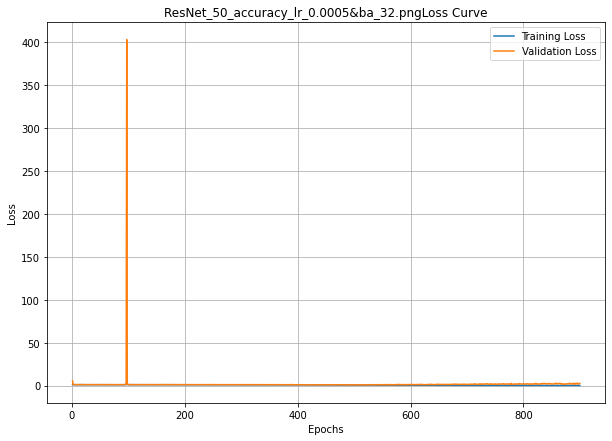

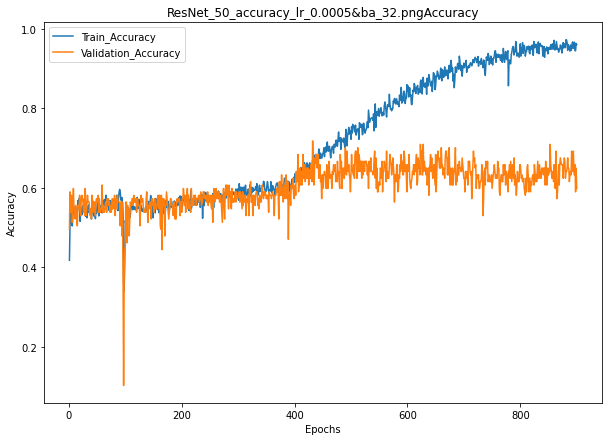

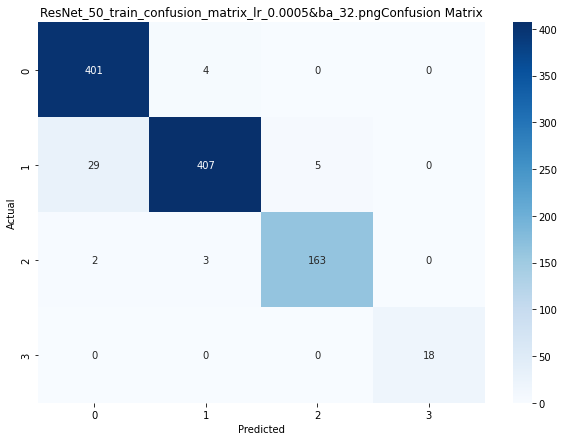

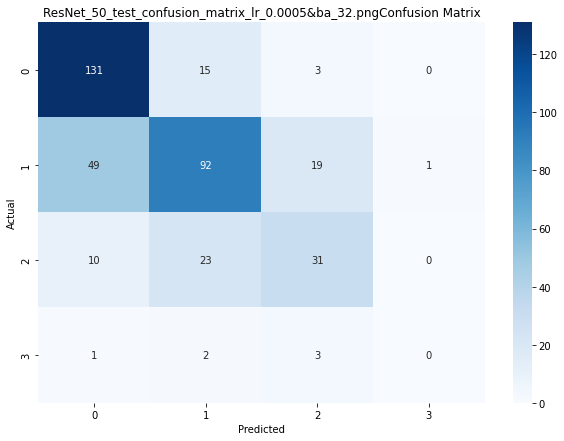

  0%|          | 0/33 [00:00<?, ?it/s]

901


Epoch train [901/100]: 100%|██████████| 33/33 [00:11<00:00,  2.76it/s, loss=0.10]


Training Loss: 0.1056
Training Accuracy: 0.9661


Epoch val [901/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=1.98]


Validation Loss: 2.4806
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

902


Epoch train [902/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.14]


Training Loss: 0.1439
Training Accuracy: 0.9554


Epoch val [902/100]: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s, loss=1.39]


Validation Loss: 1.7433
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

903


Epoch train [903/100]: 100%|██████████| 33/33 [00:11<00:00,  2.78it/s, loss=0.10]


Training Loss: 0.1055
Training Accuracy: 0.9603


Epoch val [903/100]: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s, loss=1.73]


Validation Loss: 2.1609
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

904


Epoch train [904/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.11]


Training Loss: 0.1146
Training Accuracy: 0.9632


Epoch val [904/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=1.35]


Validation Loss: 1.6887
Validation Accuracy: 0.7094


  0%|          | 0/33 [00:00<?, ?it/s]

905


Epoch train [905/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.13]


Training Loss: 0.1365
Training Accuracy: 0.9554


Epoch val [905/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=1.49]


Validation Loss: 1.8629
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

906


Epoch train [906/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.11]


Training Loss: 0.1098
Training Accuracy: 0.9680


Epoch val [906/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=1.47]


Validation Loss: 1.8398
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

907


Epoch train [907/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.18]


Training Loss: 0.1854
Training Accuracy: 0.9254


Epoch val [907/100]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s, loss=1.42]


Validation Loss: 1.7806
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

908


Epoch train [908/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.16]


Training Loss: 0.1627
Training Accuracy: 0.9457


Epoch val [908/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=1.48]


Validation Loss: 1.8514
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

909


Epoch train [909/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.12]


Training Loss: 0.1281
Training Accuracy: 0.9486


Epoch val [909/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=1.90]


Validation Loss: 2.3730
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

910


Epoch train [910/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.12]


Training Loss: 0.1193
Training Accuracy: 0.9574


Epoch val [910/100]: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, loss=1.85]


Validation Loss: 2.3088
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

911


Epoch train [911/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.11]


Training Loss: 0.1095
Training Accuracy: 0.9603


Epoch val [911/100]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=1.88]


Validation Loss: 2.3476
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

912


Epoch train [912/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.09]


Training Loss: 0.0906
Training Accuracy: 0.9661


Epoch val [912/100]: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=2.02]


Validation Loss: 2.5236
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

913


Epoch train [913/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.15]


Training Loss: 0.1557
Training Accuracy: 0.9535


Epoch val [913/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=1.60]


Validation Loss: 2.0059
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

914


Epoch train [914/100]: 100%|██████████| 33/33 [00:12<00:00,  2.67it/s, loss=0.16]


Training Loss: 0.1665
Training Accuracy: 0.9380


Epoch val [914/100]: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, loss=1.43]


Validation Loss: 1.7891
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

915


Epoch train [915/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.11]


Training Loss: 0.1082
Training Accuracy: 0.9574


Epoch val [915/100]: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s, loss=1.84]


Validation Loss: 2.3051
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

916


Epoch train [916/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.11]


Training Loss: 0.1113
Training Accuracy: 0.9603


Epoch val [916/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=1.78]


Validation Loss: 2.2234
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

917


Epoch train [917/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.10]


Training Loss: 0.0996
Training Accuracy: 0.9680


Epoch val [917/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=1.72]


Validation Loss: 2.1444
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

918


Epoch train [918/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.11]


Training Loss: 0.1094
Training Accuracy: 0.9593


Epoch val [918/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=1.78]


Validation Loss: 2.2244
Validation Accuracy: 0.5726


  0%|          | 0/33 [00:00<?, ?it/s]

919


Epoch train [919/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.10]


Training Loss: 0.1016
Training Accuracy: 0.9690


Epoch val [919/100]: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, loss=1.79]


Validation Loss: 2.2333
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

920


Epoch train [920/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.12]


Training Loss: 0.1210
Training Accuracy: 0.9545


Epoch val [920/100]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s, loss=1.86]


Validation Loss: 2.3239
Validation Accuracy: 0.5812


  0%|          | 0/33 [00:00<?, ?it/s]

921


Epoch train [921/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.08]


Training Loss: 0.0870
Training Accuracy: 0.9690


Epoch val [921/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=1.77]


Validation Loss: 2.2134
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

922


Epoch train [922/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.10]


Training Loss: 0.1002
Training Accuracy: 0.9661


Epoch val [922/100]: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s, loss=1.63]


Validation Loss: 2.0384
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

923


Epoch train [923/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.11]


Training Loss: 0.1183
Training Accuracy: 0.9603


Epoch val [923/100]: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, loss=1.72]


Validation Loss: 2.1538
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

924


Epoch train [924/100]: 100%|██████████| 33/33 [00:12<00:00,  2.68it/s, loss=0.08]


Training Loss: 0.0792
Training Accuracy: 0.9729


Epoch val [924/100]: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s, loss=2.04]


Validation Loss: 2.5472
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

925


Epoch train [925/100]: 100%|██████████| 33/33 [00:12<00:00,  2.72it/s, loss=0.12]


Training Loss: 0.1278
Training Accuracy: 0.9496


Epoch val [925/100]: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s, loss=1.71]


Validation Loss: 2.1356
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

926


Epoch train [926/100]: 100%|██████████| 33/33 [00:12<00:00,  2.70it/s, loss=0.12]


Training Loss: 0.1209
Training Accuracy: 0.9574


Epoch val [926/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=1.63]


Validation Loss: 2.0405
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

927


Epoch train [927/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.10]


Training Loss: 0.1035
Training Accuracy: 0.9612


Epoch val [927/100]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s, loss=1.73]


Validation Loss: 2.1665
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

928


Epoch train [928/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.10]


Training Loss: 0.0992
Training Accuracy: 0.9671


Epoch val [928/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=2.22]


Validation Loss: 2.7781
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

929


Epoch train [929/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.15]


Training Loss: 0.1504
Training Accuracy: 0.9506


Epoch val [929/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=1.45]


Validation Loss: 1.8081
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

930


Epoch train [930/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.09]


Training Loss: 0.0964
Training Accuracy: 0.9622


Epoch val [930/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=1.76]


Validation Loss: 2.2015
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

931


Epoch train [931/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.07]


Training Loss: 0.0710
Training Accuracy: 0.9719


Epoch val [931/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=1.80]


Validation Loss: 2.2504
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

932


Epoch train [932/100]: 100%|██████████| 33/33 [00:12<00:00,  2.71it/s, loss=0.07]


Training Loss: 0.0672
Training Accuracy: 0.9719


Epoch val [932/100]: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s, loss=2.05]


Validation Loss: 2.5601
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

933


Epoch train [933/100]: 100%|██████████| 33/33 [00:11<00:00,  2.77it/s, loss=0.09]


Training Loss: 0.0888
Training Accuracy: 0.9719


Epoch val [933/100]: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, loss=1.70]


Validation Loss: 2.1210
Validation Accuracy: 0.7179


  0%|          | 0/33 [00:00<?, ?it/s]

934


Epoch train [934/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.11]


Training Loss: 0.1117
Training Accuracy: 0.9690


Epoch val [934/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=1.74]


Validation Loss: 2.1801
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

935


Epoch train [935/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.08]


Training Loss: 0.0874
Training Accuracy: 0.9729


Epoch val [935/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=1.35]


Validation Loss: 1.6925
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

936


Epoch train [936/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.10]


Training Loss: 0.1038
Training Accuracy: 0.9632


Epoch val [936/100]: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=1.73]


Validation Loss: 2.1580
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

937


Epoch train [937/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.10]


Training Loss: 0.1024
Training Accuracy: 0.9622


Epoch val [937/100]: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, loss=1.48]


Validation Loss: 1.8480
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

938


Epoch train [938/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.07]


Training Loss: 0.0769
Training Accuracy: 0.9690


Epoch val [938/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=1.97]


Validation Loss: 2.4676
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

939


Epoch train [939/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.07]


Training Loss: 0.0749
Training Accuracy: 0.9729


Epoch val [939/100]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s, loss=1.84]


Validation Loss: 2.2944
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

940


Epoch train [940/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.08]


Training Loss: 0.0789
Training Accuracy: 0.9729


Epoch val [940/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=1.67]


Validation Loss: 2.0834
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

941


Epoch train [941/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.07]


Training Loss: 0.0676
Training Accuracy: 0.9806


Epoch val [941/100]: 100%|██████████| 4/4 [00:00<00:00,  6.82it/s, loss=2.08]


Validation Loss: 2.6013
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

942


Epoch train [942/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.11]


Training Loss: 0.1145
Training Accuracy: 0.9651


Epoch val [942/100]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s, loss=1.95]


Validation Loss: 2.4433
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

943


Epoch train [943/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.08]


Training Loss: 0.0799
Training Accuracy: 0.9671


Epoch val [943/100]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s, loss=1.97]


Validation Loss: 2.4676
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

944


Epoch train [944/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.11]


Training Loss: 0.1173
Training Accuracy: 0.9680


Epoch val [944/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=2.12]


Validation Loss: 2.6452
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

945


Epoch train [945/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.18]


Training Loss: 0.1824
Training Accuracy: 0.9409


Epoch val [945/100]: 100%|██████████| 4/4 [00:00<00:00,  6.98it/s, loss=1.50]


Validation Loss: 1.8705
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

946


Epoch train [946/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.13]


Training Loss: 0.1297
Training Accuracy: 0.9574


Epoch val [946/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=1.51]


Validation Loss: 1.8884
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

947


Epoch train [947/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.11]


Training Loss: 0.1139
Training Accuracy: 0.9583


Epoch val [947/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=2.25]


Validation Loss: 2.8139
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

948


Epoch train [948/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.09]


Training Loss: 0.0970
Training Accuracy: 0.9632


Epoch val [948/100]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=1.95]


Validation Loss: 2.4370
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

949


Epoch train [949/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.09]


Training Loss: 0.0924
Training Accuracy: 0.9661


Epoch val [949/100]: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, loss=1.84]


Validation Loss: 2.3014
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

950


Epoch train [950/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.20]


Training Loss: 0.2072
Training Accuracy: 0.9341


Epoch val [950/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=1.83]


Validation Loss: 2.2887
Validation Accuracy: 0.6239


  0%|          | 0/33 [00:00<?, ?it/s]

951


Epoch train [951/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.14]


Training Loss: 0.1427
Training Accuracy: 0.9438


Epoch val [951/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=1.86]


Validation Loss: 2.3271
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

952


Epoch train [952/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.10]


Training Loss: 0.1066
Training Accuracy: 0.9622


Epoch val [952/100]: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s, loss=2.13]


Validation Loss: 2.6648
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

953


Epoch train [953/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.10]


Training Loss: 0.1035
Training Accuracy: 0.9690


Epoch val [953/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=1.72]


Validation Loss: 2.1457
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

954


Epoch train [954/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.09]


Training Loss: 0.0934
Training Accuracy: 0.9680


Epoch val [954/100]: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s, loss=2.32]


Validation Loss: 2.8954
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

955


Epoch train [955/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.07]


Training Loss: 0.0713
Training Accuracy: 0.9729


Epoch val [955/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=2.07]


Validation Loss: 2.5861
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

956


Epoch train [956/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.07]


Training Loss: 0.0716
Training Accuracy: 0.9729


Epoch val [956/100]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s, loss=1.73]


Validation Loss: 2.1668
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

957


Epoch train [957/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.09]


Training Loss: 0.0881
Training Accuracy: 0.9680


Epoch val [957/100]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, loss=2.05]


Validation Loss: 2.5575
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

958


Epoch train [958/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.10]


Training Loss: 0.0992
Training Accuracy: 0.9651


Epoch val [958/100]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=2.09]


Validation Loss: 2.6066
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

959


Epoch train [959/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.09]


Training Loss: 0.0927
Training Accuracy: 0.9651


Epoch val [959/100]: 100%|██████████| 4/4 [00:00<00:00,  6.54it/s, loss=2.17]


Validation Loss: 2.7122
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

960


Epoch train [960/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.06]


Training Loss: 0.0608
Training Accuracy: 0.9797


Epoch val [960/100]: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, loss=2.13]


Validation Loss: 2.6640
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

961


Epoch train [961/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.08]


Training Loss: 0.0863
Training Accuracy: 0.9758


Epoch val [961/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=1.87]


Validation Loss: 2.3423
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

962


Epoch train [962/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.07]


Training Loss: 0.0756
Training Accuracy: 0.9835


Epoch val [962/100]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s, loss=2.35]


Validation Loss: 2.9387
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

963


Epoch train [963/100]: 100%|██████████| 33/33 [00:11<00:00,  2.92it/s, loss=0.11]


Training Loss: 0.1085
Training Accuracy: 0.9603


Epoch val [963/100]: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, loss=2.04]


Validation Loss: 2.5543
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

964


Epoch train [964/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.12]


Training Loss: 0.1264
Training Accuracy: 0.9593


Epoch val [964/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=1.63]


Validation Loss: 2.0393
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

965


Epoch train [965/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.05]


Training Loss: 0.0564
Training Accuracy: 0.9797


Epoch val [965/100]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s, loss=2.11]


Validation Loss: 2.6322
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

966


Epoch train [966/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.05]


Training Loss: 0.0525
Training Accuracy: 0.9787


Epoch val [966/100]: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s, loss=2.14]


Validation Loss: 2.6696
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

967


Epoch train [967/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.07]


Training Loss: 0.0731
Training Accuracy: 0.9738


Epoch val [967/100]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s, loss=1.89]


Validation Loss: 2.3570
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

968


Epoch train [968/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.08]


Training Loss: 0.0865
Training Accuracy: 0.9758


Epoch val [968/100]: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, loss=1.83]


Validation Loss: 2.2875
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

969


Epoch train [969/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.09]


Training Loss: 0.0974
Training Accuracy: 0.9690


Epoch val [969/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=2.09]


Validation Loss: 2.6091
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

970


Epoch train [970/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.11]


Training Loss: 0.1107
Training Accuracy: 0.9632


Epoch val [970/100]: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s, loss=1.43]


Validation Loss: 1.7856
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

971


Epoch train [971/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.10]


Training Loss: 0.1021
Training Accuracy: 0.9651


Epoch val [971/100]: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=2.44]


Validation Loss: 3.0508
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

972


Epoch train [972/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.11]


Training Loss: 0.1112
Training Accuracy: 0.9632


Epoch val [972/100]: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, loss=2.02]


Validation Loss: 2.5195
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

973


Epoch train [973/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.14]


Training Loss: 0.1462
Training Accuracy: 0.9467


Epoch val [973/100]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, loss=2.43]


Validation Loss: 3.0407
Validation Accuracy: 0.5983


  0%|          | 0/33 [00:00<?, ?it/s]

974


Epoch train [974/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.12]


Training Loss: 0.1239
Training Accuracy: 0.9496


Epoch val [974/100]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, loss=2.23]


Validation Loss: 2.7924
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

975


Epoch train [975/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.10]


Training Loss: 0.1071
Training Accuracy: 0.9612


Epoch val [975/100]: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, loss=2.30]


Validation Loss: 2.8691
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

976


Epoch train [976/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.13]


Training Loss: 0.1304
Training Accuracy: 0.9506


Epoch val [976/100]: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, loss=1.78]


Validation Loss: 2.2305
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

977


Epoch train [977/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.12]


Training Loss: 0.1198
Training Accuracy: 0.9525


Epoch val [977/100]: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s, loss=1.88]


Validation Loss: 2.3491
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

978


Epoch train [978/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.12]


Training Loss: 0.1245
Training Accuracy: 0.9574


Epoch val [978/100]: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, loss=1.88]


Validation Loss: 2.3465
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

979


Epoch train [979/100]: 100%|██████████| 33/33 [00:11<00:00,  2.79it/s, loss=0.10]


Training Loss: 0.1036
Training Accuracy: 0.9593


Epoch val [979/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=1.71]


Validation Loss: 2.1343
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

980


Epoch train [980/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.11]


Training Loss: 0.1145
Training Accuracy: 0.9632


Epoch val [980/100]: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, loss=2.11]


Validation Loss: 2.6338
Validation Accuracy: 0.6325


  0%|          | 0/33 [00:00<?, ?it/s]

981


Epoch train [981/100]: 100%|██████████| 33/33 [00:11<00:00,  2.81it/s, loss=0.13]


Training Loss: 0.1360
Training Accuracy: 0.9486


Epoch val [981/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=1.56]


Validation Loss: 1.9465
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

982


Epoch train [982/100]: 100%|██████████| 33/33 [00:11<00:00,  2.89it/s, loss=0.14]


Training Loss: 0.1471
Training Accuracy: 0.9438


Epoch val [982/100]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=1.59]


Validation Loss: 1.9892
Validation Accuracy: 0.6068


  0%|          | 0/33 [00:00<?, ?it/s]

983


Epoch train [983/100]: 100%|██████████| 33/33 [00:11<00:00,  2.85it/s, loss=0.08]


Training Loss: 0.0826
Training Accuracy: 0.9700


Epoch val [983/100]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s, loss=1.67]


Validation Loss: 2.0904
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

984


Epoch train [984/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.08]


Training Loss: 0.0786
Training Accuracy: 0.9758


Epoch val [984/100]: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, loss=1.72]


Validation Loss: 2.1508
Validation Accuracy: 0.6923


  0%|          | 0/33 [00:00<?, ?it/s]

985


Epoch train [985/100]: 100%|██████████| 33/33 [00:11<00:00,  2.80it/s, loss=0.08]


Training Loss: 0.0803
Training Accuracy: 0.9767


Epoch val [985/100]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, loss=1.56]


Validation Loss: 1.9525
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

986


Epoch train [986/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.14]


Training Loss: 0.1416
Training Accuracy: 0.9651


Epoch val [986/100]: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, loss=1.76]


Validation Loss: 2.2005
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

987


Epoch train [987/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.30]


Training Loss: 0.3132
Training Accuracy: 0.8721


Epoch val [987/100]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s, loss=1.23]


Validation Loss: 1.5369
Validation Accuracy: 0.6496


  0%|          | 0/33 [00:00<?, ?it/s]

988


Epoch train [988/100]: 100%|██████████| 33/33 [00:11<00:00,  2.84it/s, loss=0.12]


Training Loss: 0.1287
Training Accuracy: 0.9554


Epoch val [988/100]: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, loss=1.91]


Validation Loss: 2.3899
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

989


Epoch train [989/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.12]


Training Loss: 0.1253
Training Accuracy: 0.9593


Epoch val [989/100]: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, loss=1.60]


Validation Loss: 2.0056
Validation Accuracy: 0.6581


  0%|          | 0/33 [00:00<?, ?it/s]

990


Epoch train [990/100]: 100%|██████████| 33/33 [00:11<00:00,  2.87it/s, loss=0.11]


Training Loss: 0.1095
Training Accuracy: 0.9525


Epoch val [990/100]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s, loss=2.02]


Validation Loss: 2.5276
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

991


Epoch train [991/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.10]


Training Loss: 0.1027
Training Accuracy: 0.9641


Epoch val [991/100]: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, loss=2.03]


Validation Loss: 2.5338
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

992


Epoch train [992/100]: 100%|██████████| 33/33 [00:11<00:00,  2.93it/s, loss=0.07]


Training Loss: 0.0737
Training Accuracy: 0.9738


Epoch val [992/100]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, loss=1.78]


Validation Loss: 2.2250
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

993


Epoch train [993/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.07]


Training Loss: 0.0743
Training Accuracy: 0.9767


Epoch val [993/100]: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, loss=1.93]


Validation Loss: 2.4156
Validation Accuracy: 0.6752


  0%|          | 0/33 [00:00<?, ?it/s]

994


Epoch train [994/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.07]


Training Loss: 0.0746
Training Accuracy: 0.9787


Epoch val [994/100]: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, loss=2.19]


Validation Loss: 2.7349
Validation Accuracy: 0.5897


  0%|          | 0/33 [00:00<?, ?it/s]

995


Epoch train [995/100]: 100%|██████████| 33/33 [00:11<00:00,  2.83it/s, loss=0.11]


Training Loss: 0.1178
Training Accuracy: 0.9545


Epoch val [995/100]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s, loss=1.62]


Validation Loss: 2.0312
Validation Accuracy: 0.6667


  0%|          | 0/33 [00:00<?, ?it/s]

996


Epoch train [996/100]: 100%|██████████| 33/33 [00:11<00:00,  2.82it/s, loss=0.08]


Training Loss: 0.0874
Training Accuracy: 0.9680


Epoch val [996/100]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, loss=1.64]


Validation Loss: 2.0553
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

997


Epoch train [997/100]: 100%|██████████| 33/33 [00:11<00:00,  2.90it/s, loss=0.10]


Training Loss: 0.0995
Training Accuracy: 0.9593


Epoch val [997/100]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s, loss=2.28]


Validation Loss: 2.8521
Validation Accuracy: 0.6154


  0%|          | 0/33 [00:00<?, ?it/s]

998


Epoch train [998/100]: 100%|██████████| 33/33 [00:11<00:00,  2.88it/s, loss=0.10]


Training Loss: 0.1070
Training Accuracy: 0.9700


Epoch val [998/100]: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, loss=1.69]


Validation Loss: 2.1109
Validation Accuracy: 0.6410


  0%|          | 0/33 [00:00<?, ?it/s]

999


Epoch train [999/100]: 100%|██████████| 33/33 [00:11<00:00,  2.86it/s, loss=0.08]


Training Loss: 0.0816
Training Accuracy: 0.9709


Epoch val [999/100]: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, loss=2.15]


Validation Loss: 2.6872
Validation Accuracy: 0.6838


  0%|          | 0/33 [00:00<?, ?it/s]

1000


Epoch train [1000/100]: 100%|██████████| 33/33 [00:11<00:00,  2.91it/s, loss=0.10]


Training Loss: 0.1008
Training Accuracy: 0.9748


Epoch val [1000/100]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s, loss=1.71]


Validation Loss: 2.1367
Validation Accuracy: 0.7009


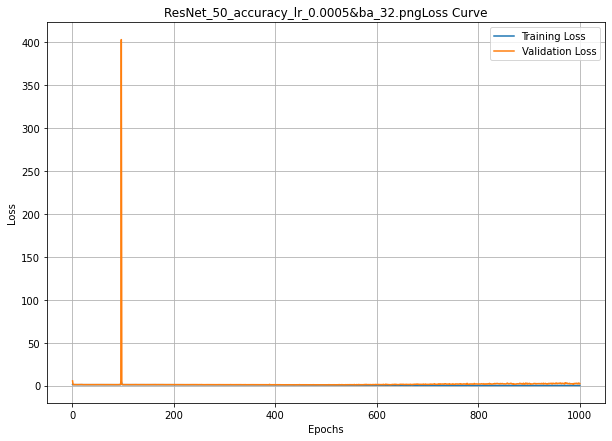

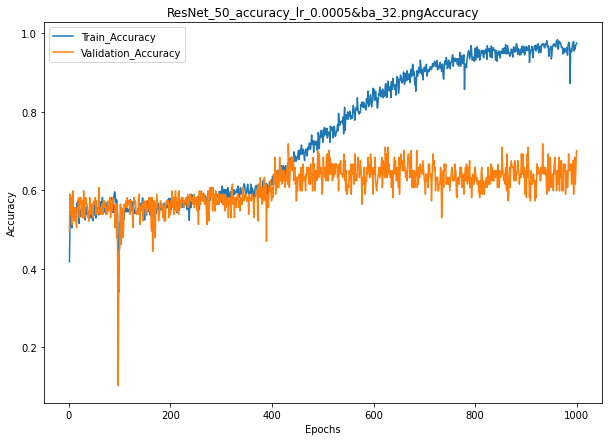

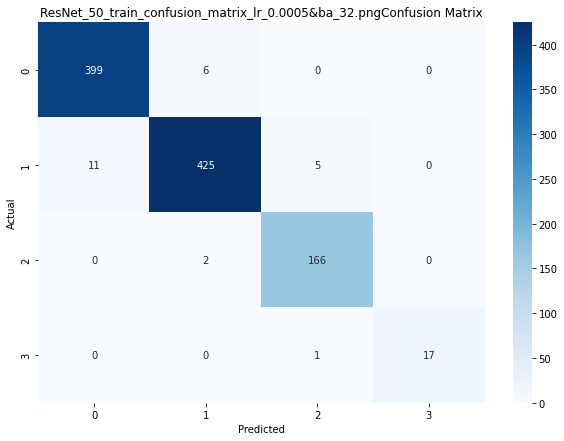

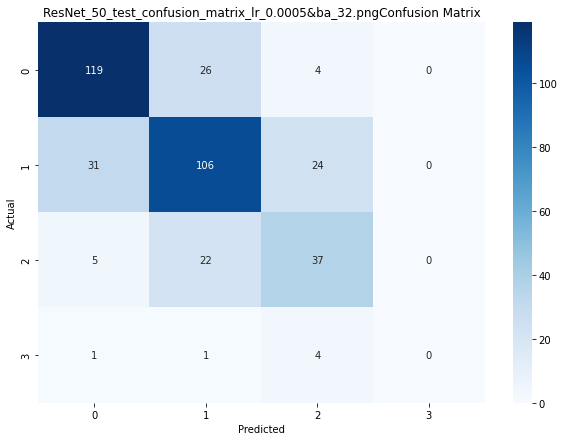

In [23]:

#criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# class_weights = torch.tensor([ 2.5343,  2.3236,  6.2289, 68.9333]).to(device)
# criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], []
best_val_loss = float('inf')
best_accuaracy = 0
patience_counter = 0

# Training and validation loops
for epoch in range(1, epochs+1):  # 100 epochs
    

    # Training
    model.train()
    pbar = tqdm(train_loader, total=len(train_loader))
    running_loss = 0
    correct = 0
    total = 0
    print(epoch)
    for batch in pbar:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_description(f'Epoch train [{epoch}/100]')
        pbar.set_postfix(loss=f'{running_loss / (len(pbar) + 1):.2f}')

    
    print(f'Training Loss: {running_loss / len(train_loader):.4f}')

    print(f'Training Accuracy: {correct / total:.4f}')
    train_acc=correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(train_acc)

    # Validation
    model.eval()
    pbar = tqdm(val_loader, total=len(val_loader))
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in pbar:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            pbar.set_description(f'Epoch val [{epoch}/100]')
            pbar.set_postfix(loss=f'{running_loss / (len(pbar) + 1):.2f}')

    print(f'Validation Loss: {running_loss / len(val_loader):.4f}')

    print(f'Validation Accuracy: {correct / total:.4f}')

    val_losses.append(running_loss / len(val_loader))
    val_accuracy.append(correct / total)

    # Save the model
    # Early stopping
    if running_loss < best_val_loss:
        best_val_loss = running_loss
        # patience_counter = 0
        torch.save(model.state_dict(), f'{model_name}_lr_{lr}&ba_{batch_size}_best_loss_model.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= params['patience']:
    #         break
    
    # Early stopping for accuracy
    
    train_acc_p, _, _ = evaluate_train_model(model, val_loader, device)

    if train_acc > best_accuaracy:
        best_accuaracy = train_acc
    torch.save(model.state_dict(), f'{model_name}_lr_{lr}&ba_{batch_size}_best_accuaracy_model.pth')

    if epoch % save_plot_every_epochs == 0:

        torch.save(model.state_dict(), f'{model_name}_lr_{lr}&ba_{batch_size}_epoch{epoch}_model.pth')

        # Evaluation
        _, train_acc, train_conf_matrix = evaluate_train_model(model, train_loader, device)
        test_acc, test_conf_matrix = evaluate_test_model(model, test_loader, device)

        epoch_range= epoch+1
        #save and show accuracy
        plot_loss_curve(train_losses, val_losses, model_name,f"{model_name}_accuracy_lr_{lr}&ba_{batch_size}.png", epoch_range)
        plot_accuracy(train_accuracy, val_accuracy, f"{model_name}_accuracy_lr_{lr}&ba_{batch_size}.png",epoch_range)

        # Save and show confusion matrices
        save_confusion_matrix(train_conf_matrix, f"{model_name}_train_confusion_matrix_lr_{lr}&ba_{batch_size}.png")
        save_confusion_matrix(test_conf_matrix, f"{model_name}_test_confusion_matrix_lr_{lr}&ba_{batch_size}.png")


# torch.save(model.state_dict(), f'{model_name}_lr_{lr}&ba_{batch_size}_epoch{epochs}_model.pth')

# # Evaluation
# _, train_acc, train_conf_matrix = evaluate_train_model(model, train_loader, device)
# test_acc, test_conf_matrix = evaluate_test_model(model, test_loader, device)


# #save and show accuracy
# plot_loss_curve(train_losses, val_losses, model_name,f"{model_name}_accuracy_lr_{lr}&ba_{batch_size}.png", epochs)
# plot_accuracy(train_accuracy, val_accuracy, f"{model_name}_accuracy_lr_{lr}&ba_{batch_size}.png",epochs)

# # Save and show confusion matrices
# save_confusion_matrix(train_conf_matrix, f"{model_name}_train_confusion_matrix_lr_{lr}&ba_{batch_size}.png")
# save_confusion_matrix(test_conf_matrix, f"{model_name}_test_confusion_matrix_lr_{lr}&ba_{batch_size}.png")
    

# 3. Evaluate your model using the developed software

## 1. plot the result image

1. load model to save the prediction file.
2. use cow teat accuracy software to get the reuslt.
3. plot the result.

1. load model to save the prediction file.


In [29]:
def find_all_model(path):
    model_list=[]
    for filename in os.listdir(path):
        if filename.endswith('.pth'):
            model_list.append(filename)
    return model_list

model_list=find_all_model('/home/xin/Homework Week5/Homework Week7')
model_list

['ResNet_50_lr_0.0005&ba_32_epoch1000_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch800_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch300_model.pth',
 'ResNet_50_lr_0.0005&ba_32_best_loss_model.pth',
 'ResNet_50_lr_0.0005&ba_32_best_accuaracy_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch900_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch100_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch600_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch500_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch400_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch700_model.pth',
 'ResNet_50_lr_0.0005&ba_32_epoch200_model.pth']

In [30]:
for i in model_list:
    # load the best model weights
    name=i[:-4]
    model.load_state_dict(torch.load(i))

    model.eval()

    all_preds = []
    all_filenames = []

    with torch.no_grad():
        for images, filenames in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_filenames.extend(filenames)


    with open(f'{name}_pred.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        for filename, pred in zip(all_filenames, all_preds):
            writer.writerow([filename, pred])



2. use cow teat accuracy software to get the reuslt.


3. plot the result.

In [32]:
def find_all_png(path):
    png_list=[]
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            png_list.append(filename)
    return png_list

png_list=find_all_png('/home/xin/Homework Week5/Homework Week7')
png_list

['ResNet_50_lr_0.0005&ba_32_best_accuaracy_model.png',
 'ResNet_50_accuracy_lr_0.0005&ba_32.png',
 'ResNet_50_lr_0.0005&ba_32_epoch_1000_model.png',
 'ResNet_50_train_confusion_matrix_lr_0.0005&ba_32.png',
 'ResNet_50_lr_0.0005&ba32__loss_curve.png',
 'ResNet_50_test_confusion_matrix_lr_0.0005&ba_32.png']

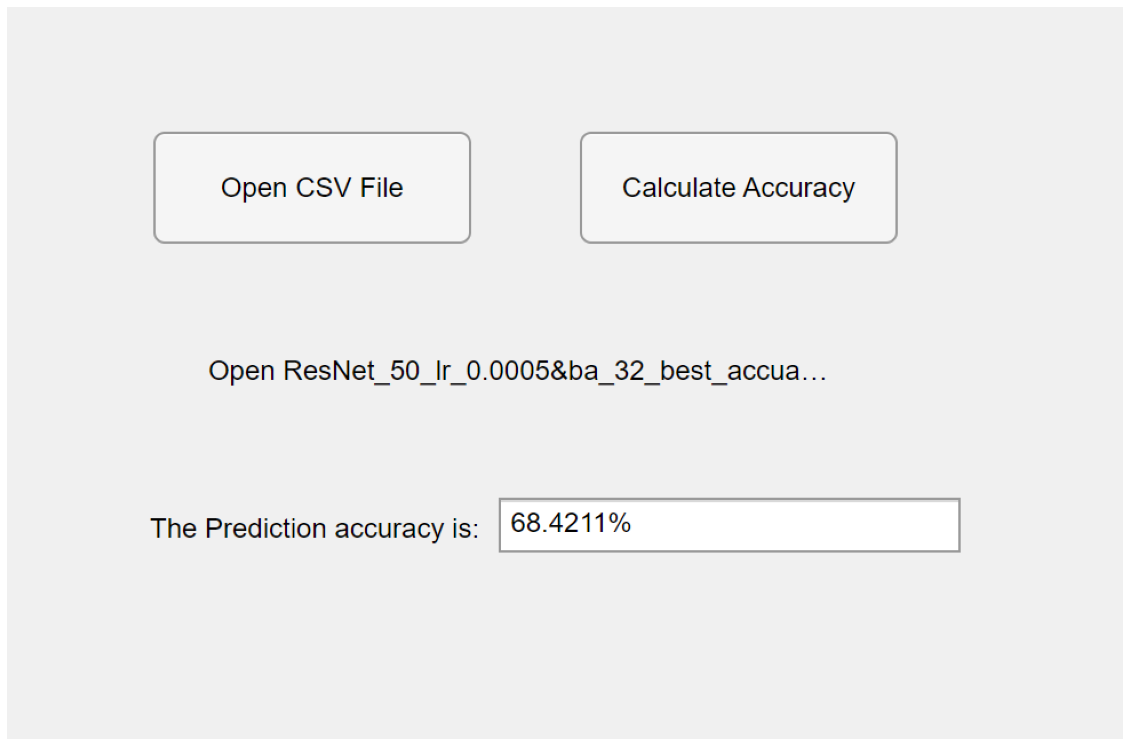

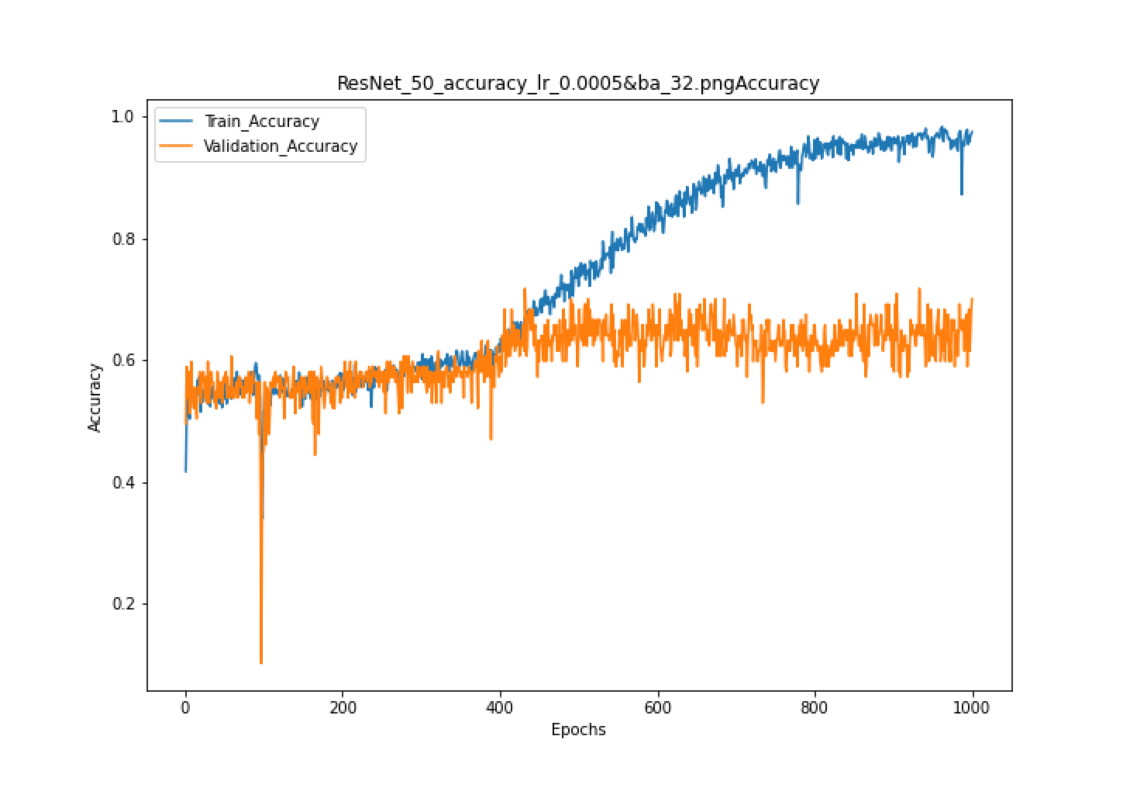

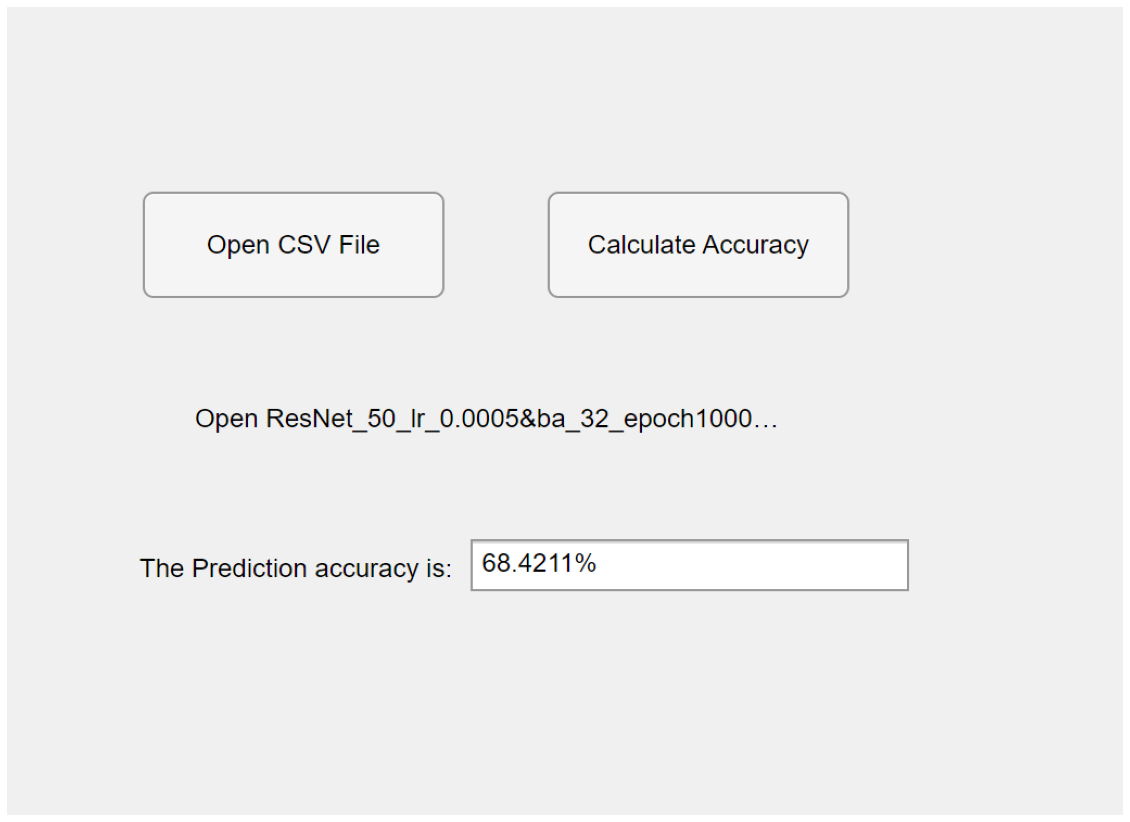

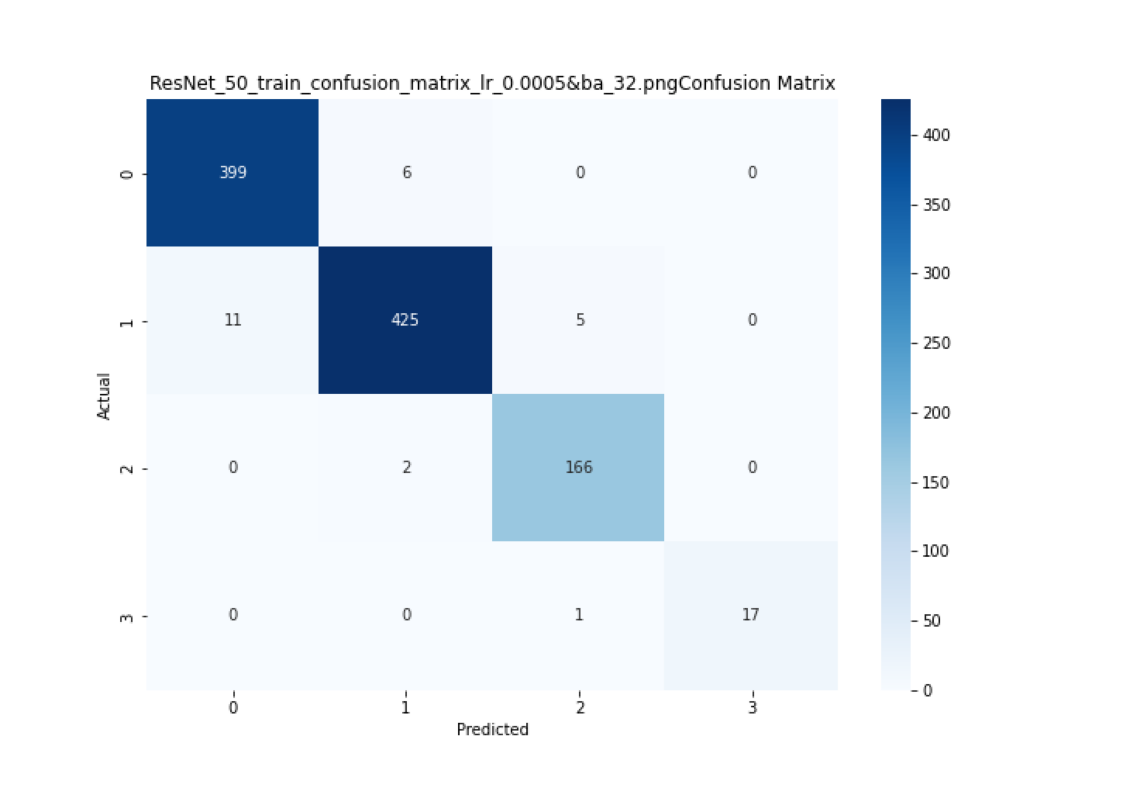

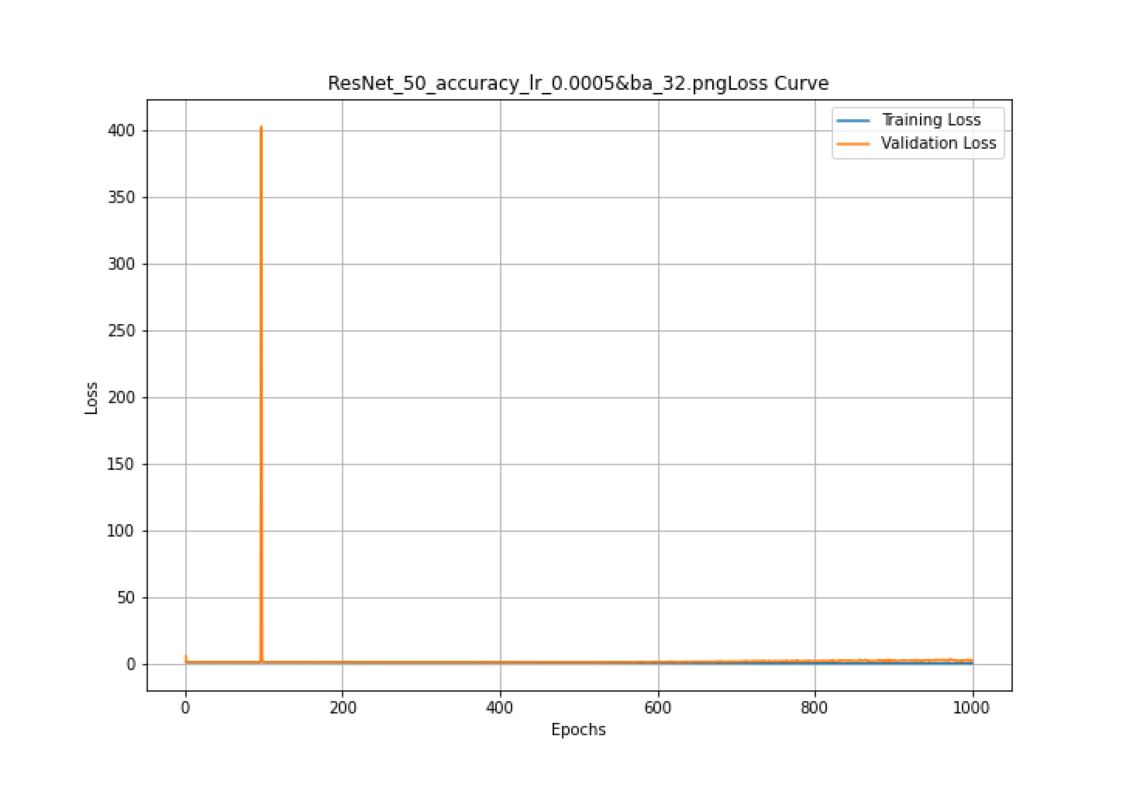

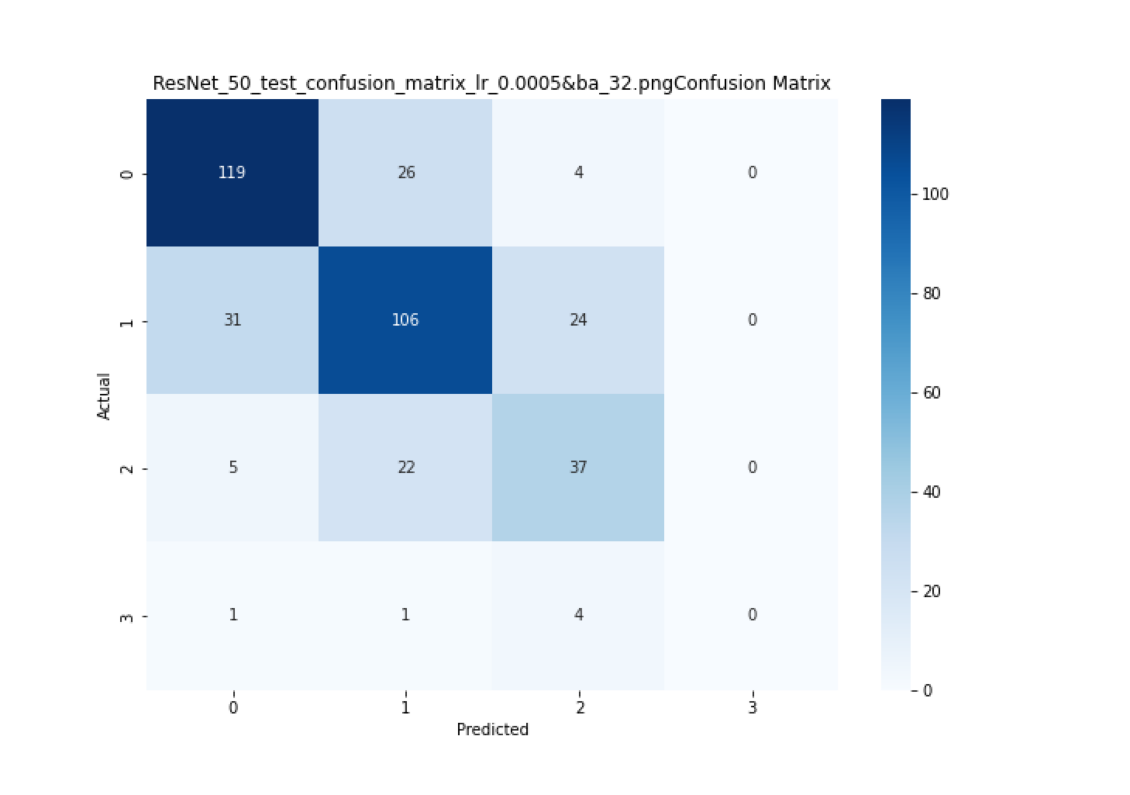

In [41]:
for i in png_list:
    filename=os.path.join('/home/xin/Homework Week5/Homework Week7',i)
    image=Image.open(filename)
    plt.figure(figsize=(20,20))

    plt.imshow(image)
    plt.axis('off')
    plt.show()

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 66.8% -->10 points
     < 40 % -->0 points
     >= 40 % & < 66.8% --> 0.3731 point/percent
     

(6). Discussion - 10 points